In [1]:
import torch
from torch import nn,optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from utils import Logger

In [ ]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
        #  transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        transforms.Normalize([0.5],[0.5])
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [26]:
def ss_data(flag='train'):
    if flag == 'train':
        return torch.load('../dataloader_32_train.pt')
    elif flag == 'test':
        return torch.load('../dataloader_32_test.pt')
    else:
        raise NameError("No such data loader")
train_dataloader = ss_data()
num_batches_train = len(train_dataloader)
test_dataloader = ss_data('test')
num_batches_test = len(test_dataloader)

In [55]:
def temper_data(flag="train"):
    if flag == 'train':
        return torch.load('../dataloader_temp_train2.pt')
    elif flag == 'test':
        return torch.load('../dataloader_temp_test2.pt')
    else:
        raise NameError('No such data loader')
train_dataloader = temper_data()
num_batches_train = len(train_dataloader)
test_dataloader = temper_data('test')
num_batches_test = len(test_dataloader)

In [3]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 19*7
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [ ]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 22, 28)

In [4]:
print(19*7)

133


In [5]:
def images_to_vectors(images):
    return images.view(images.size(0),133)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 19, 7)

In [6]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 133
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [7]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100,dtype=torch.float32))
    return n


In [8]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [9]:
loss = nn.BCELoss()

In [10]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1,dtype=torch.float32))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1,dtype=torch.float32))
    return data

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [12]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [13]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [41]:
real_batch[0]

tensor([[    nan,     nan,  0.9967,     nan,     nan,     nan,  1.0649],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [ 2.6451,  2.6469,  2.7148,  2.5874,  2.7121,  2.6553,  2.6521],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [-0.0909, -0.1600,  0.0209, -0.0388, -0.1102,  0.0295,  0.0278],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [ 2.1137,  2.2943,  2.0367,  2.1628,  2.1079,  2.2242,  2.2268],
        [    nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [-0.4265, -0.4870, -0.4902, -0.4883, -0.6128, -0.5546, -0.5580],
        [ 1.0495,  1.1108,  1.1106,  1.2394,  1.1059,  1.1775,  1.2369],
        [ 0.8770,  0.8703,  0.8632,  0.8600,  0.795

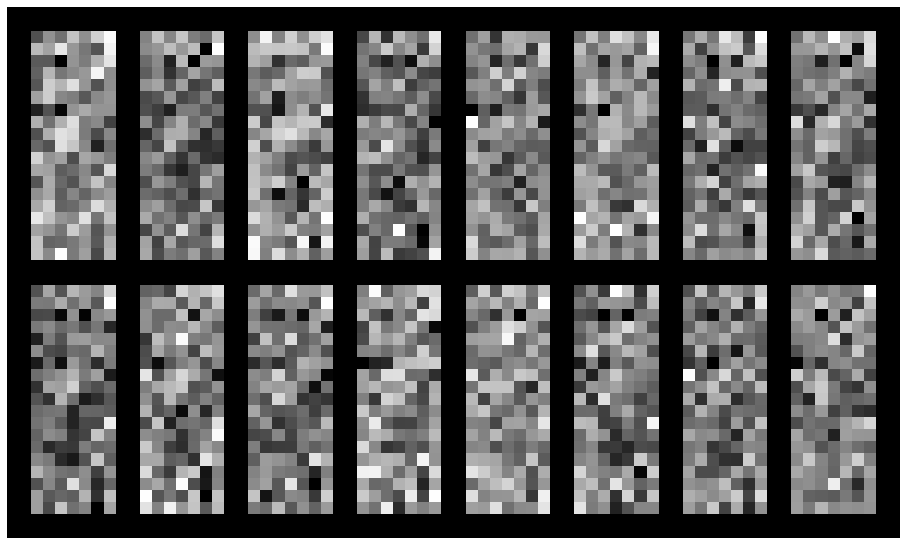

Epoch: [0/200], Batch Num: [0/54]
Discriminator Loss: 1.4868, Generator Loss: 0.7051
D(x): 0.4583, D(G(z)): 0.4916


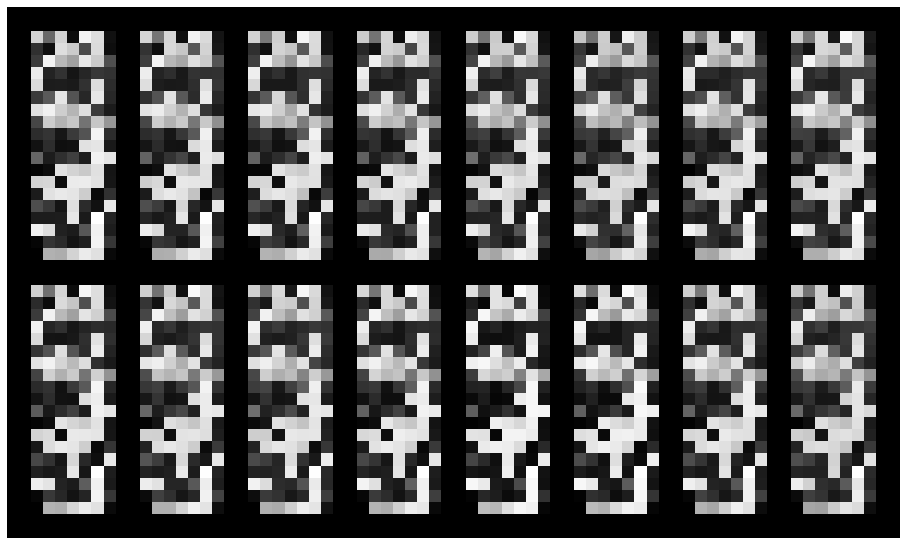

Epoch: [1/200], Batch Num: [0/54]
Discriminator Loss: 0.8642, Generator Loss: 0.8503
D(x): 0.8897, D(G(z)): 0.5121


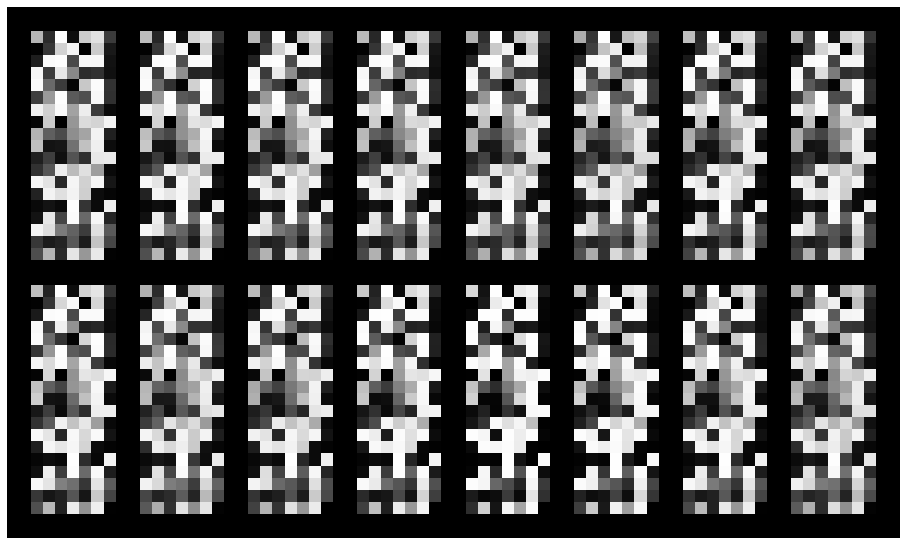

Epoch: [2/200], Batch Num: [0/54]
Discriminator Loss: 0.1014, Generator Loss: 3.3578
D(x): 0.9687, D(G(z)): 0.0554


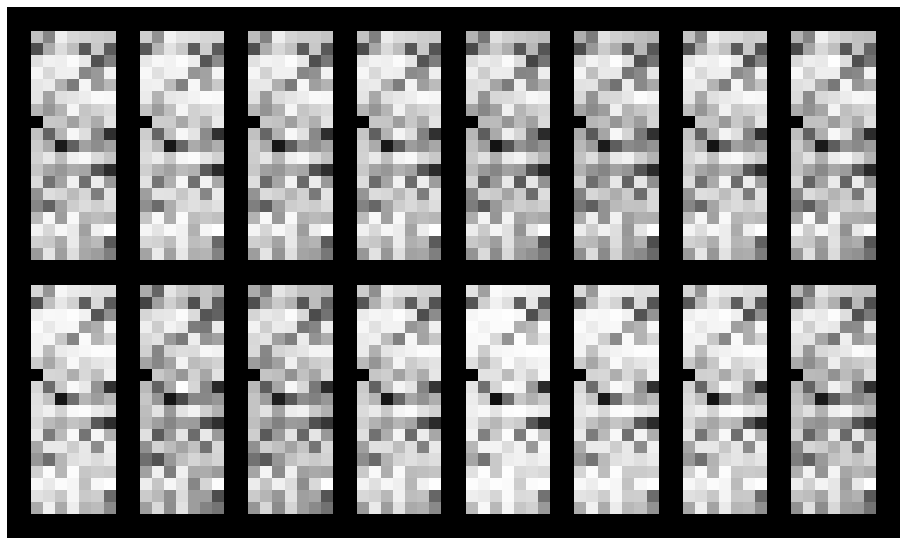

Epoch: [3/200], Batch Num: [0/54]
Discriminator Loss: 0.5645, Generator Loss: 1.5423
D(x): 0.9306, D(G(z)): 0.3463


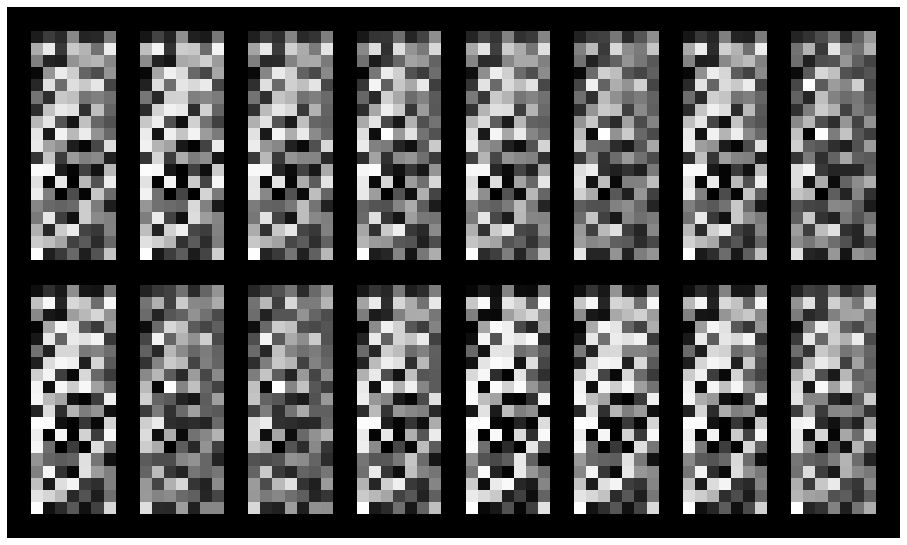

Epoch: [4/200], Batch Num: [0/54]
Discriminator Loss: 0.3911, Generator Loss: 2.5007
D(x): 0.9875, D(G(z)): 0.2950


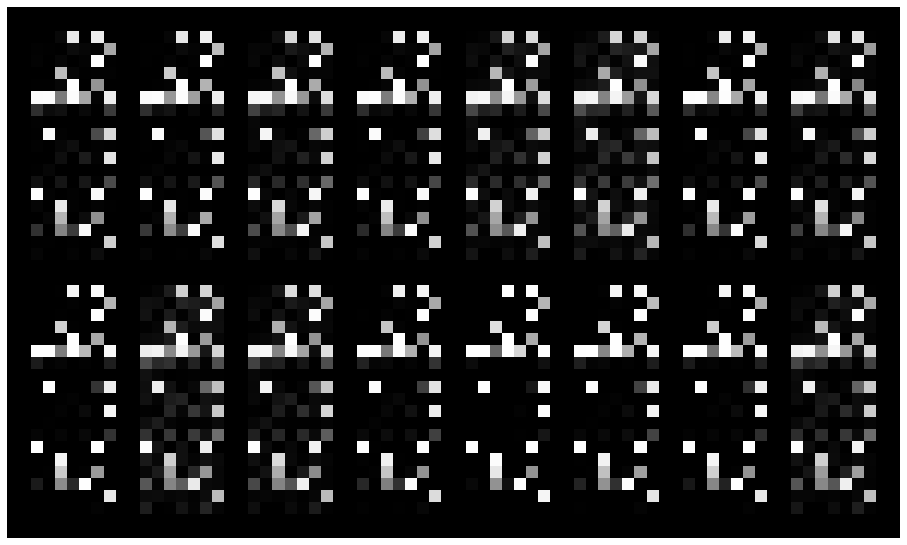

Epoch: [5/200], Batch Num: [0/54]
Discriminator Loss: 0.0891, Generator Loss: 5.5241
D(x): 0.9716, D(G(z)): 0.0381


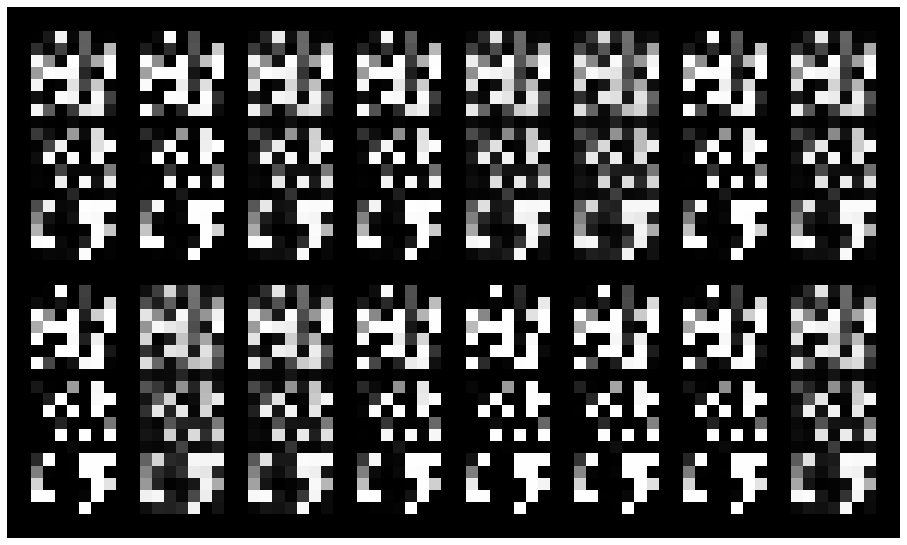

Epoch: [6/200], Batch Num: [0/54]
Discriminator Loss: 0.0412, Generator Loss: 5.4406
D(x): 0.9919, D(G(z)): 0.0275


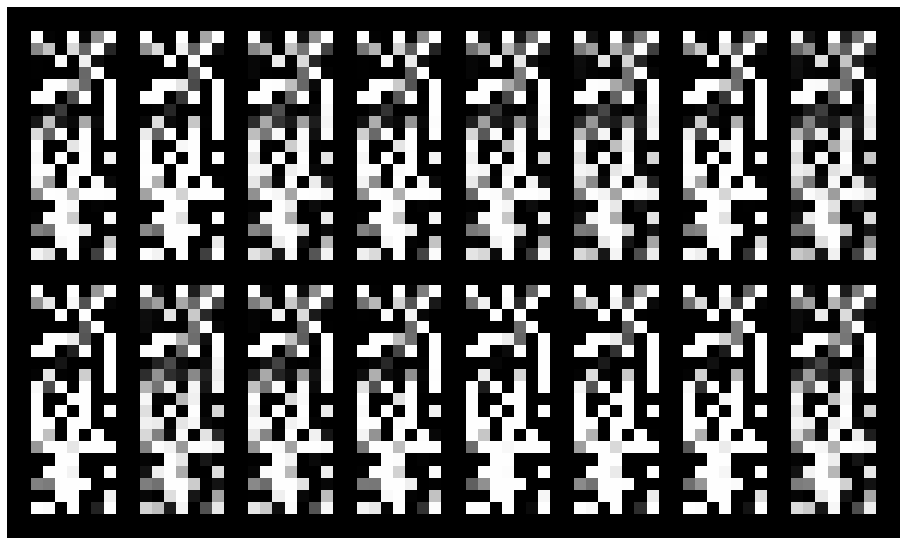

Epoch: [7/200], Batch Num: [0/54]
Discriminator Loss: 0.0719, Generator Loss: 5.6186
D(x): 0.9750, D(G(z)): 0.0179


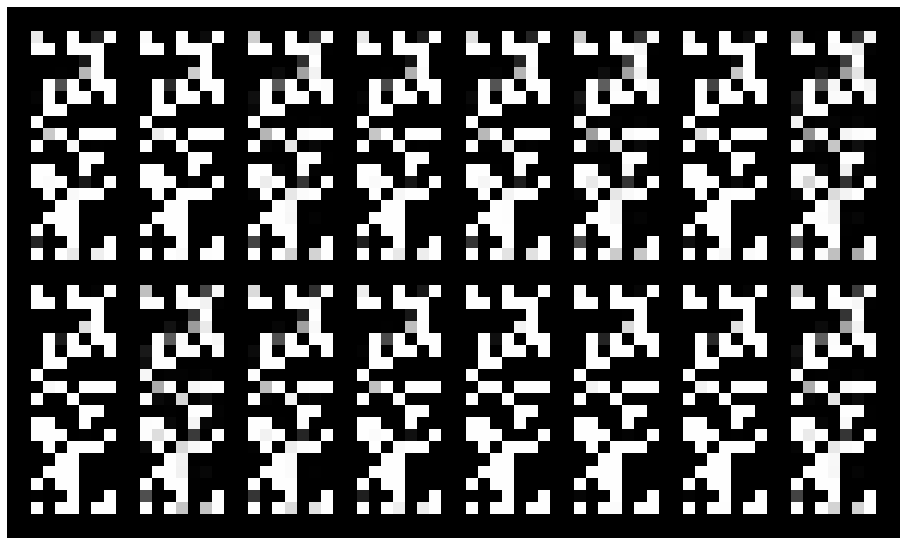

Epoch: [8/200], Batch Num: [0/54]
Discriminator Loss: 0.0147, Generator Loss: 9.4466
D(x): 0.9953, D(G(z)): 0.0003


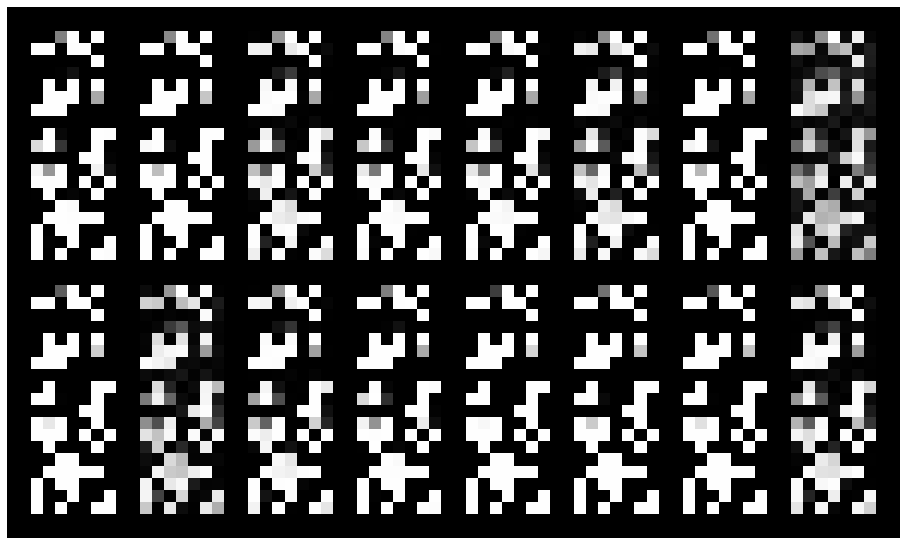

Epoch: [9/200], Batch Num: [0/54]
Discriminator Loss: 0.0191, Generator Loss: 7.9509
D(x): 0.9952, D(G(z)): 0.0077


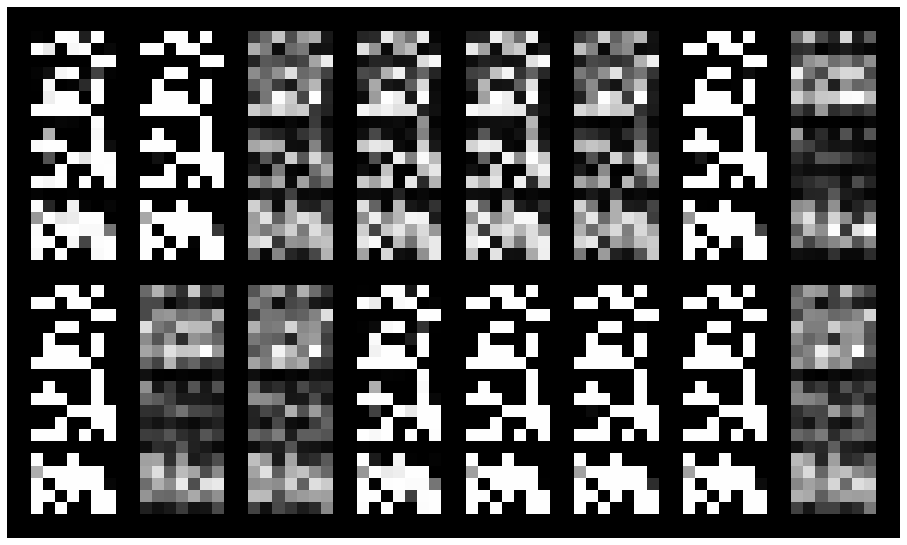

Epoch: [10/200], Batch Num: [0/54]
Discriminator Loss: 0.0766, Generator Loss: 8.5609
D(x): 0.9744, D(G(z)): 0.0189


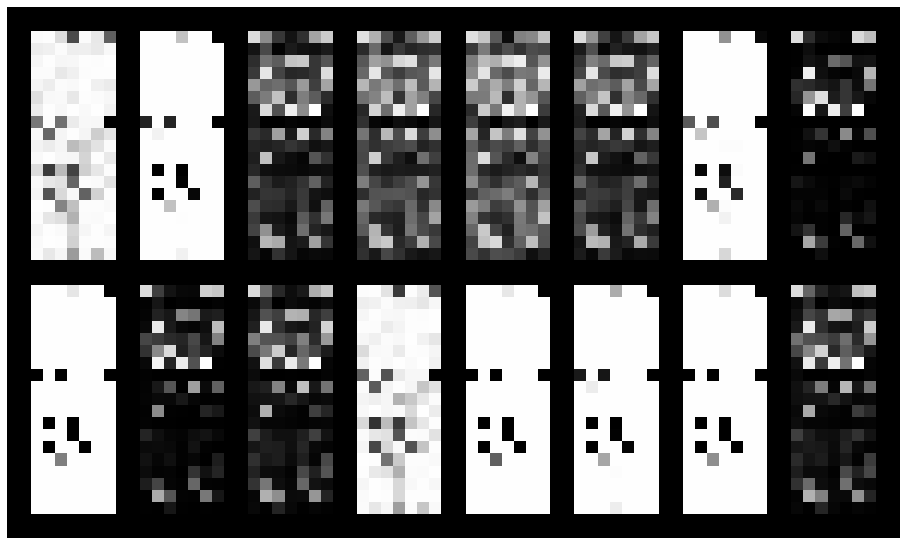

Epoch: [11/200], Batch Num: [0/54]
Discriminator Loss: 0.0389, Generator Loss: 7.0653
D(x): 0.9943, D(G(z)): 0.0284


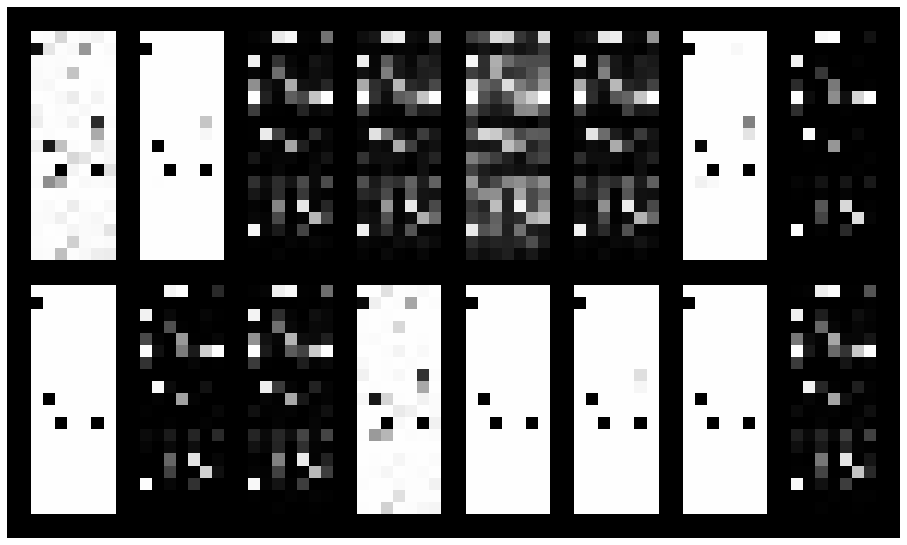

Epoch: [12/200], Batch Num: [0/54]
Discriminator Loss: 0.0345, Generator Loss: 5.9962
D(x): 0.9950, D(G(z)): 0.0138


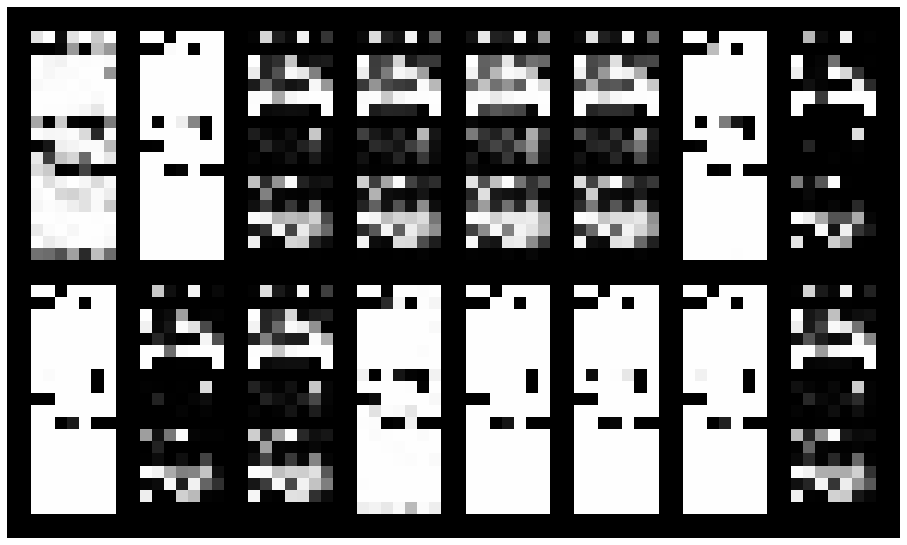

Epoch: [13/200], Batch Num: [0/54]
Discriminator Loss: 0.0685, Generator Loss: 8.1154
D(x): 0.9862, D(G(z)): 0.0142


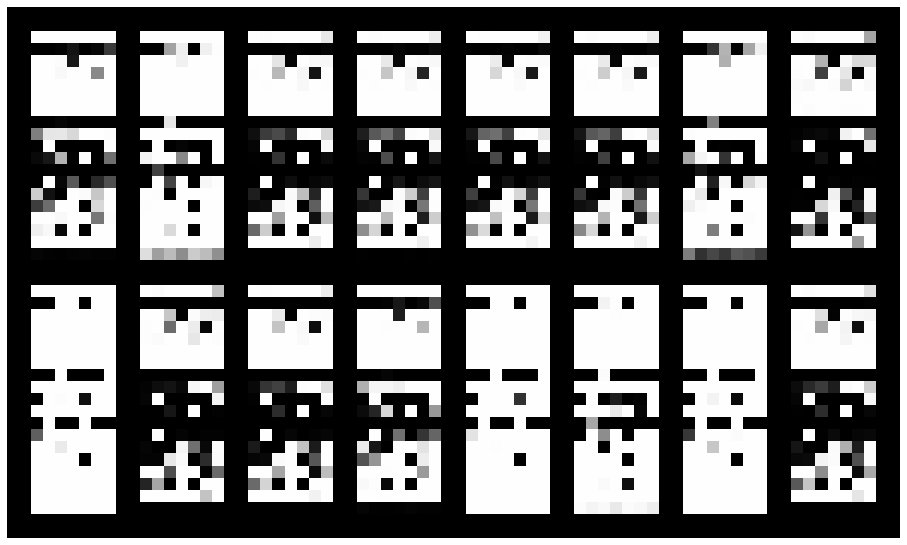

Epoch: [14/200], Batch Num: [0/54]
Discriminator Loss: 0.0352, Generator Loss: 7.2594
D(x): 0.9877, D(G(z)): 0.0077


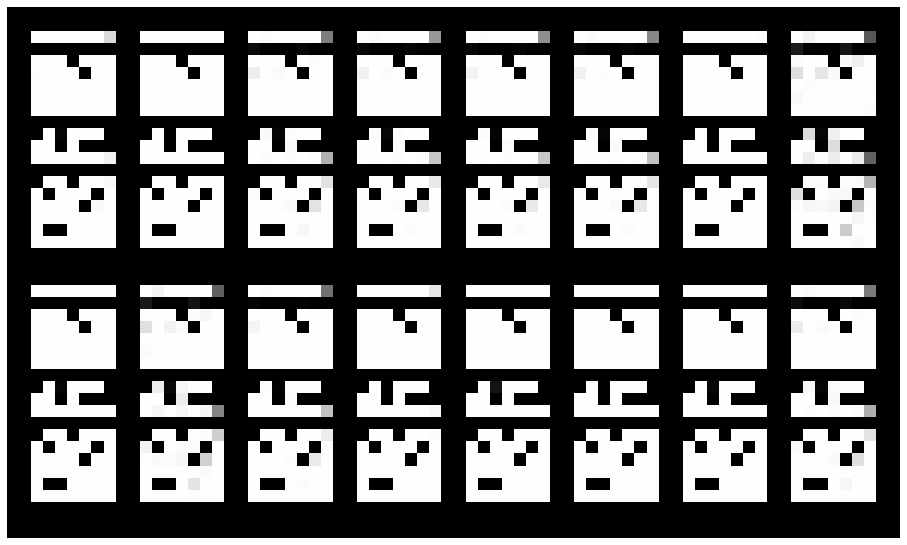

Epoch: [15/200], Batch Num: [0/54]
Discriminator Loss: 0.0035, Generator Loss: 9.3528
D(x): 0.9976, D(G(z)): 0.0007


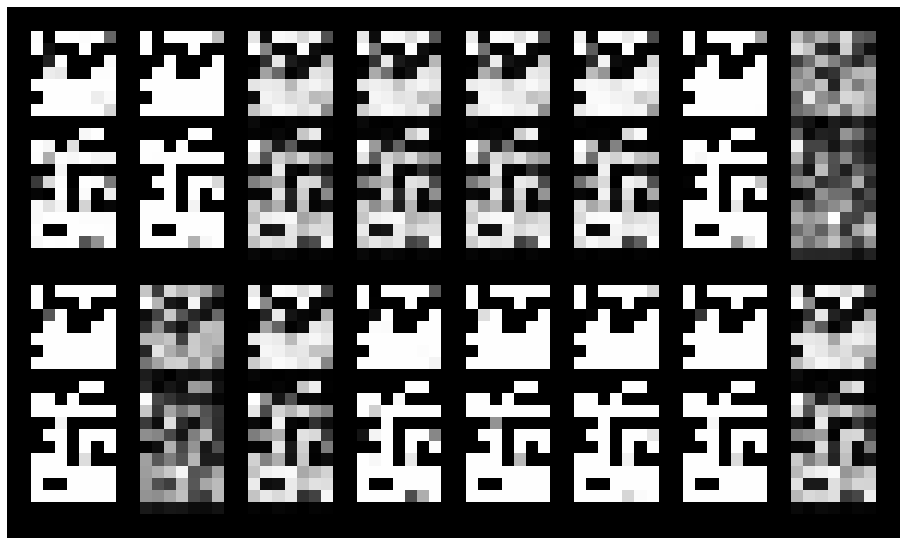

Epoch: [16/200], Batch Num: [0/54]
Discriminator Loss: 0.0210, Generator Loss: 9.5976
D(x): 0.9963, D(G(z)): 0.0137


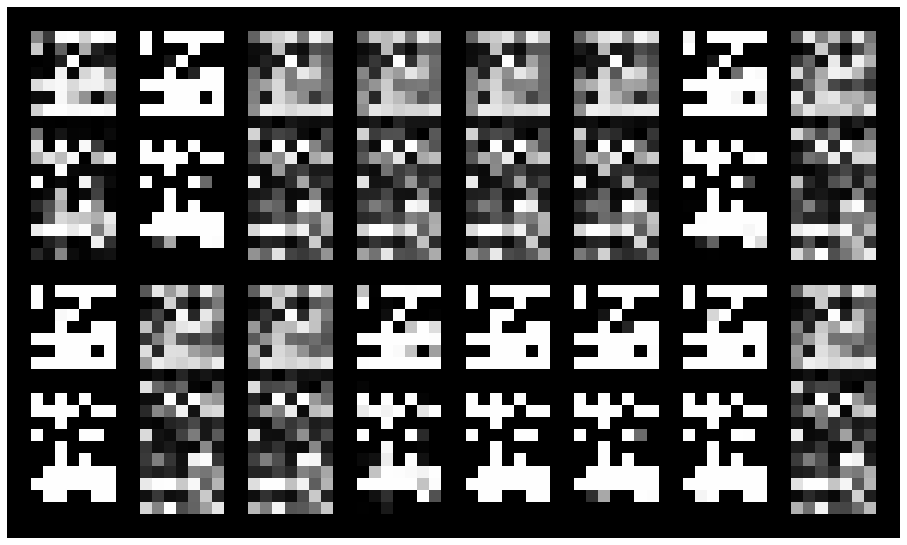

Epoch: [17/200], Batch Num: [0/54]
Discriminator Loss: 0.0613, Generator Loss: 9.8688
D(x): 0.9908, D(G(z)): 0.0326


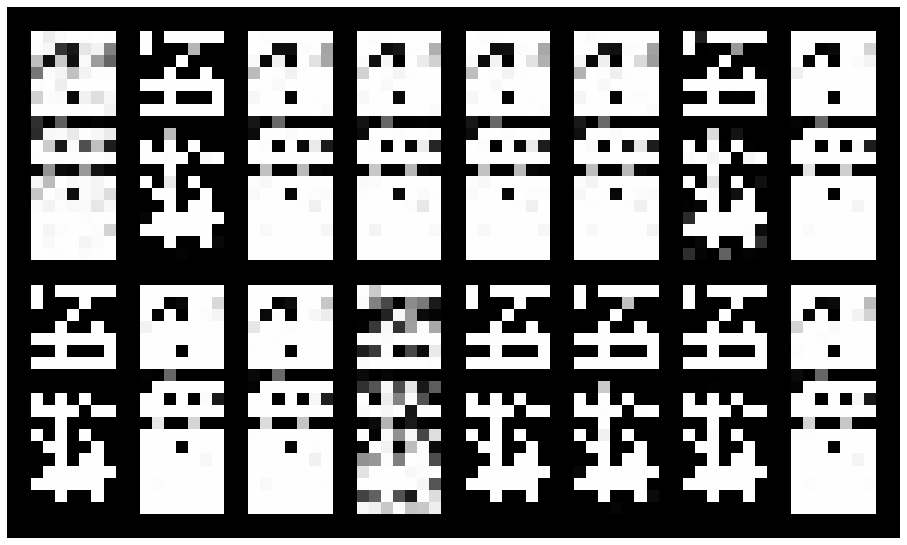

Epoch: [18/200], Batch Num: [0/54]
Discriminator Loss: 0.0089, Generator Loss: 8.1369
D(x): 0.9974, D(G(z)): 0.0056


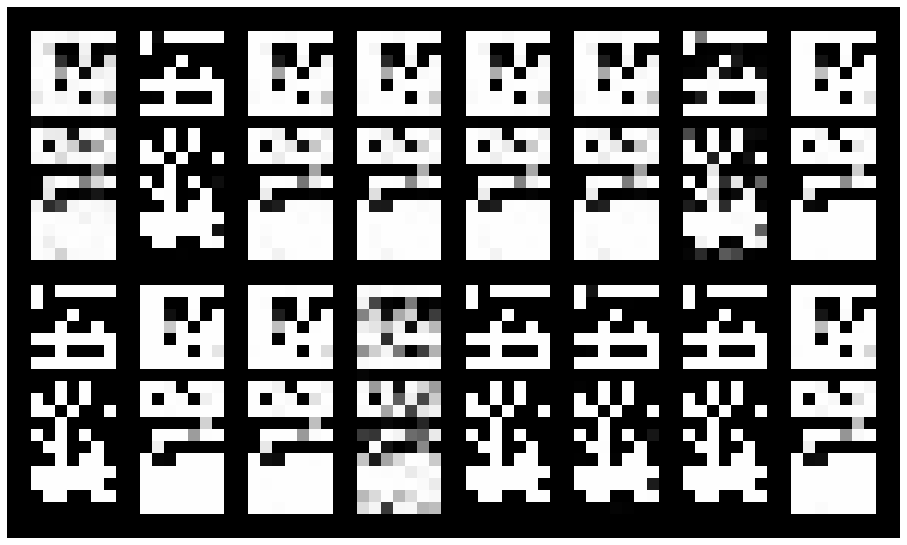

Epoch: [19/200], Batch Num: [0/54]
Discriminator Loss: 0.0075, Generator Loss: 7.8310
D(x): 0.9977, D(G(z)): 0.0045


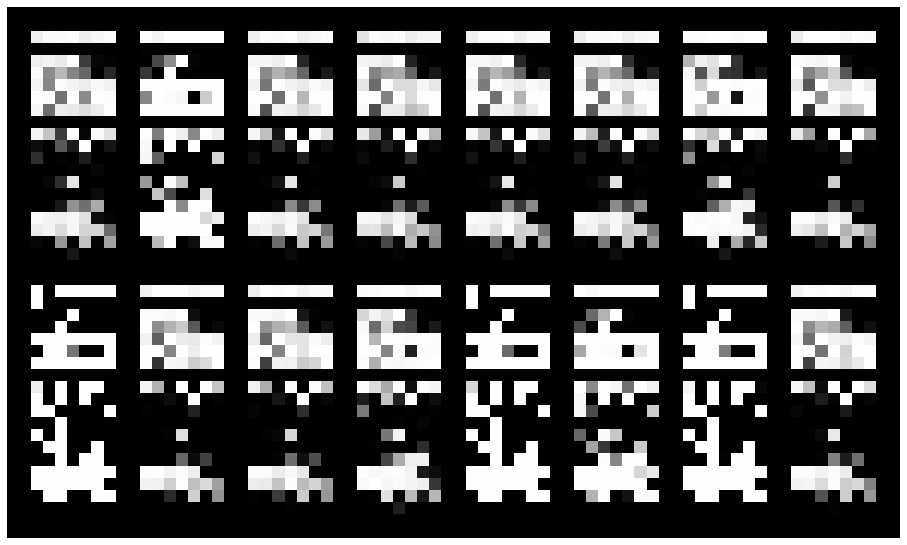

Epoch: [20/200], Batch Num: [0/54]
Discriminator Loss: 0.0273, Generator Loss: 10.3094
D(x): 0.9911, D(G(z)): 0.0036


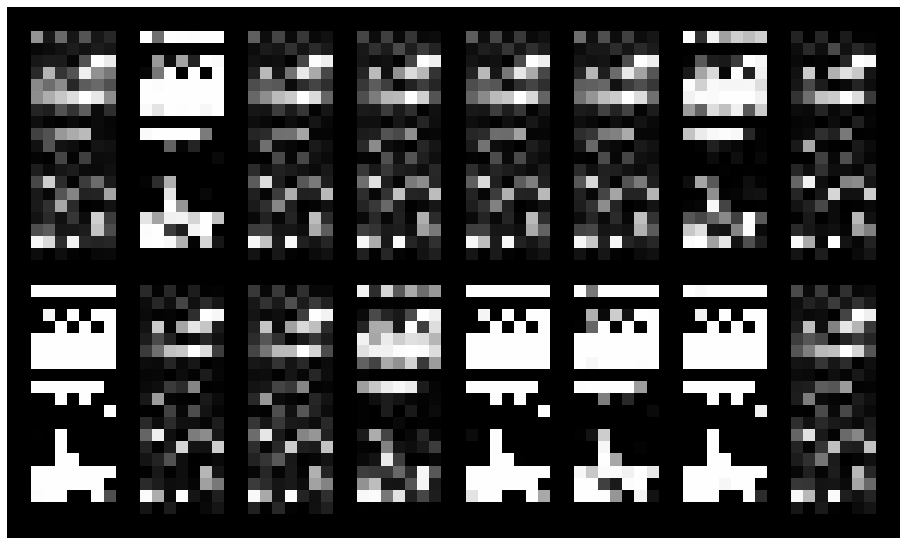

Epoch: [21/200], Batch Num: [0/54]
Discriminator Loss: 0.0202, Generator Loss: 7.5779
D(x): 0.9944, D(G(z)): 0.0092


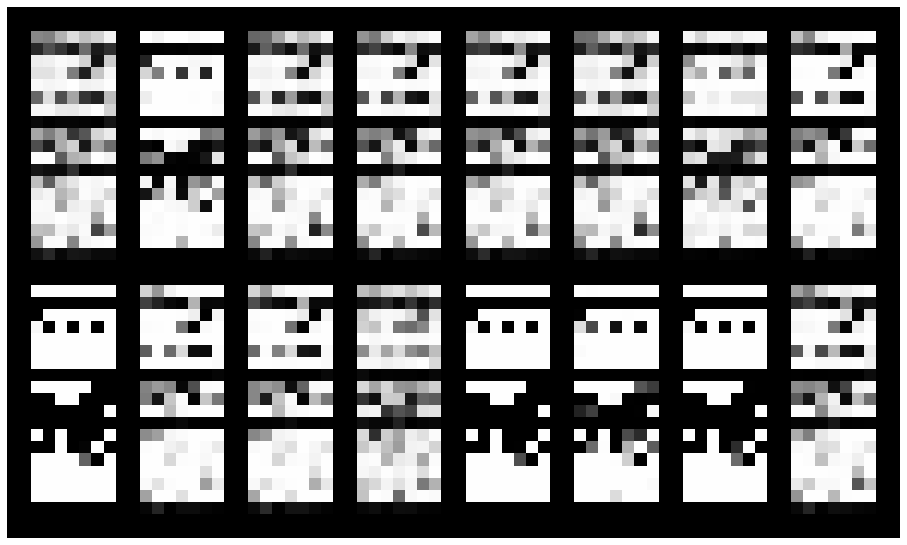

Epoch: [22/200], Batch Num: [0/54]
Discriminator Loss: 0.0160, Generator Loss: 9.0804
D(x): 0.9939, D(G(z)): 0.0012


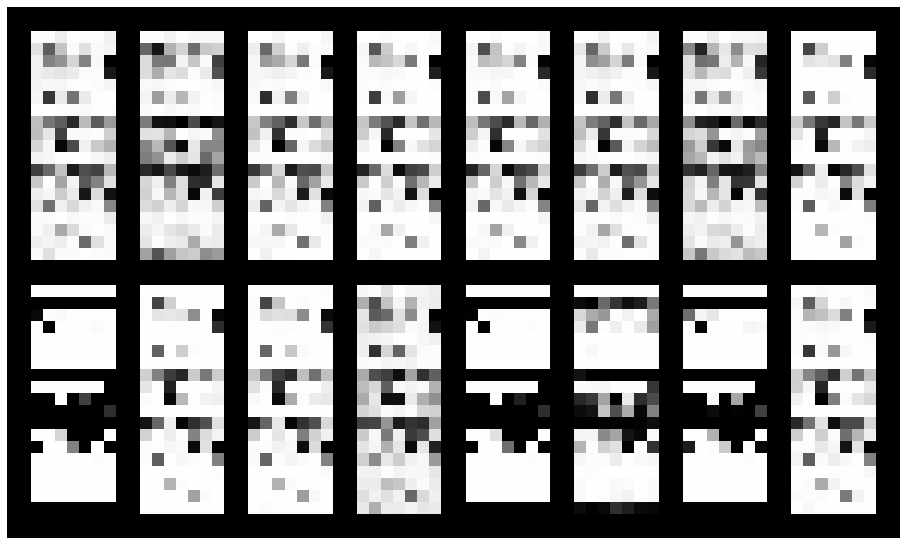

Epoch: [23/200], Batch Num: [0/54]
Discriminator Loss: 0.0598, Generator Loss: 7.6075
D(x): 0.9890, D(G(z)): 0.0147


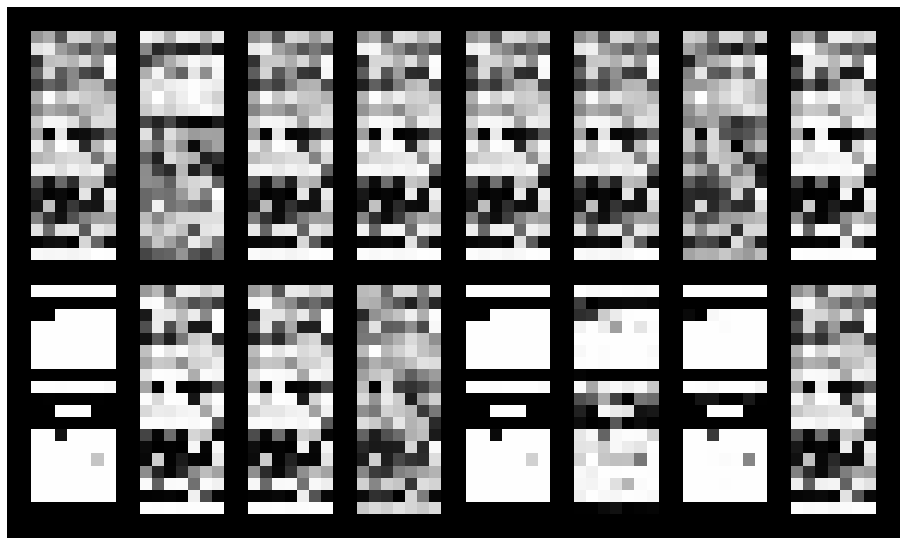

Epoch: [24/200], Batch Num: [0/54]
Discriminator Loss: 0.0982, Generator Loss: 6.4790
D(x): 0.9808, D(G(z)): 0.0174


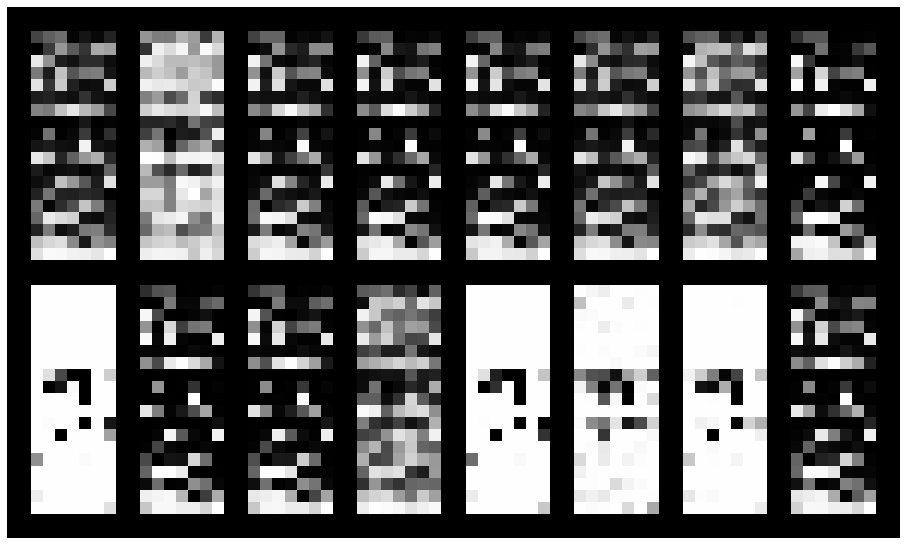

Epoch: [25/200], Batch Num: [0/54]
Discriminator Loss: 0.0655, Generator Loss: 6.6907
D(x): 0.9911, D(G(z)): 0.0217


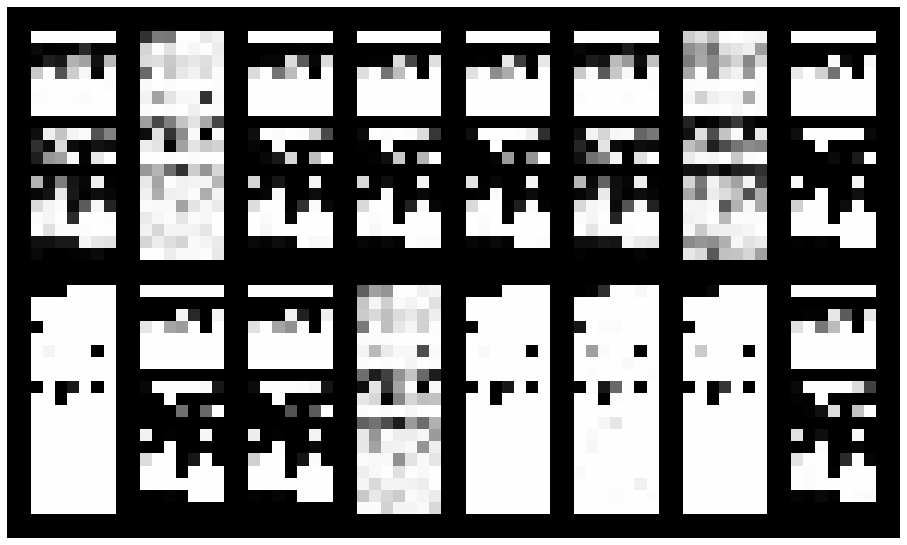

Epoch: [26/200], Batch Num: [0/54]
Discriminator Loss: 0.0468, Generator Loss: 7.4510
D(x): 0.9887, D(G(z)): 0.0079


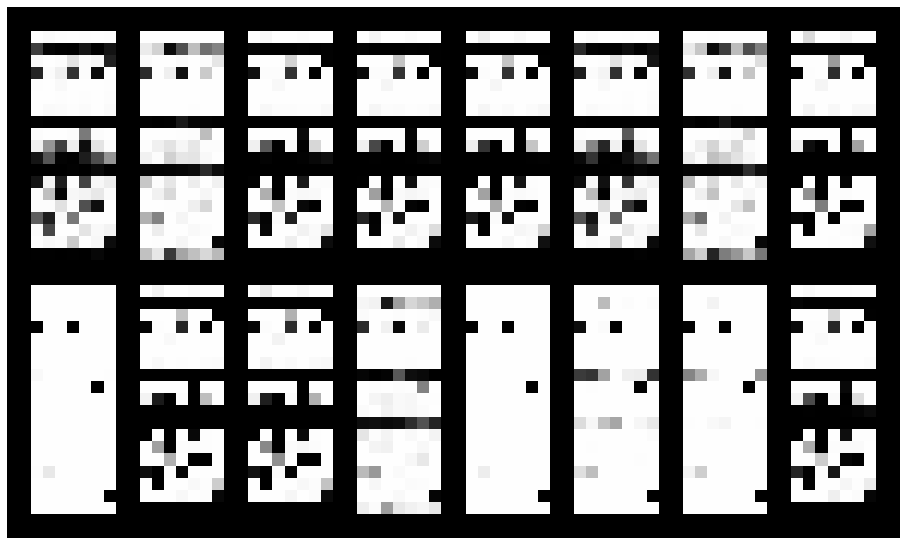

Epoch: [27/200], Batch Num: [0/54]
Discriminator Loss: 0.0194, Generator Loss: 7.4557
D(x): 0.9915, D(G(z)): 0.0046


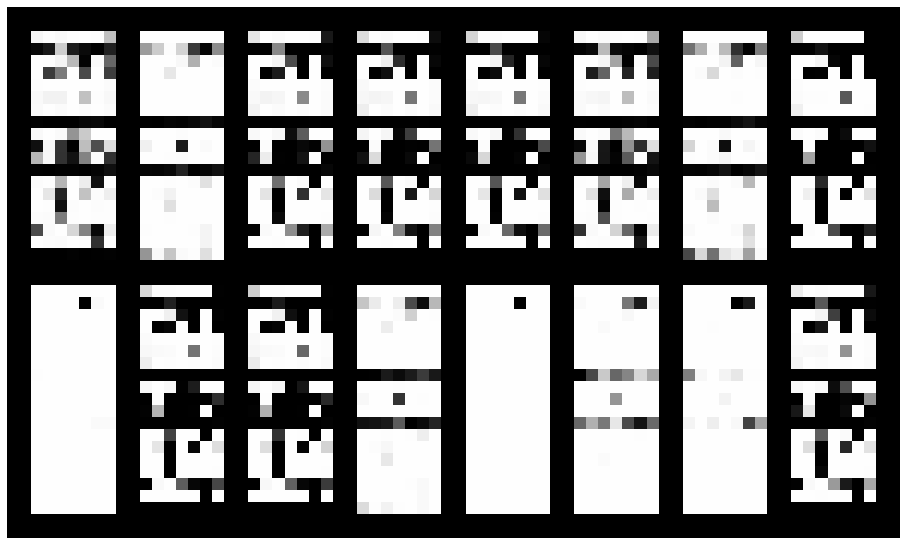

Epoch: [28/200], Batch Num: [0/54]
Discriminator Loss: 0.0122, Generator Loss: 7.5437
D(x): 0.9964, D(G(z)): 0.0038


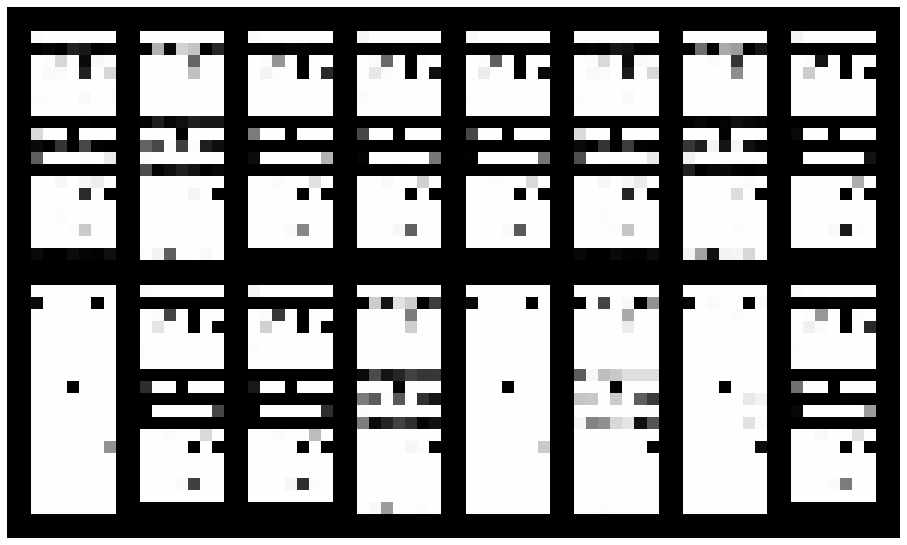

Epoch: [29/200], Batch Num: [0/54]
Discriminator Loss: 0.0087, Generator Loss: 8.0290
D(x): 0.9960, D(G(z)): 0.0022


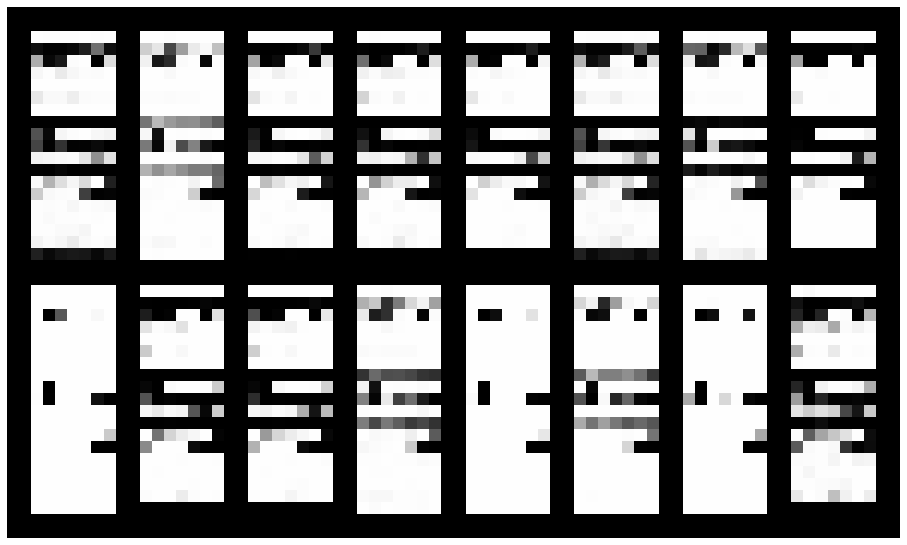

Epoch: [30/200], Batch Num: [0/54]
Discriminator Loss: 0.0430, Generator Loss: 7.7521
D(x): 0.9818, D(G(z)): 0.0018


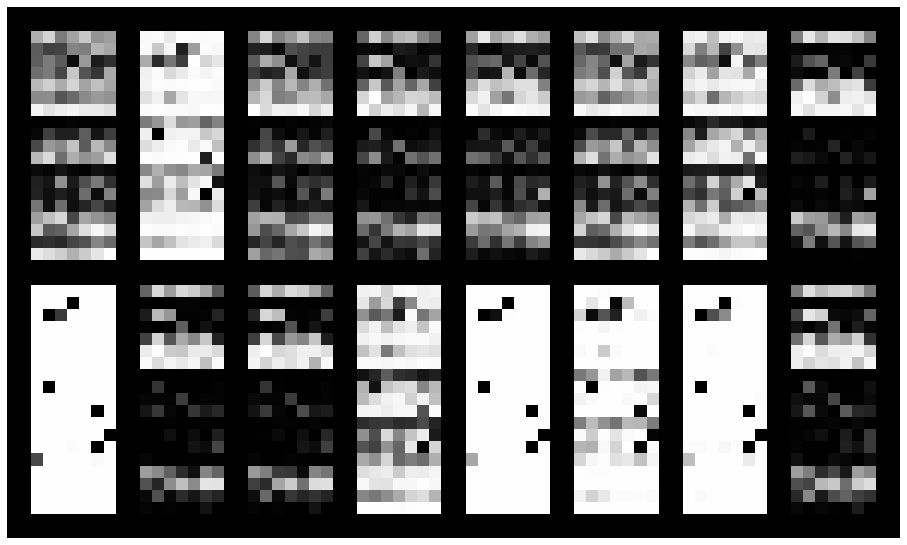

Epoch: [31/200], Batch Num: [0/54]
Discriminator Loss: 0.0474, Generator Loss: 6.5901
D(x): 0.9863, D(G(z)): 0.0137


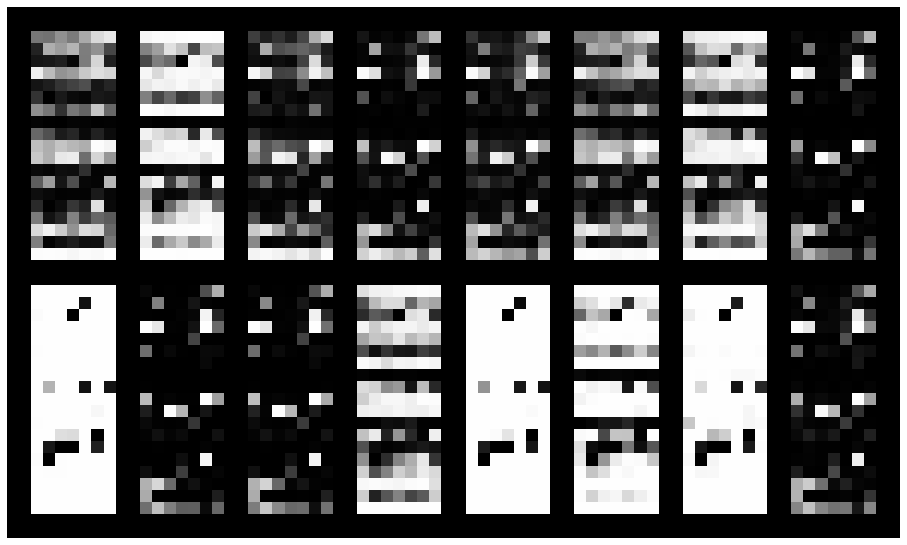

Epoch: [32/200], Batch Num: [0/54]
Discriminator Loss: 0.0152, Generator Loss: 7.6223
D(x): 0.9979, D(G(z)): 0.0115


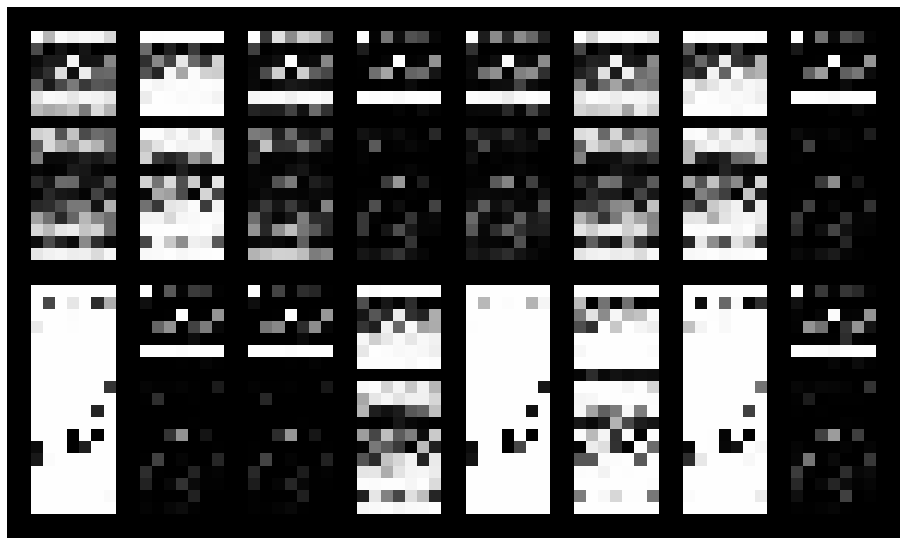

Epoch: [33/200], Batch Num: [0/54]
Discriminator Loss: 0.0420, Generator Loss: 8.2853
D(x): 0.9931, D(G(z)): 0.0086


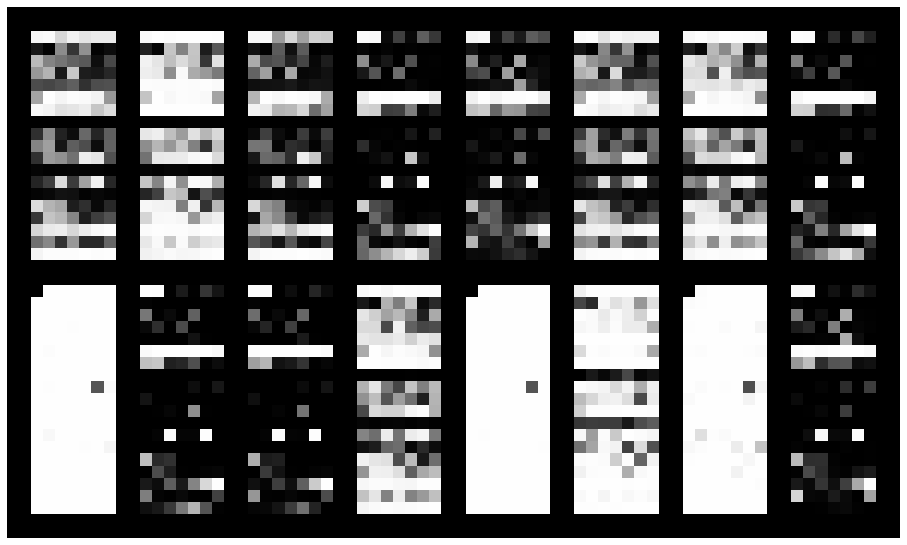

Epoch: [34/200], Batch Num: [0/54]
Discriminator Loss: 0.0456, Generator Loss: 6.9800
D(x): 0.9877, D(G(z)): 0.0063


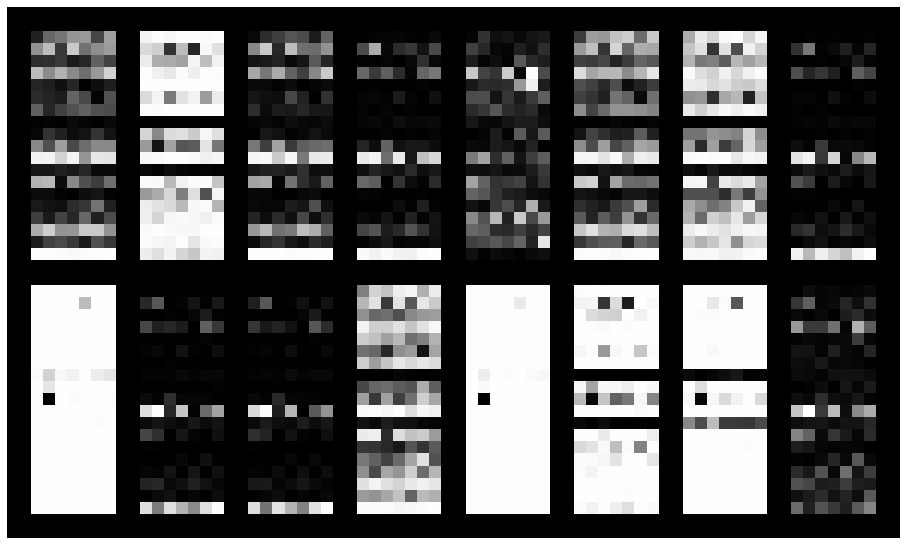

Epoch: [35/200], Batch Num: [0/54]
Discriminator Loss: 0.0434, Generator Loss: 6.8407
D(x): 0.9961, D(G(z)): 0.0142


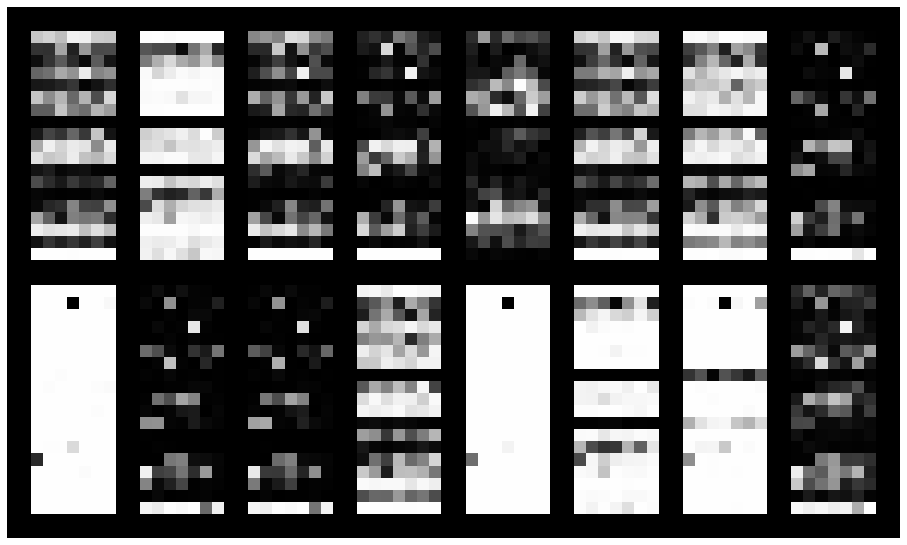

Epoch: [36/200], Batch Num: [0/54]
Discriminator Loss: 0.0389, Generator Loss: 6.9080
D(x): 0.9911, D(G(z)): 0.0072


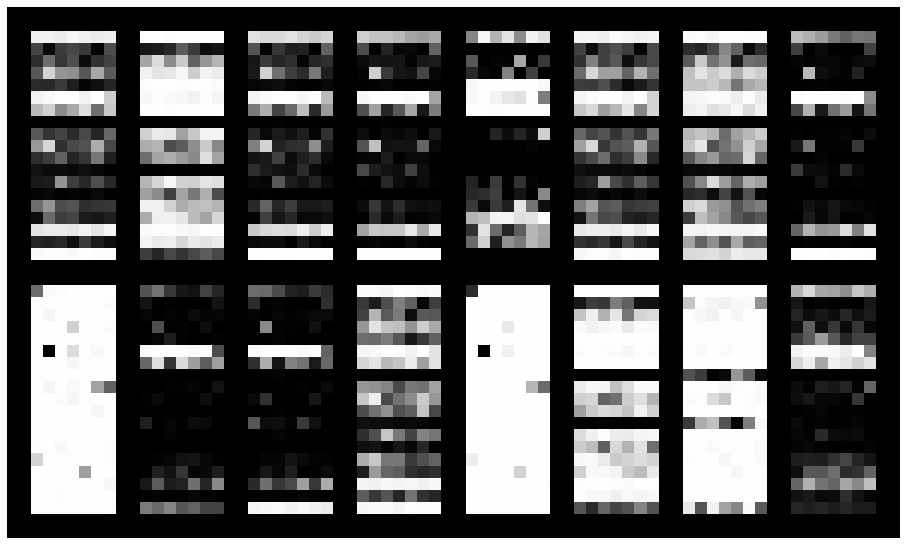

Epoch: [37/200], Batch Num: [0/54]
Discriminator Loss: 0.0421, Generator Loss: 6.7396
D(x): 0.9855, D(G(z)): 0.0056


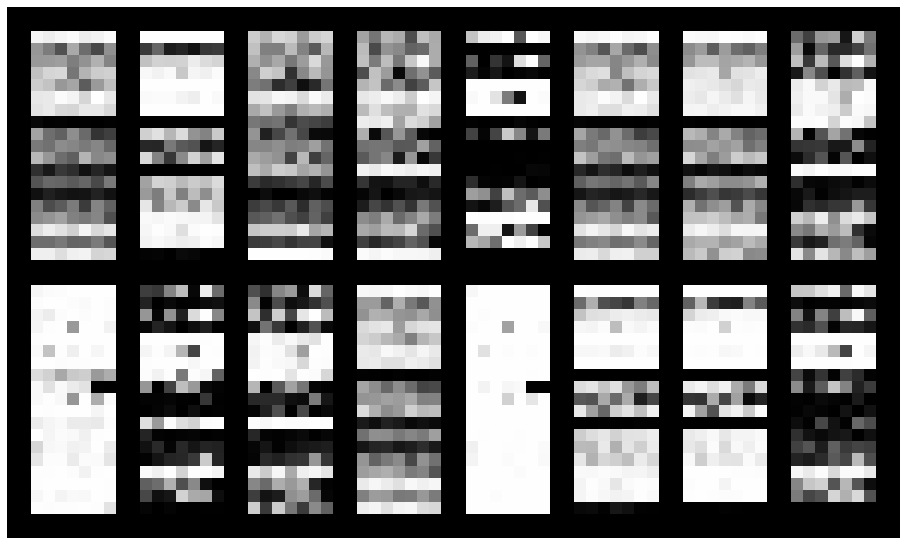

Epoch: [38/200], Batch Num: [0/54]
Discriminator Loss: 0.0406, Generator Loss: 6.0200
D(x): 0.9896, D(G(z)): 0.0137


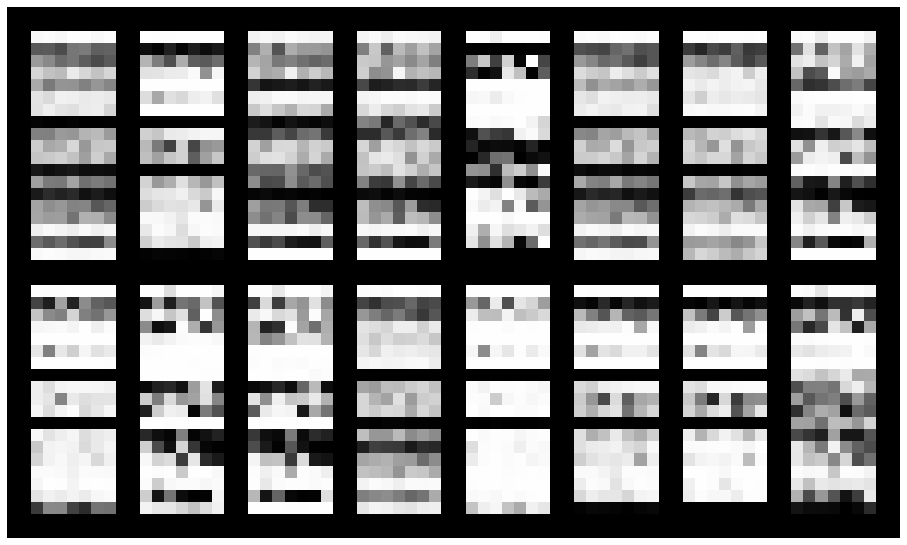

Epoch: [39/200], Batch Num: [0/54]
Discriminator Loss: 0.0637, Generator Loss: 4.9680
D(x): 0.9886, D(G(z)): 0.0272


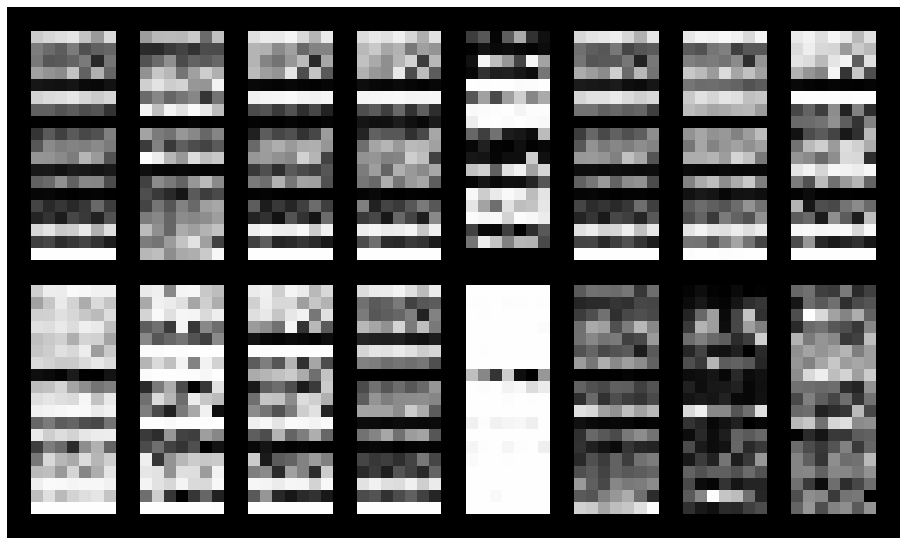

Epoch: [40/200], Batch Num: [0/54]
Discriminator Loss: 0.0690, Generator Loss: 6.4618
D(x): 0.9894, D(G(z)): 0.0269


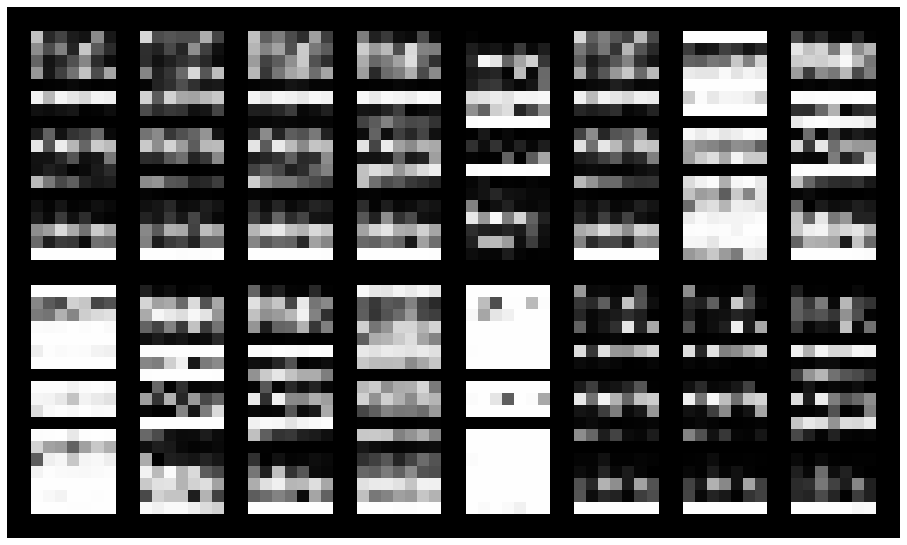

Epoch: [41/200], Batch Num: [0/54]
Discriminator Loss: 0.0119, Generator Loss: 6.8439
D(x): 0.9972, D(G(z)): 0.0075


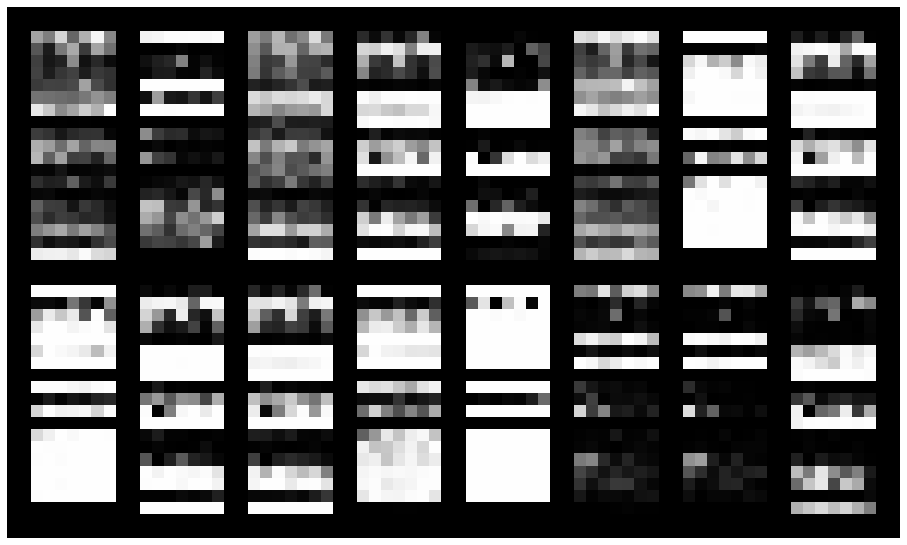

Epoch: [42/200], Batch Num: [0/54]
Discriminator Loss: 0.0284, Generator Loss: 6.3235
D(x): 0.9927, D(G(z)): 0.0113


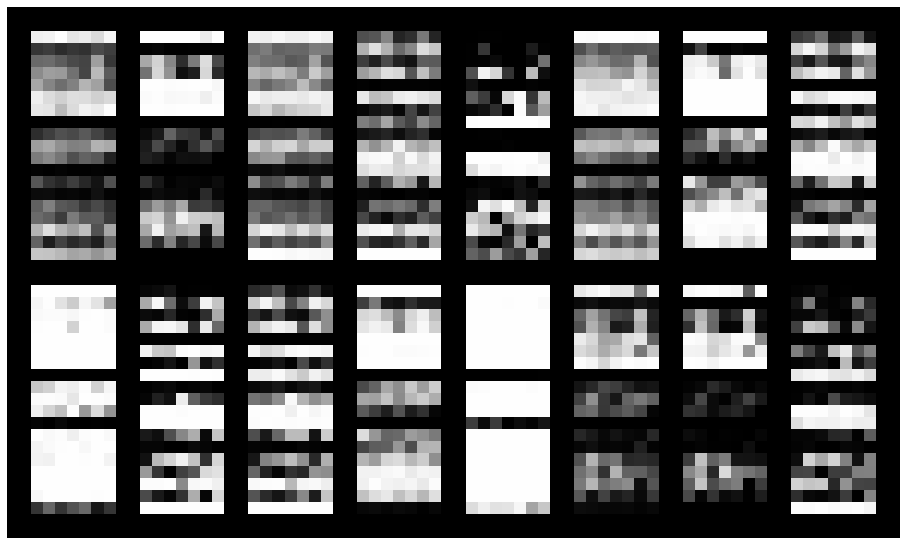

Epoch: [43/200], Batch Num: [0/54]
Discriminator Loss: 0.0450, Generator Loss: 5.5255
D(x): 0.9881, D(G(z)): 0.0146


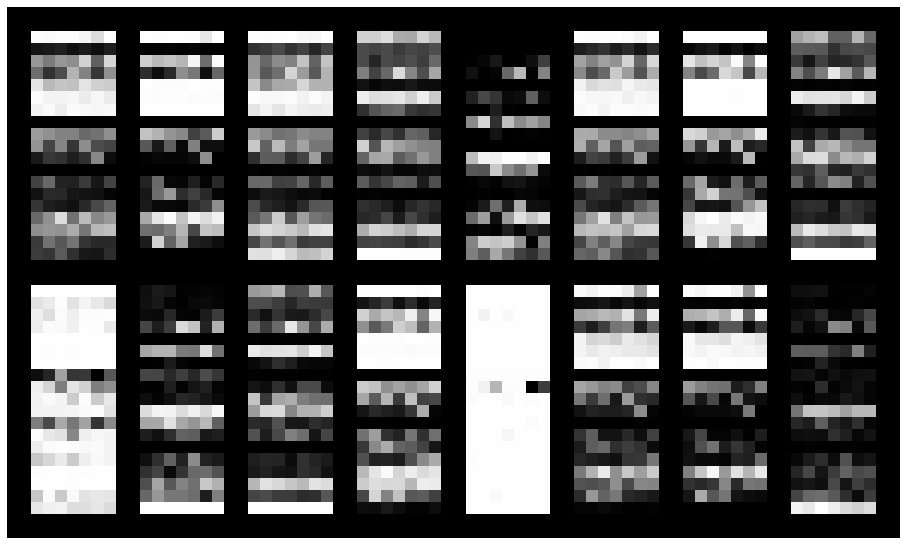

Epoch: [44/200], Batch Num: [0/54]
Discriminator Loss: 0.0307, Generator Loss: 5.3596
D(x): 0.9971, D(G(z)): 0.0175


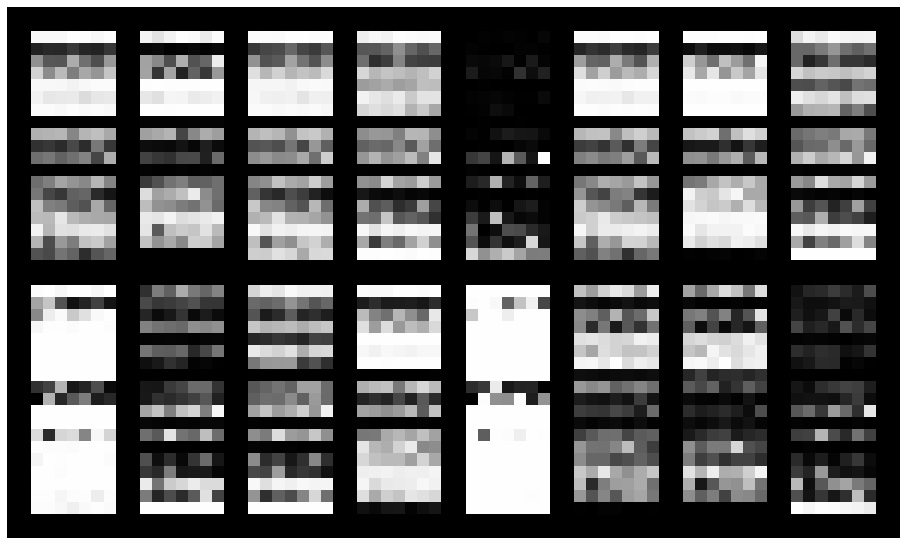

Epoch: [45/200], Batch Num: [0/54]
Discriminator Loss: 0.0438, Generator Loss: 6.2690
D(x): 0.9866, D(G(z)): 0.0099


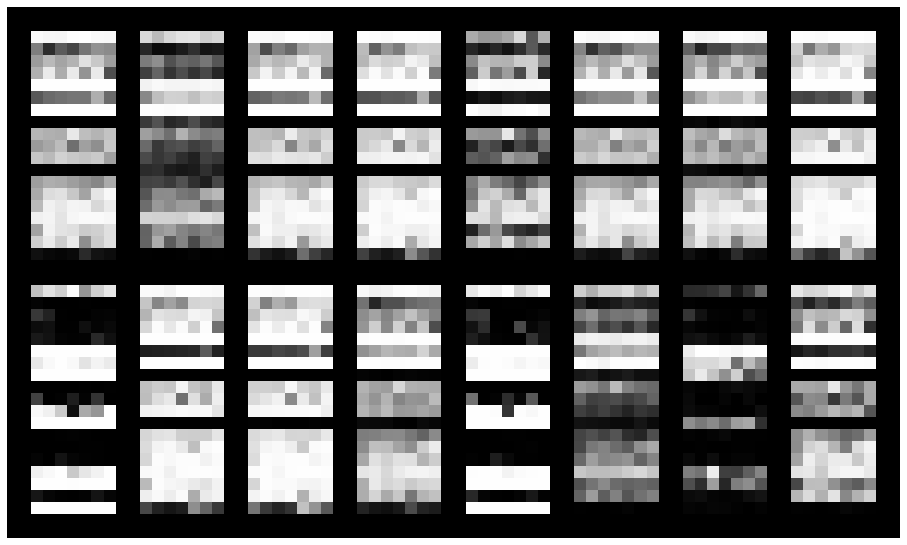

Epoch: [46/200], Batch Num: [0/54]
Discriminator Loss: 0.0492, Generator Loss: 5.7778
D(x): 0.9882, D(G(z)): 0.0101


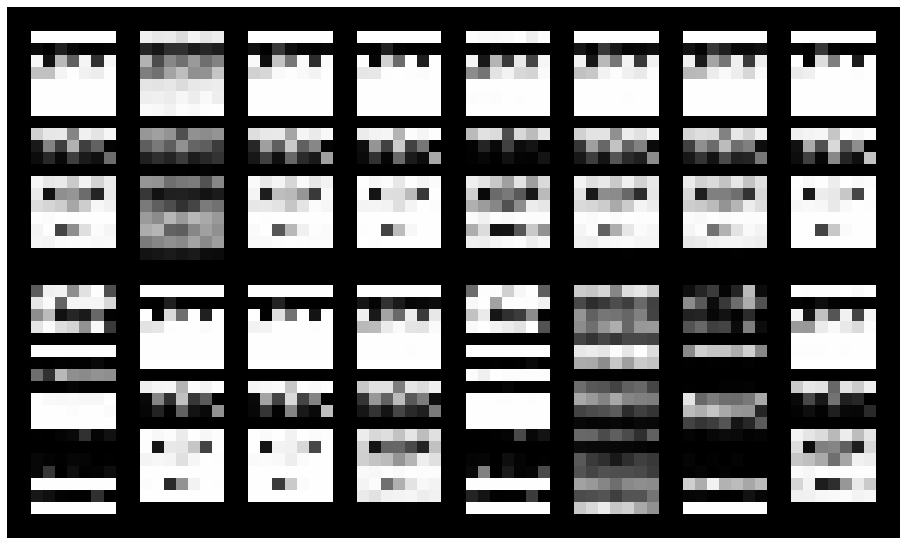

Epoch: [47/200], Batch Num: [0/54]
Discriminator Loss: 0.0468, Generator Loss: 6.2933
D(x): 0.9903, D(G(z)): 0.0084


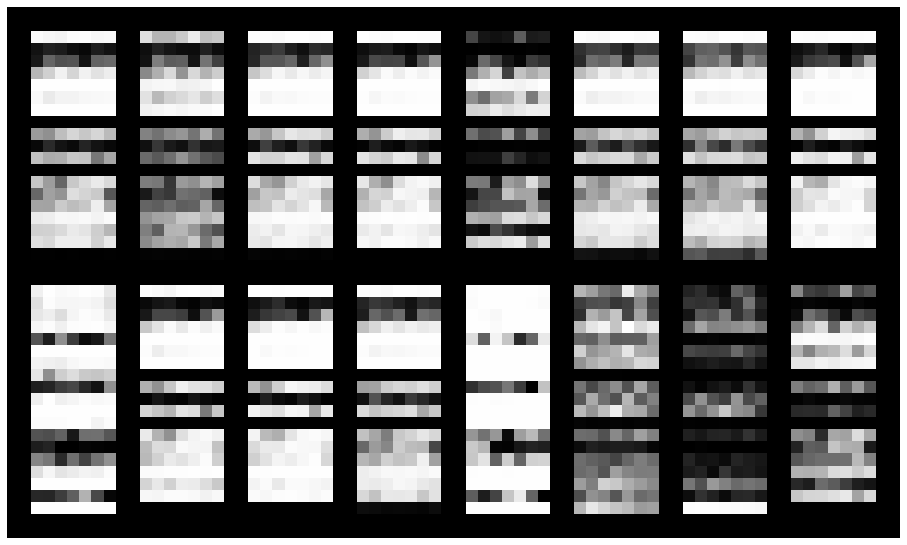

Epoch: [48/200], Batch Num: [0/54]
Discriminator Loss: 0.0878, Generator Loss: 5.4419
D(x): 0.9801, D(G(z)): 0.0115


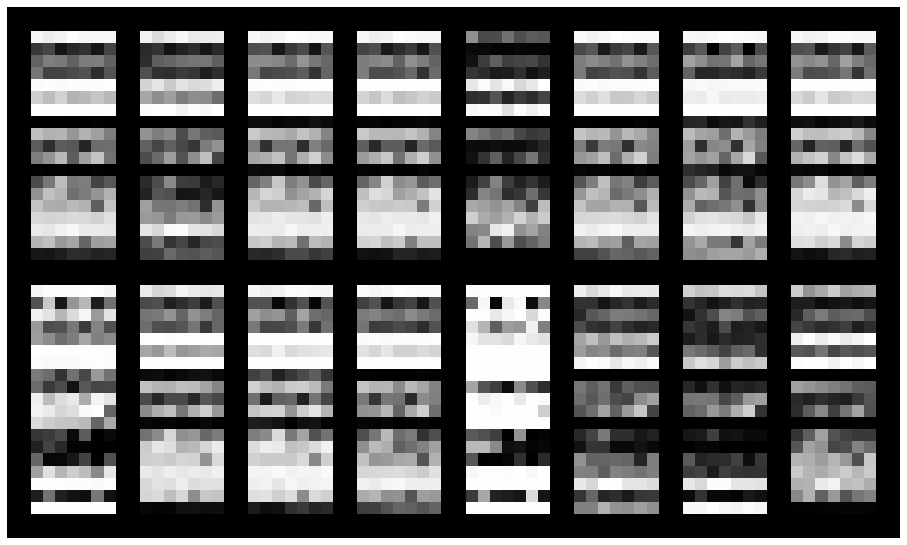

Epoch: [49/200], Batch Num: [0/54]
Discriminator Loss: 0.0251, Generator Loss: 6.0560
D(x): 0.9933, D(G(z)): 0.0074


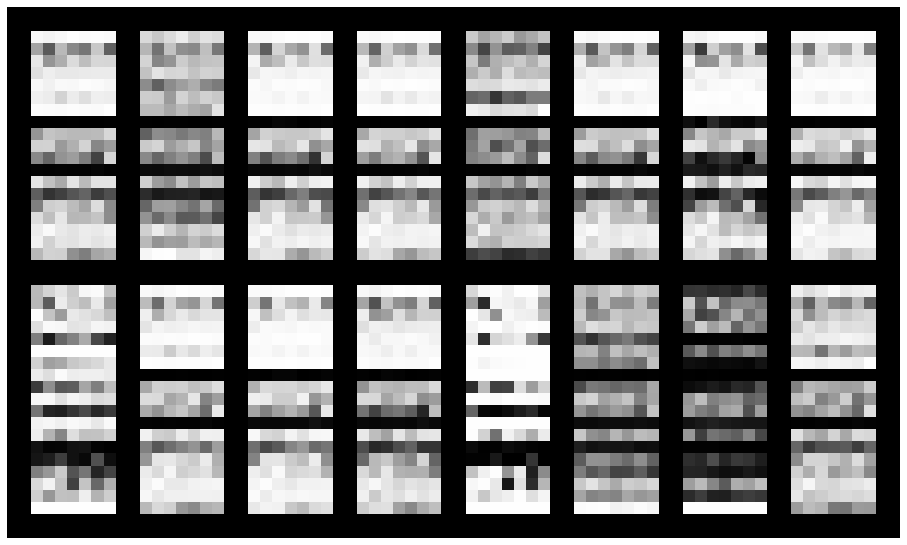

Epoch: [50/200], Batch Num: [0/54]
Discriminator Loss: 0.0617, Generator Loss: 7.3179
D(x): 0.9837, D(G(z)): 0.0127


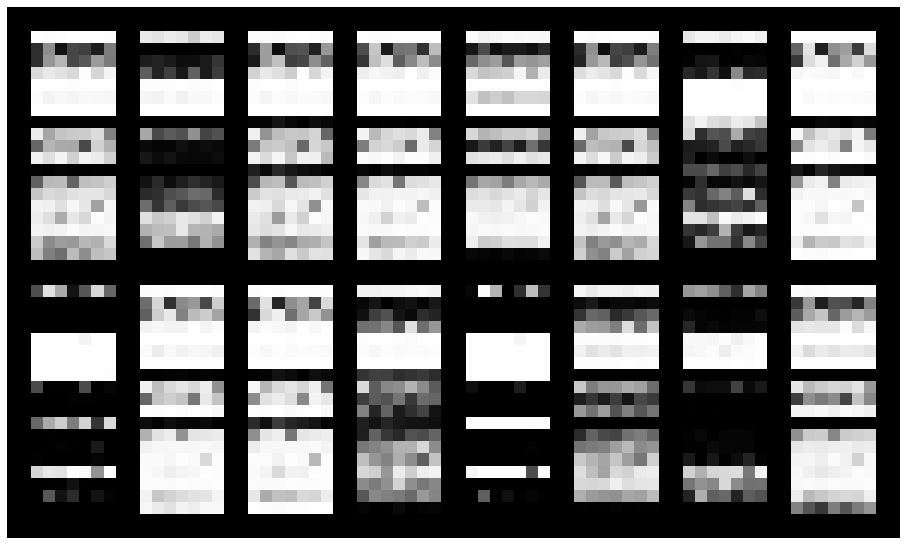

Epoch: [51/200], Batch Num: [0/54]
Discriminator Loss: 0.0746, Generator Loss: 5.6287
D(x): 0.9816, D(G(z)): 0.0074


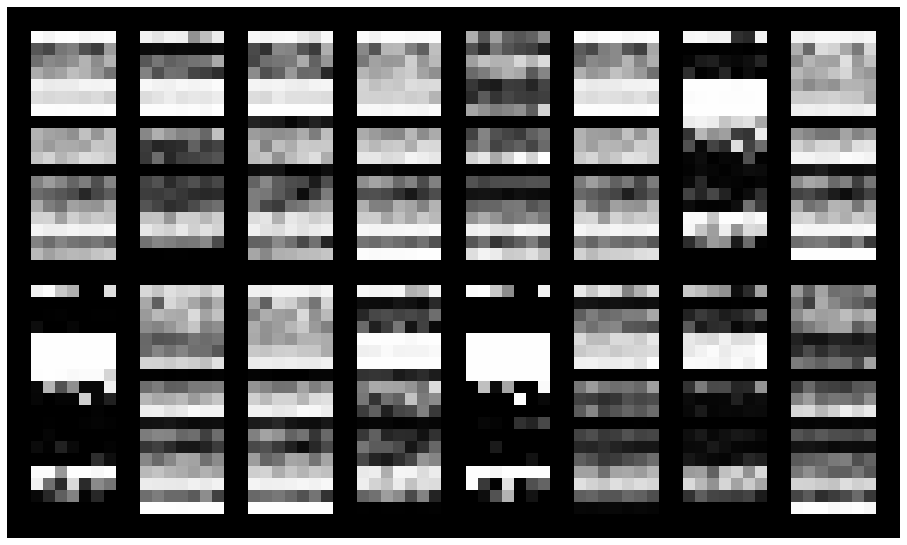

Epoch: [52/200], Batch Num: [0/54]
Discriminator Loss: 0.0442, Generator Loss: 5.9394
D(x): 0.9906, D(G(z)): 0.0098


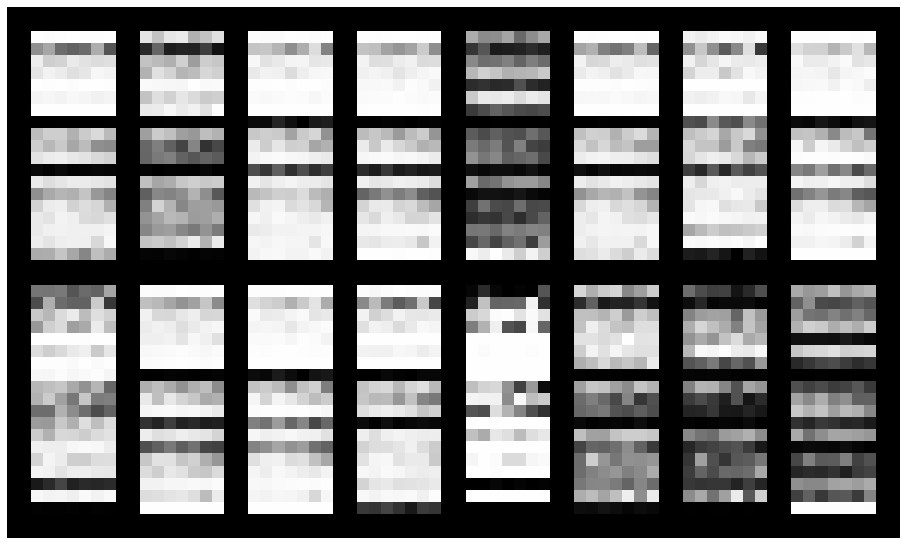

Epoch: [53/200], Batch Num: [0/54]
Discriminator Loss: 0.0714, Generator Loss: 5.8708
D(x): 0.9886, D(G(z)): 0.0245


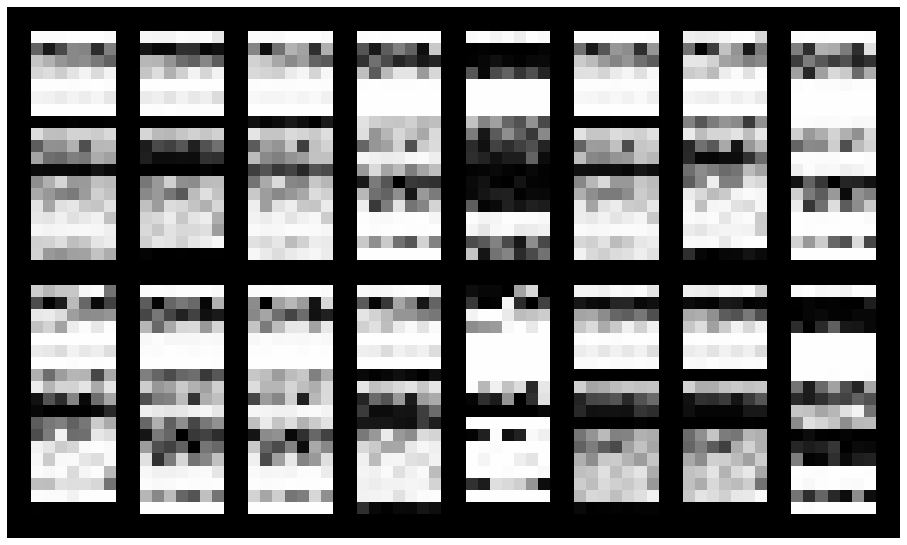

Epoch: [54/200], Batch Num: [0/54]
Discriminator Loss: 0.0531, Generator Loss: 6.2530
D(x): 0.9882, D(G(z)): 0.0075


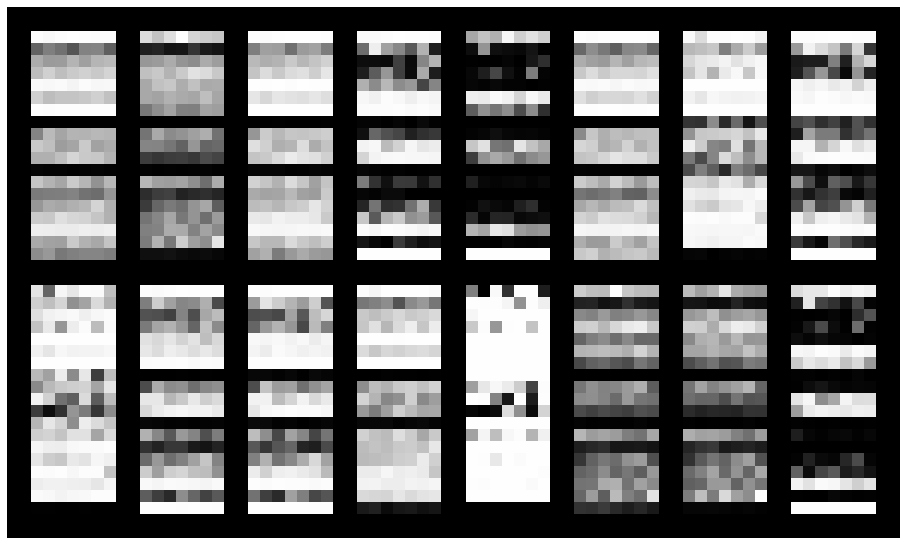

Epoch: [55/200], Batch Num: [0/54]
Discriminator Loss: 0.0642, Generator Loss: 5.4001
D(x): 0.9834, D(G(z)): 0.0112


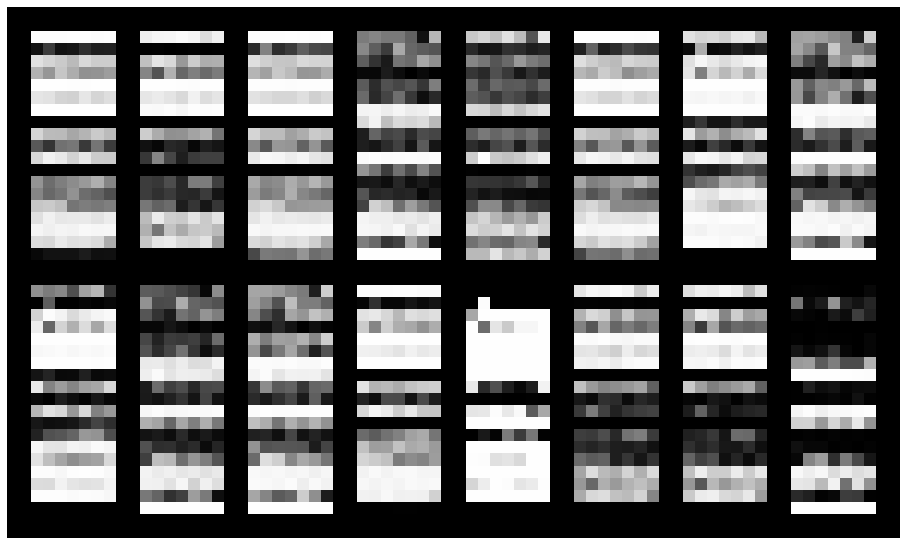

Epoch: [56/200], Batch Num: [0/54]
Discriminator Loss: 0.0268, Generator Loss: 5.9881
D(x): 0.9939, D(G(z)): 0.0088


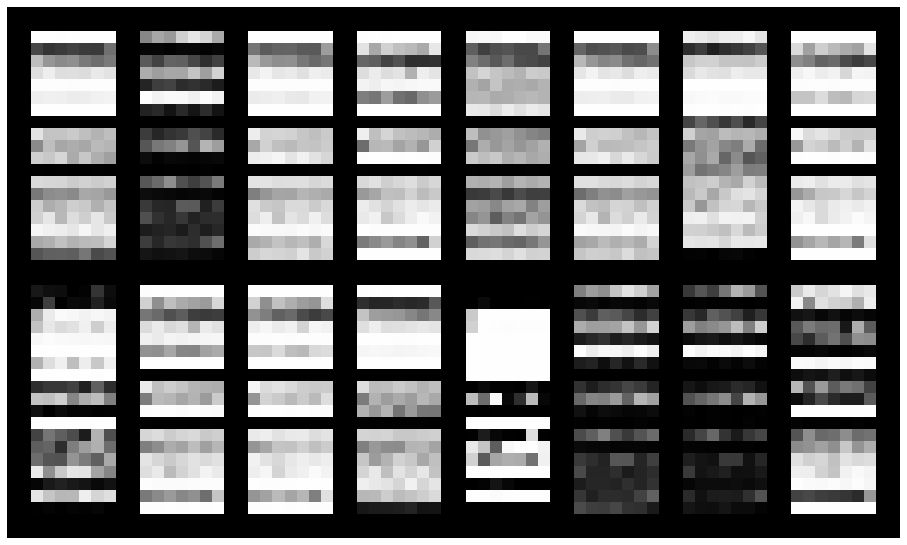

Epoch: [57/200], Batch Num: [0/54]
Discriminator Loss: 0.0455, Generator Loss: 5.8248
D(x): 0.9962, D(G(z)): 0.0245


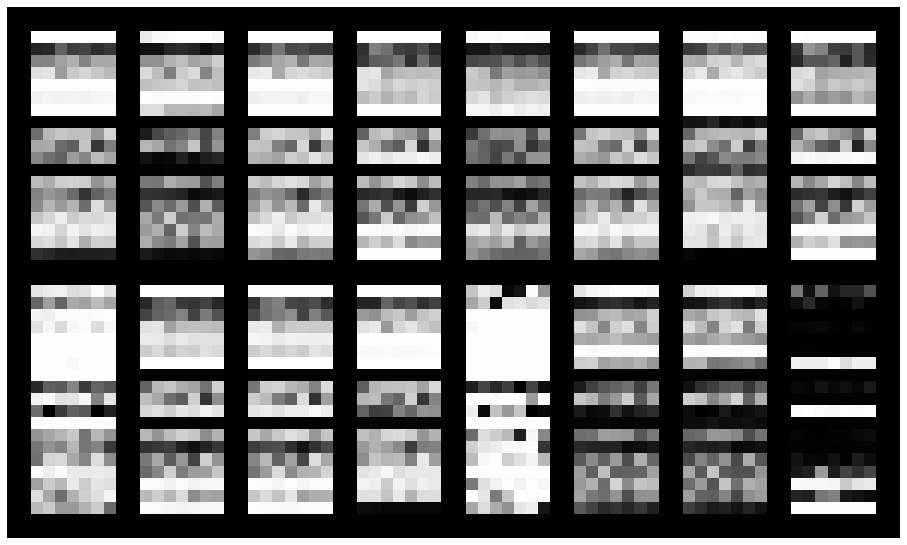

Epoch: [58/200], Batch Num: [0/54]
Discriminator Loss: 0.0258, Generator Loss: 6.0730
D(x): 0.9965, D(G(z)): 0.0085


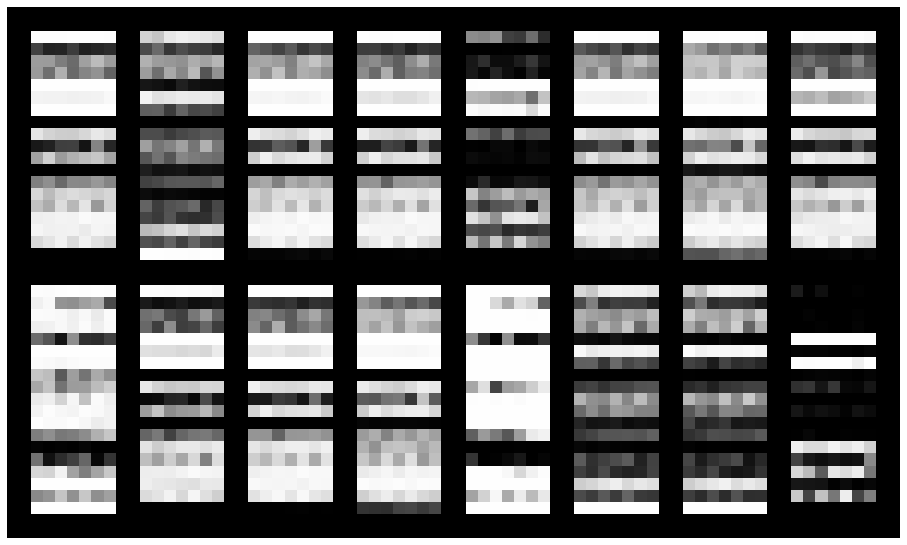

Epoch: [59/200], Batch Num: [0/54]
Discriminator Loss: 0.0731, Generator Loss: 6.1270
D(x): 0.9860, D(G(z)): 0.0088


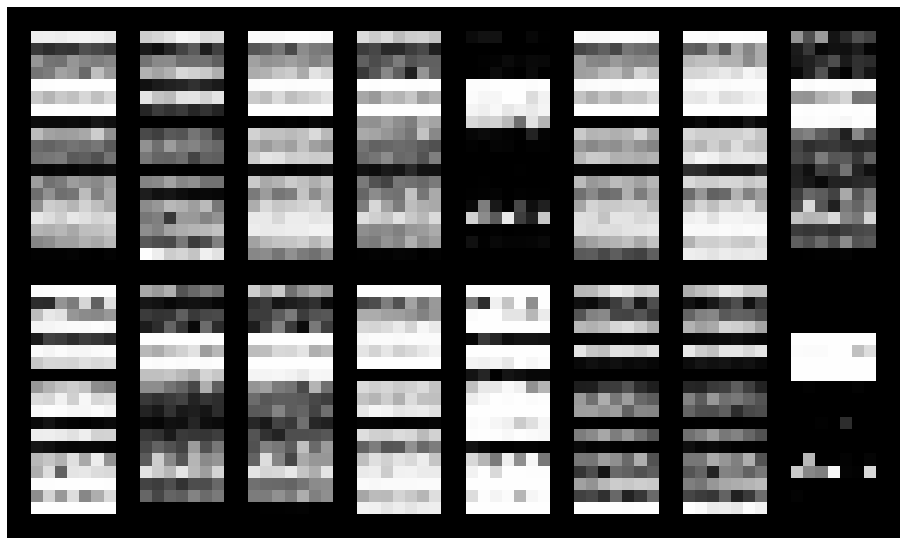

Epoch: [60/200], Batch Num: [0/54]
Discriminator Loss: 0.0347, Generator Loss: 5.5955
D(x): 0.9951, D(G(z)): 0.0169


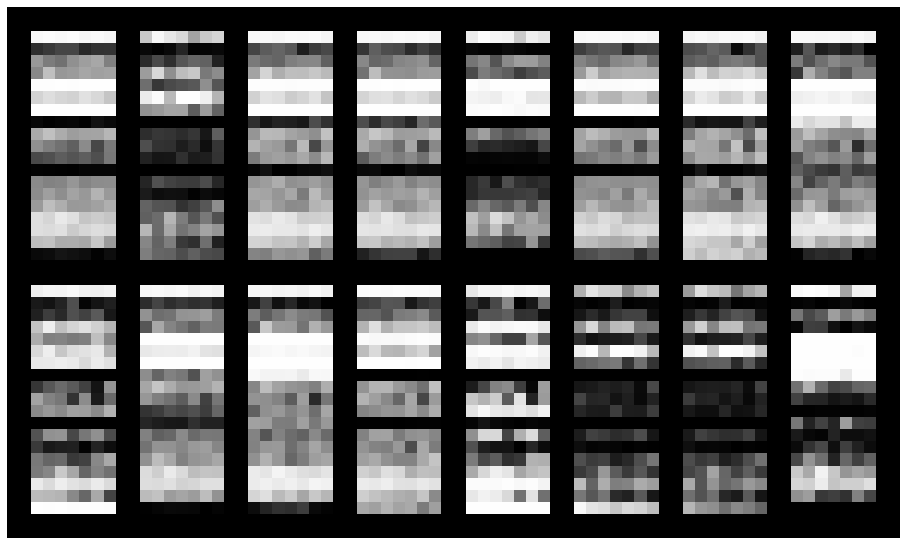

Epoch: [61/200], Batch Num: [0/54]
Discriminator Loss: 0.0426, Generator Loss: 5.8412
D(x): 0.9909, D(G(z)): 0.0100


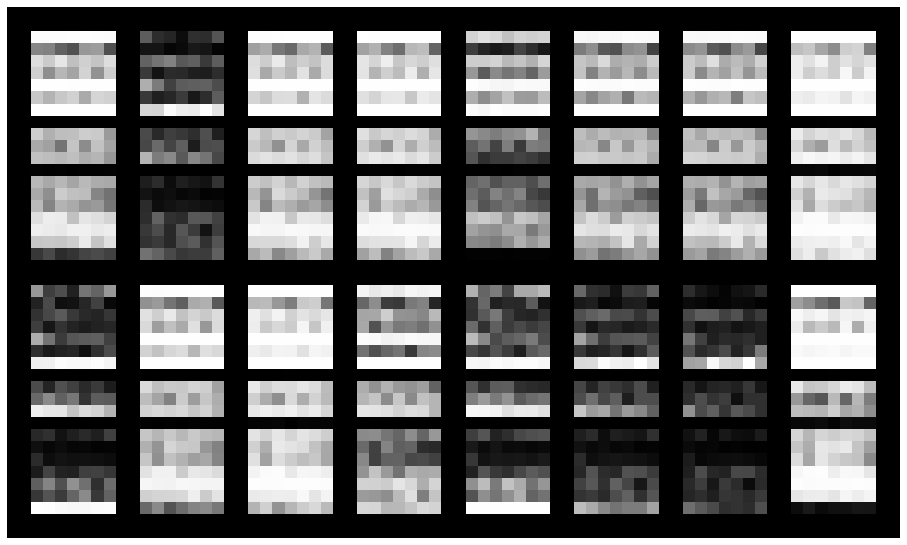

Epoch: [62/200], Batch Num: [0/54]
Discriminator Loss: 0.0166, Generator Loss: 7.1270
D(x): 0.9926, D(G(z)): 0.0035


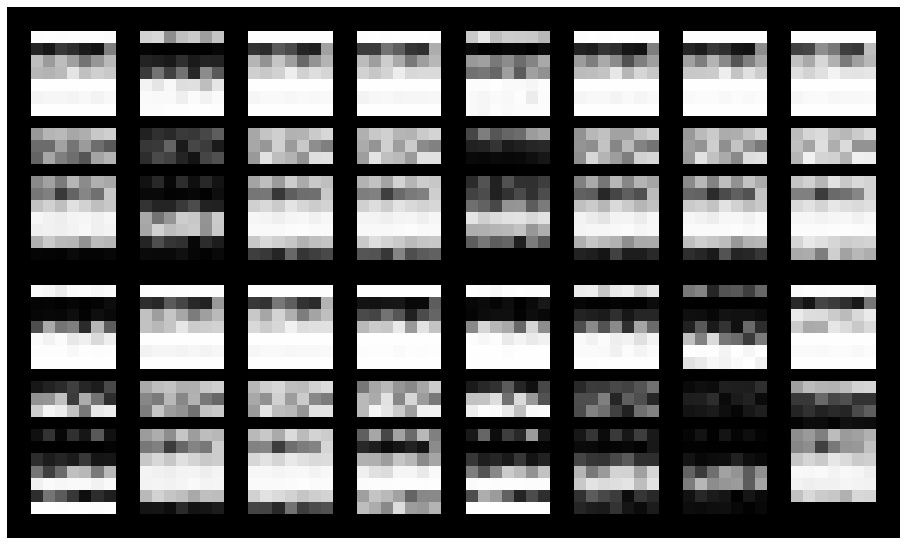

Epoch: [63/200], Batch Num: [0/54]
Discriminator Loss: 0.0518, Generator Loss: 6.0231
D(x): 0.9876, D(G(z)): 0.0045


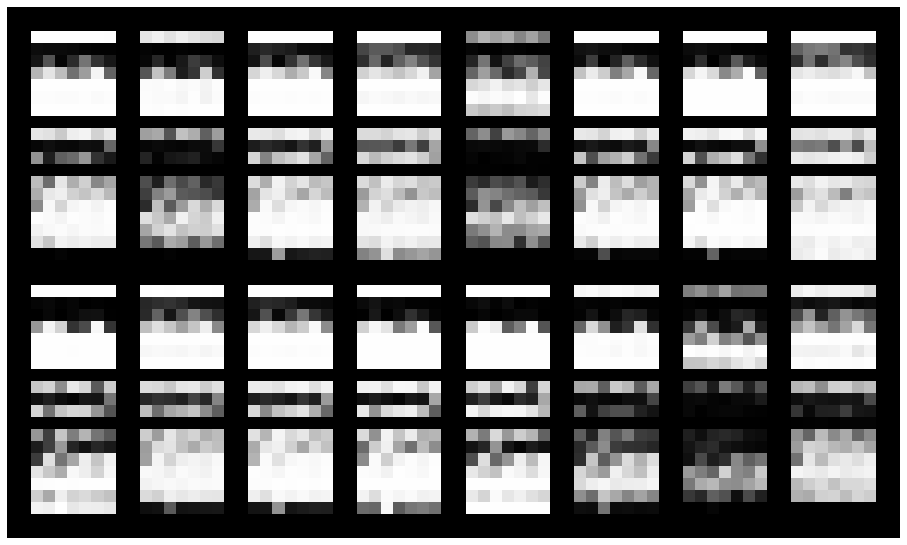

Epoch: [64/200], Batch Num: [0/54]
Discriminator Loss: 0.0106, Generator Loss: 6.5924
D(x): 0.9989, D(G(z)): 0.0063


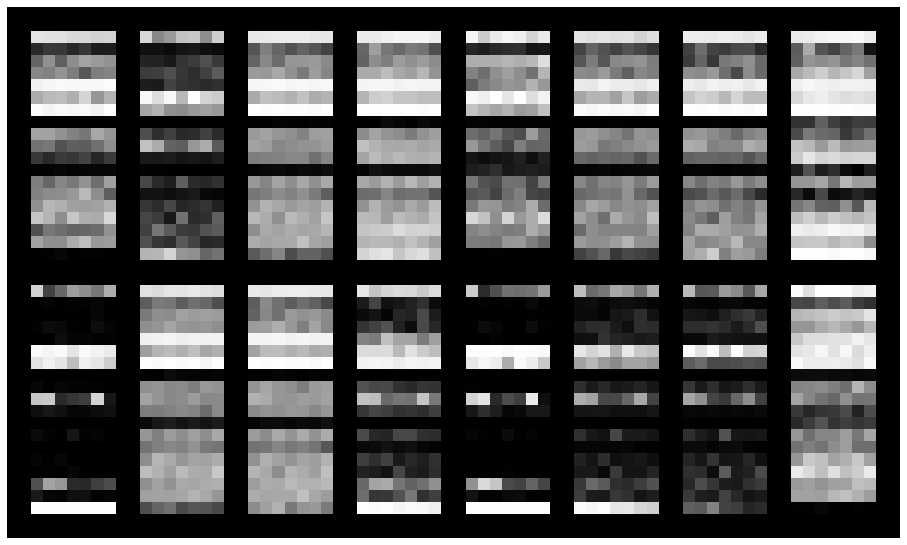

Epoch: [65/200], Batch Num: [0/54]
Discriminator Loss: 0.0394, Generator Loss: 6.3434
D(x): 0.9951, D(G(z)): 0.0096


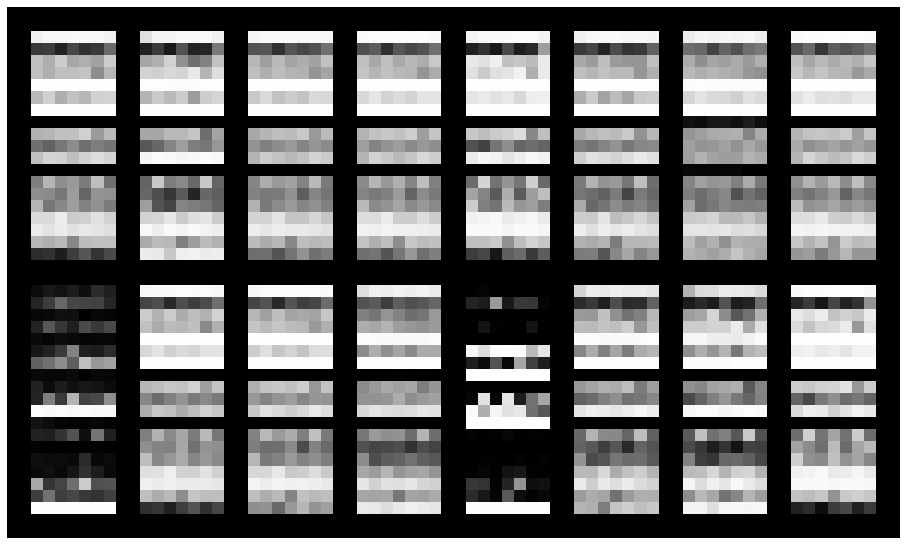

Epoch: [66/200], Batch Num: [0/54]
Discriminator Loss: 0.0262, Generator Loss: 6.0731
D(x): 0.9951, D(G(z)): 0.0085


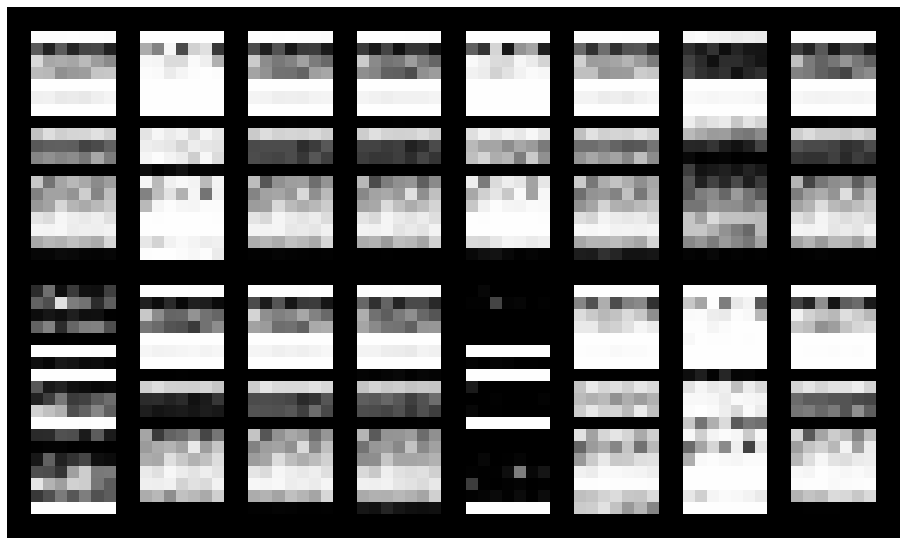

Epoch: [67/200], Batch Num: [0/54]
Discriminator Loss: 0.0600, Generator Loss: 5.2846
D(x): 0.9909, D(G(z)): 0.0125


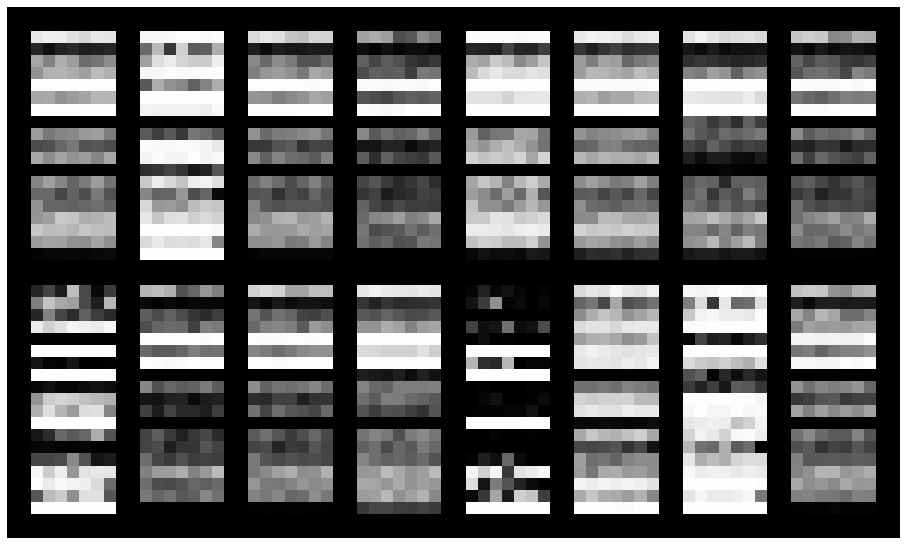

Epoch: [68/200], Batch Num: [0/54]
Discriminator Loss: 0.0283, Generator Loss: 5.9139
D(x): 0.9955, D(G(z)): 0.0096


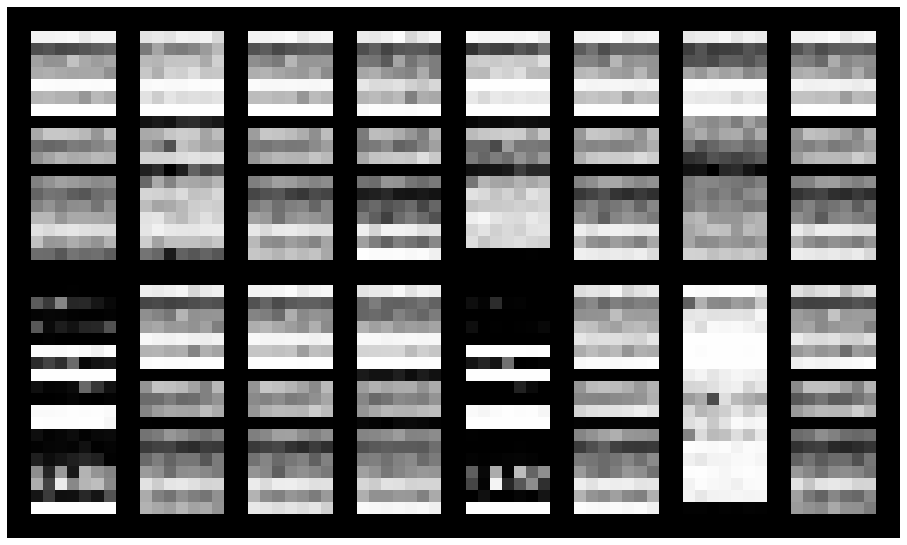

Epoch: [69/200], Batch Num: [0/54]
Discriminator Loss: 0.0567, Generator Loss: 6.0579
D(x): 0.9893, D(G(z)): 0.0112


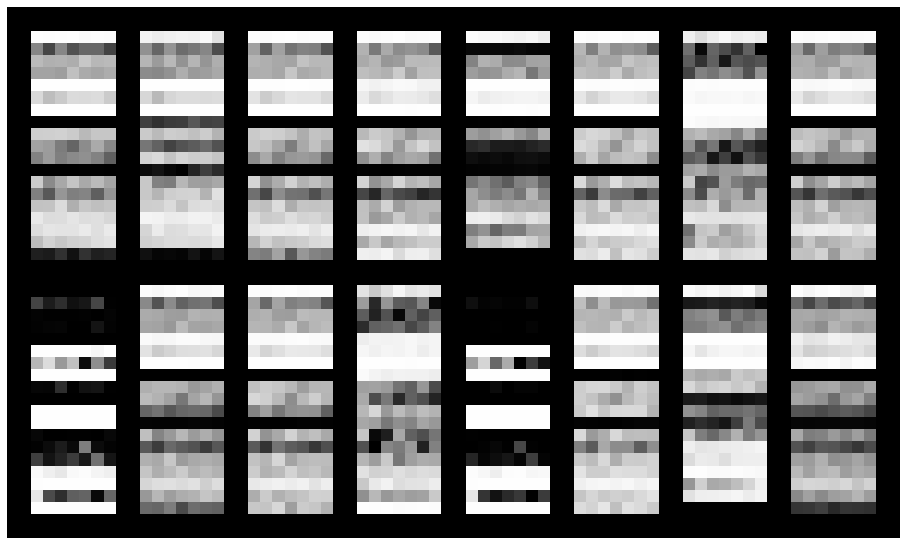

Epoch: [70/200], Batch Num: [0/54]
Discriminator Loss: 0.0844, Generator Loss: 5.4459
D(x): 0.9812, D(G(z)): 0.0103


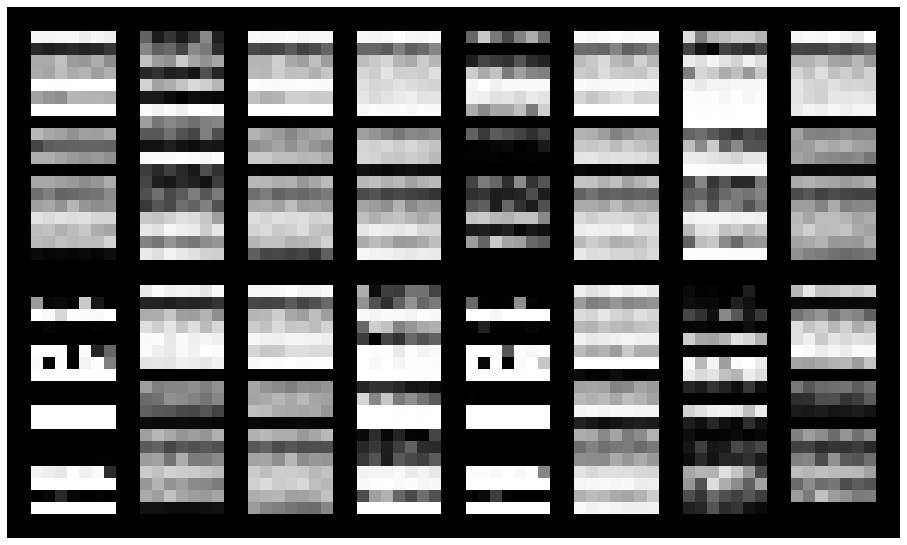

Epoch: [71/200], Batch Num: [0/54]
Discriminator Loss: 0.0753, Generator Loss: 5.6724
D(x): 0.9821, D(G(z)): 0.0128


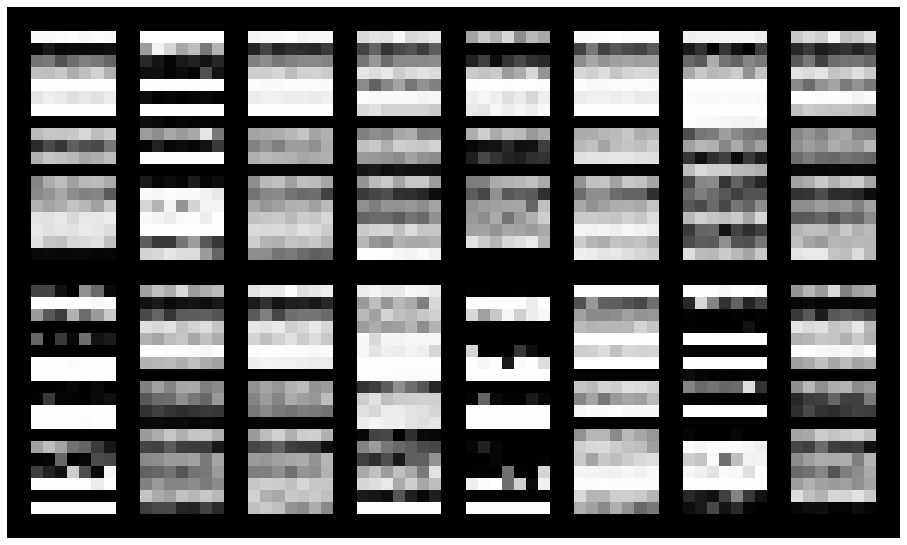

Epoch: [72/200], Batch Num: [0/54]
Discriminator Loss: 0.0263, Generator Loss: 6.3382
D(x): 0.9938, D(G(z)): 0.0090


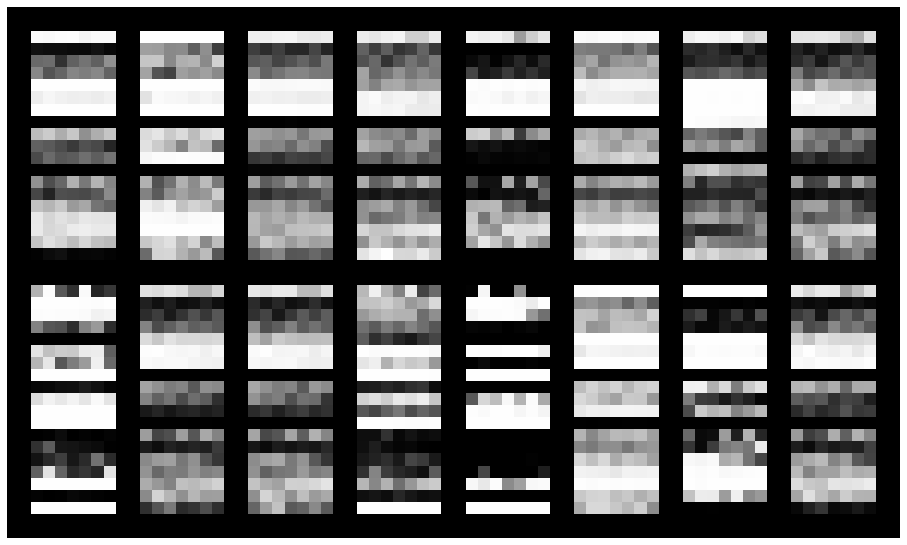

Epoch: [73/200], Batch Num: [0/54]
Discriminator Loss: 0.0257, Generator Loss: 5.6262
D(x): 0.9931, D(G(z)): 0.0095


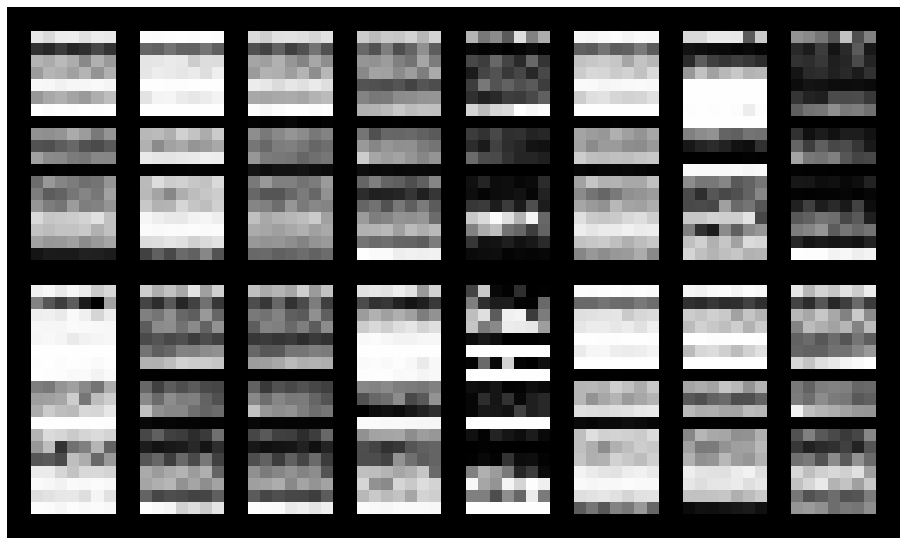

Epoch: [74/200], Batch Num: [0/54]
Discriminator Loss: 0.0409, Generator Loss: 5.6646
D(x): 0.9900, D(G(z)): 0.0100


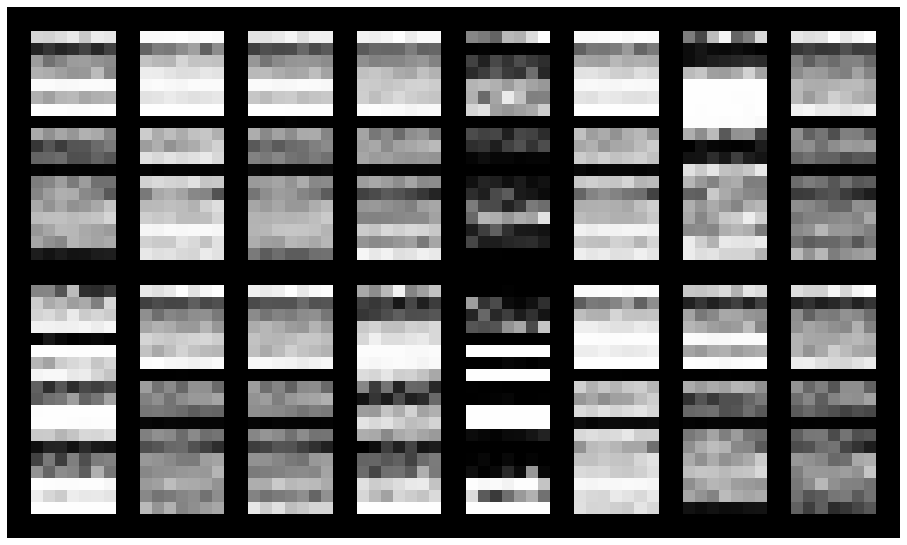

Epoch: [75/200], Batch Num: [0/54]
Discriminator Loss: 0.0548, Generator Loss: 5.8231
D(x): 0.9926, D(G(z)): 0.0085


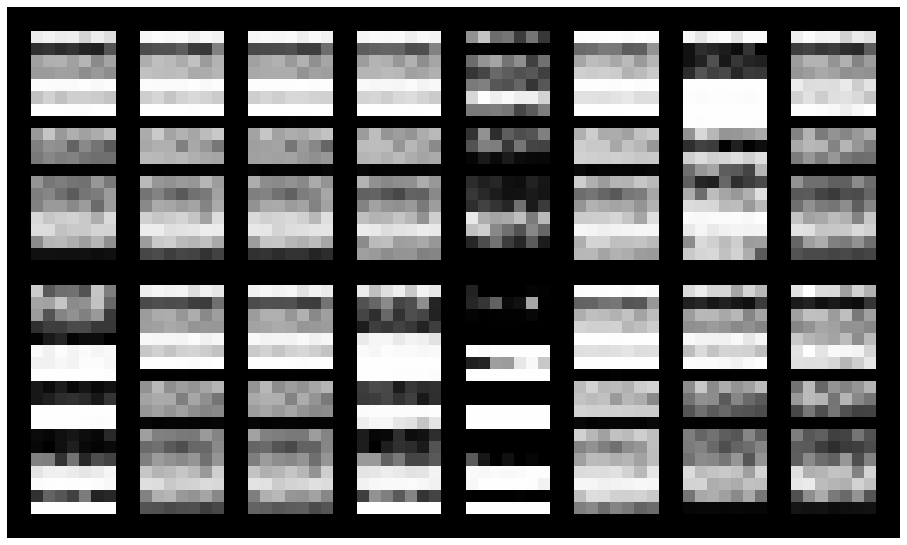

Epoch: [76/200], Batch Num: [0/54]
Discriminator Loss: 0.0614, Generator Loss: 6.0738
D(x): 0.9883, D(G(z)): 0.0066


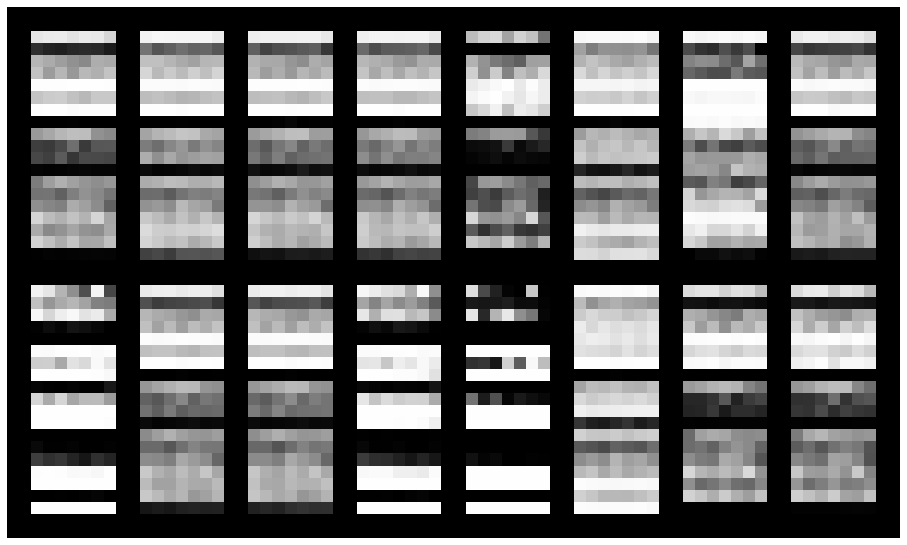

Epoch: [77/200], Batch Num: [0/54]
Discriminator Loss: 0.0367, Generator Loss: 6.0170
D(x): 0.9928, D(G(z)): 0.0050


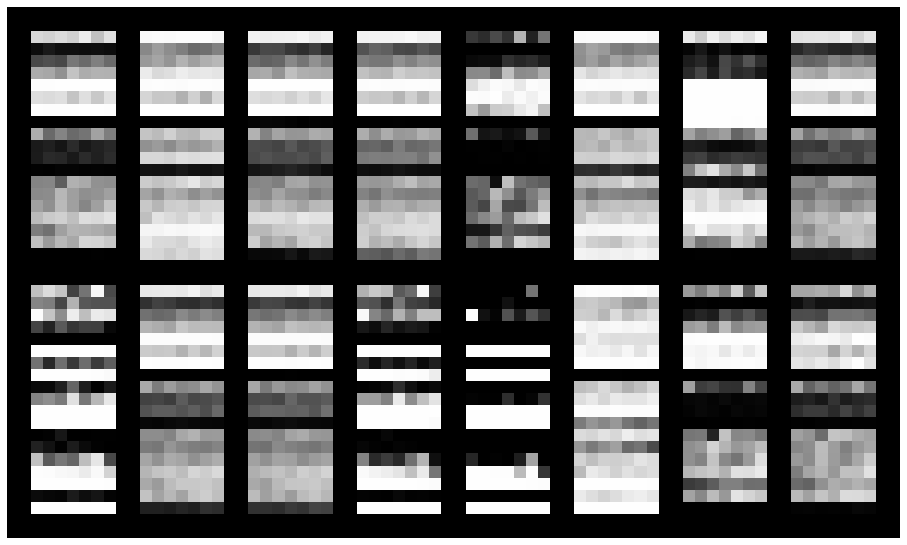

Epoch: [78/200], Batch Num: [0/54]
Discriminator Loss: 0.0180, Generator Loss: 5.7753
D(x): 0.9962, D(G(z)): 0.0074


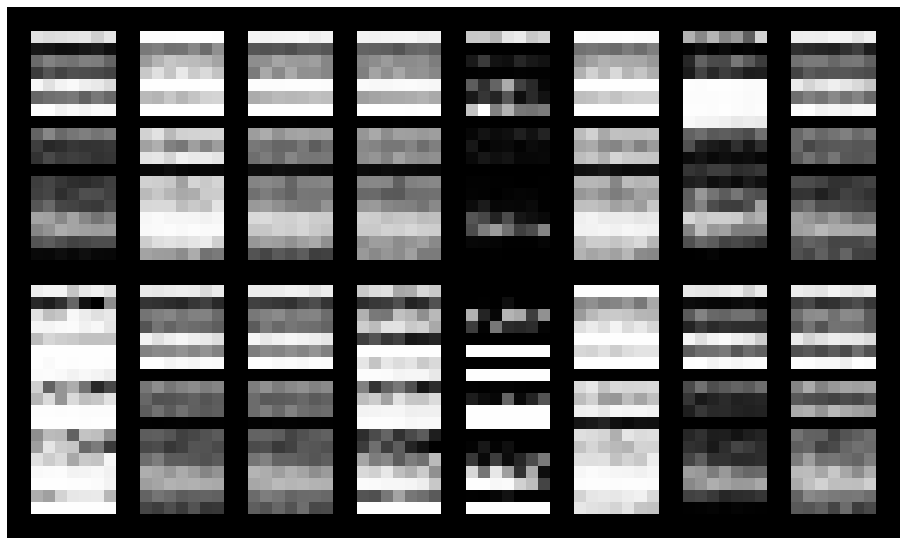

Epoch: [79/200], Batch Num: [0/54]
Discriminator Loss: 0.0434, Generator Loss: 5.8150
D(x): 0.9895, D(G(z)): 0.0085


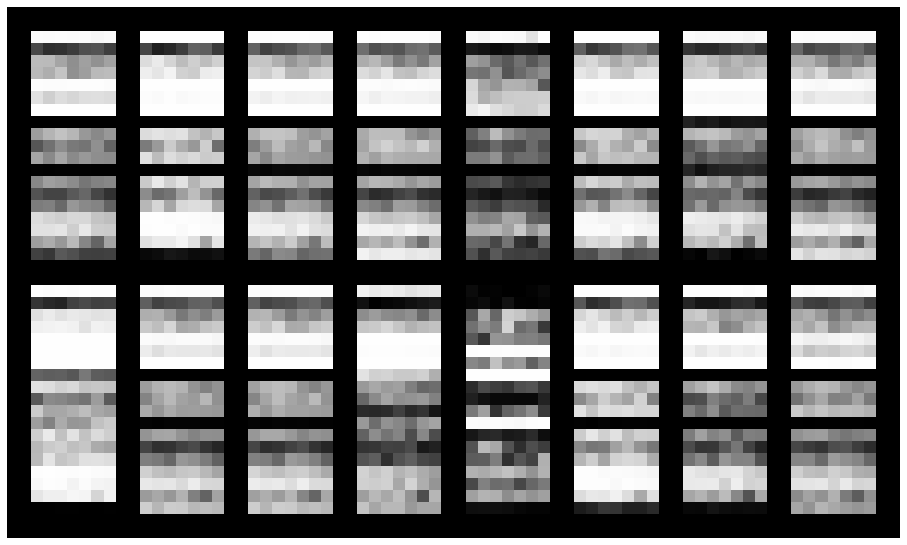

Epoch: [80/200], Batch Num: [0/54]
Discriminator Loss: 0.0431, Generator Loss: 5.6582
D(x): 0.9931, D(G(z)): 0.0087


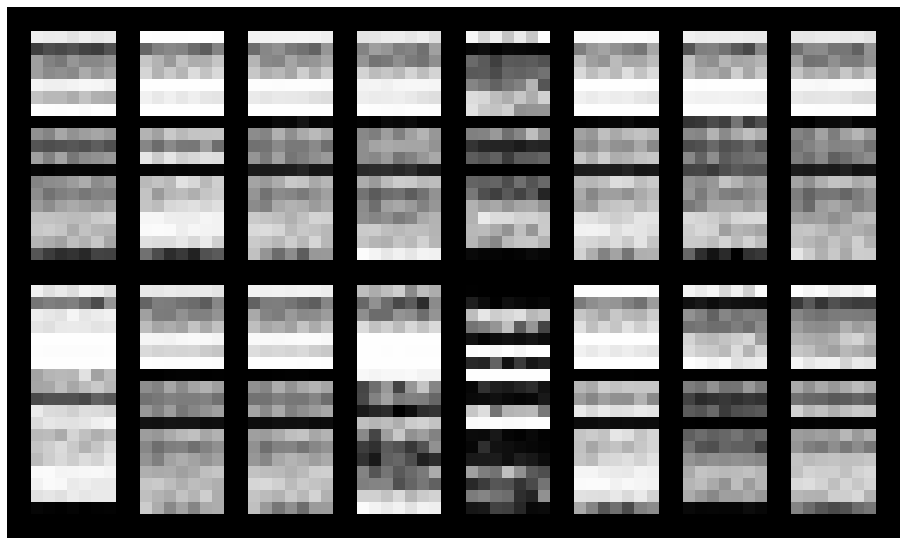

Epoch: [81/200], Batch Num: [0/54]
Discriminator Loss: 0.0615, Generator Loss: 5.8610
D(x): 0.9895, D(G(z)): 0.0074


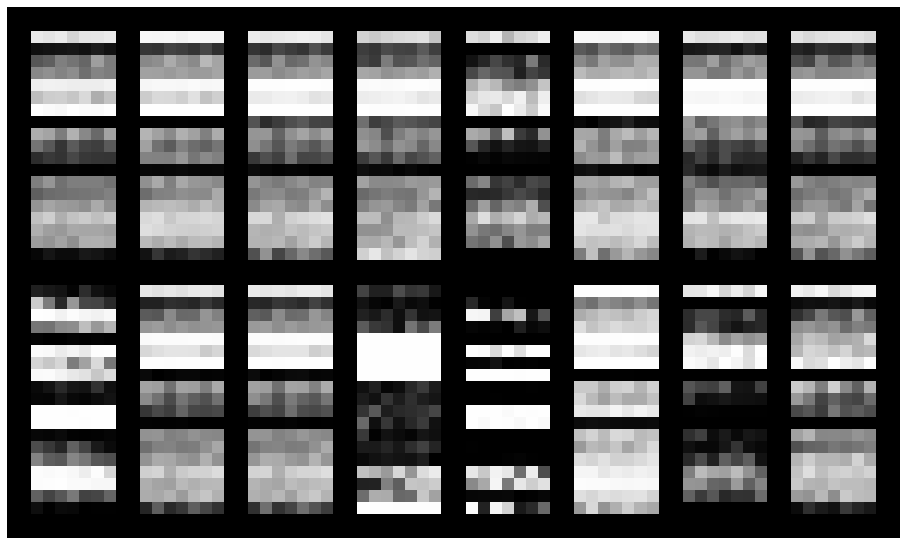

Epoch: [82/200], Batch Num: [0/54]
Discriminator Loss: 0.0381, Generator Loss: 5.3918
D(x): 0.9927, D(G(z)): 0.0079


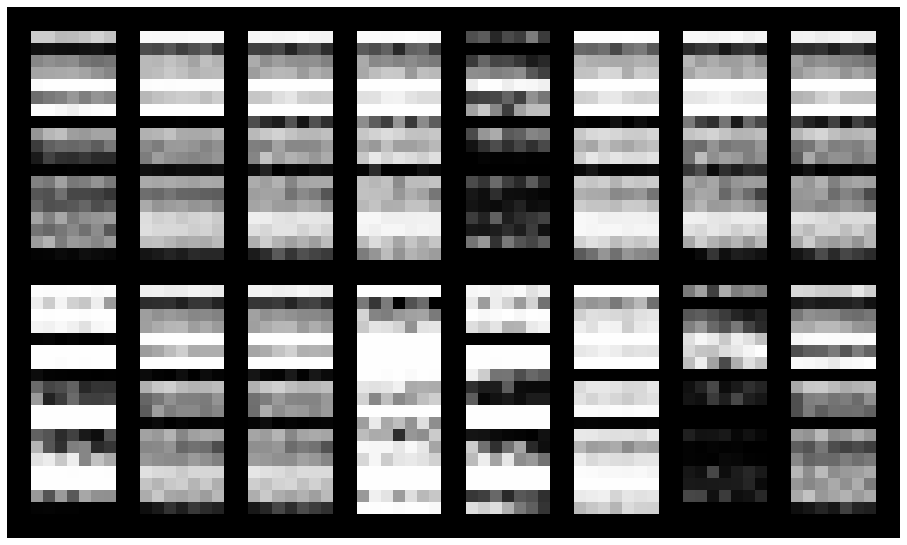

Epoch: [83/200], Batch Num: [0/54]
Discriminator Loss: 0.0522, Generator Loss: 6.0857
D(x): 0.9901, D(G(z)): 0.0075


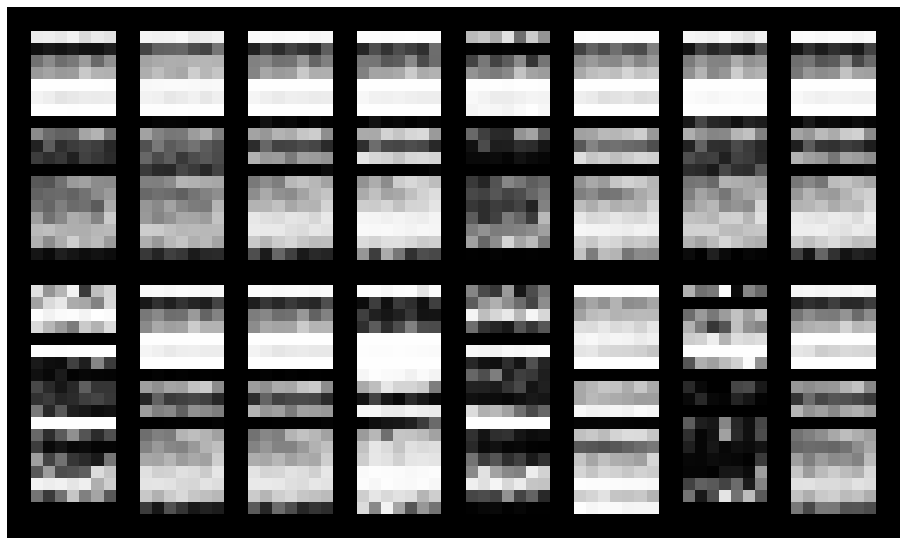

Epoch: [84/200], Batch Num: [0/54]
Discriminator Loss: 0.0209, Generator Loss: 6.2167
D(x): 0.9968, D(G(z)): 0.0069


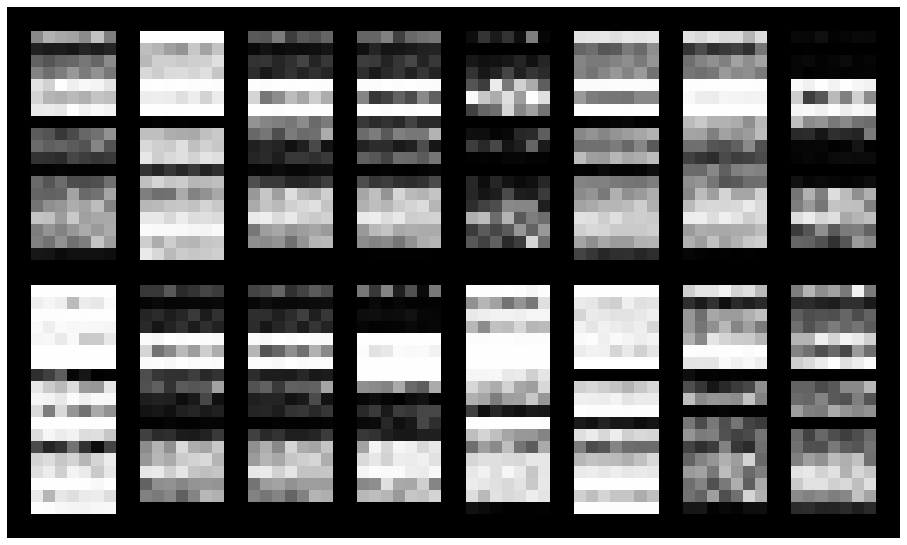

Epoch: [85/200], Batch Num: [0/54]
Discriminator Loss: 0.0445, Generator Loss: 6.7353
D(x): 0.9906, D(G(z)): 0.0046


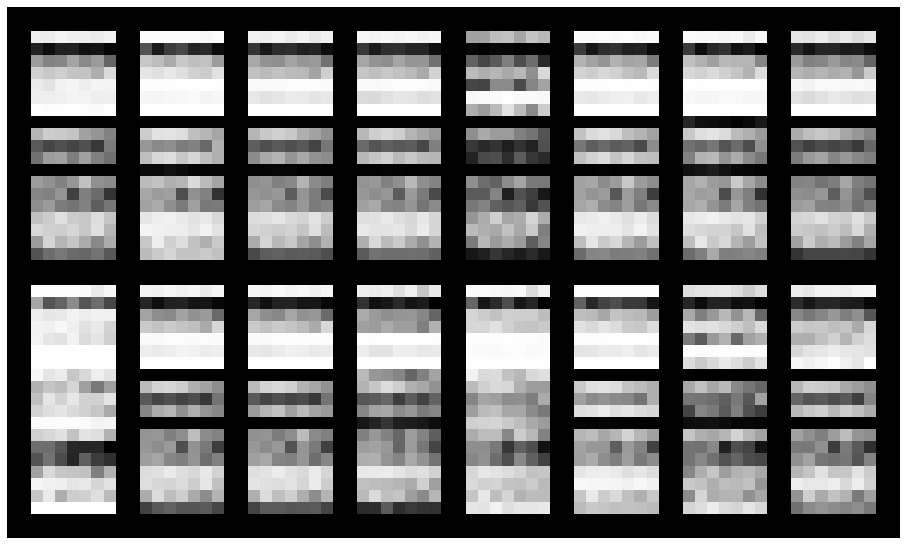

Epoch: [86/200], Batch Num: [0/54]
Discriminator Loss: 0.0609, Generator Loss: 5.4585
D(x): 0.9887, D(G(z)): 0.0062


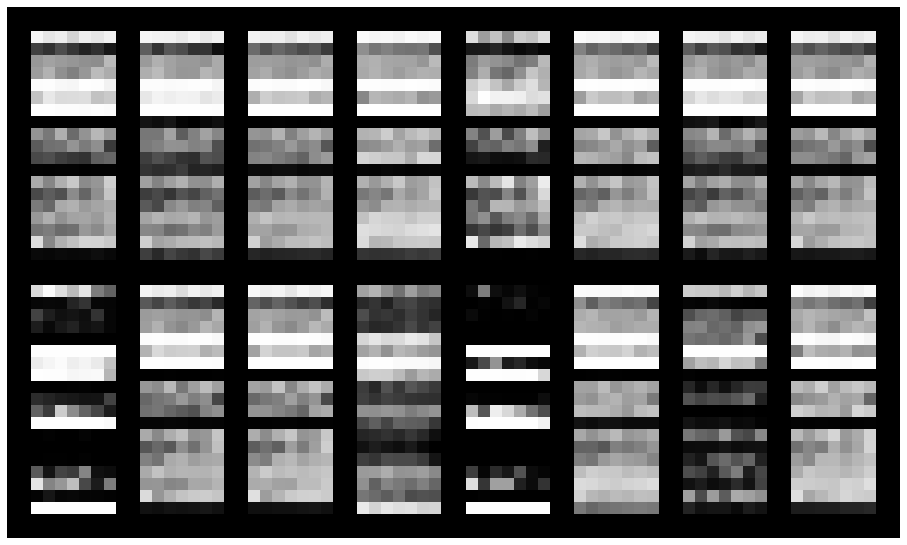

Epoch: [87/200], Batch Num: [0/54]
Discriminator Loss: 0.0167, Generator Loss: 5.9439
D(x): 0.9956, D(G(z)): 0.0085


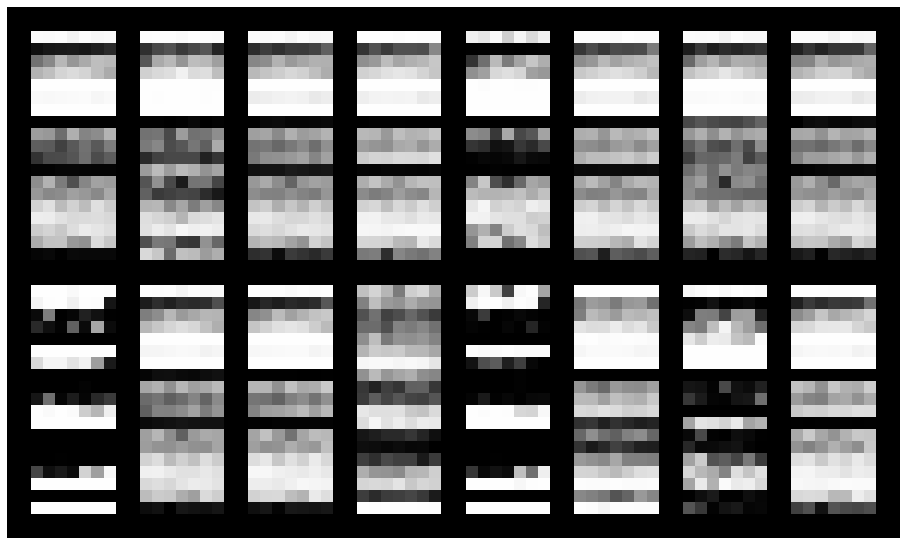

Epoch: [88/200], Batch Num: [0/54]
Discriminator Loss: 0.0513, Generator Loss: 5.7965
D(x): 0.9902, D(G(z)): 0.0119


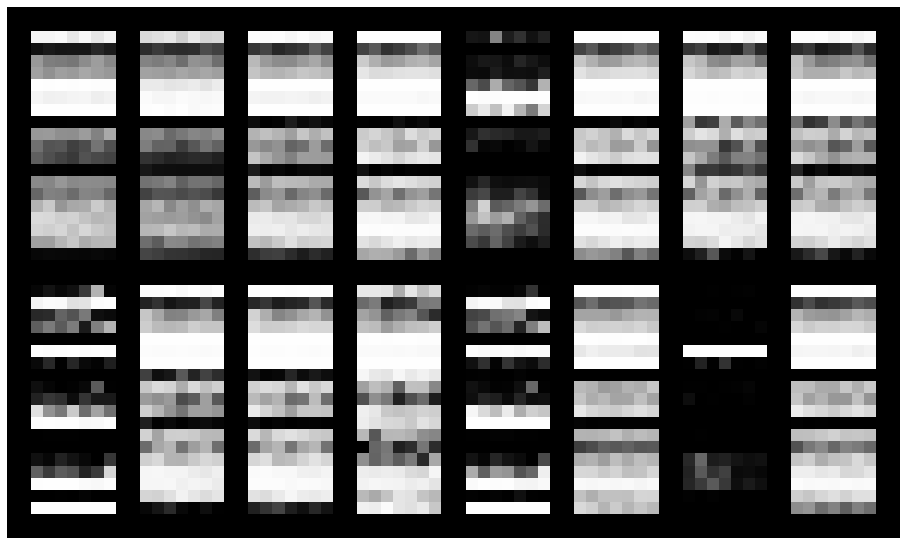

Epoch: [89/200], Batch Num: [0/54]
Discriminator Loss: 0.0213, Generator Loss: 6.4078
D(x): 0.9959, D(G(z)): 0.0029


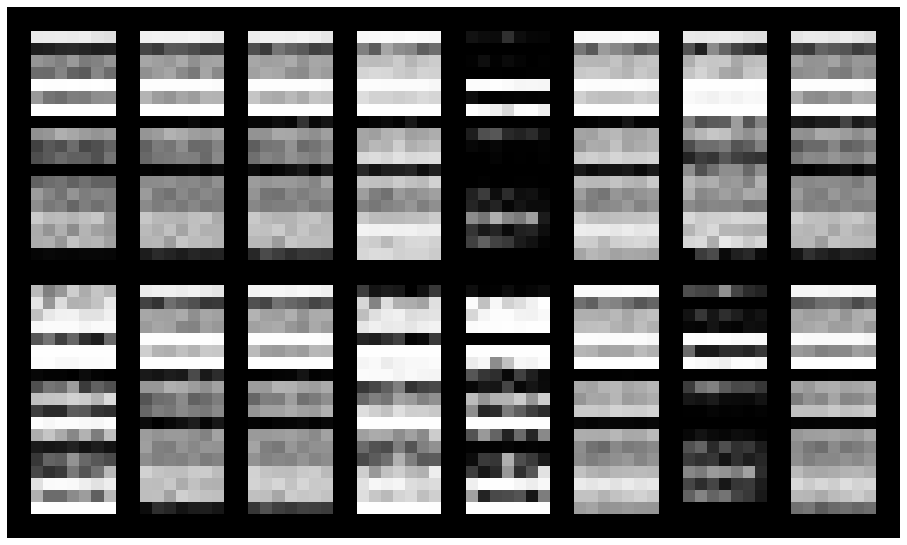

Epoch: [90/200], Batch Num: [0/54]
Discriminator Loss: 0.0311, Generator Loss: 6.7108
D(x): 0.9939, D(G(z)): 0.0029


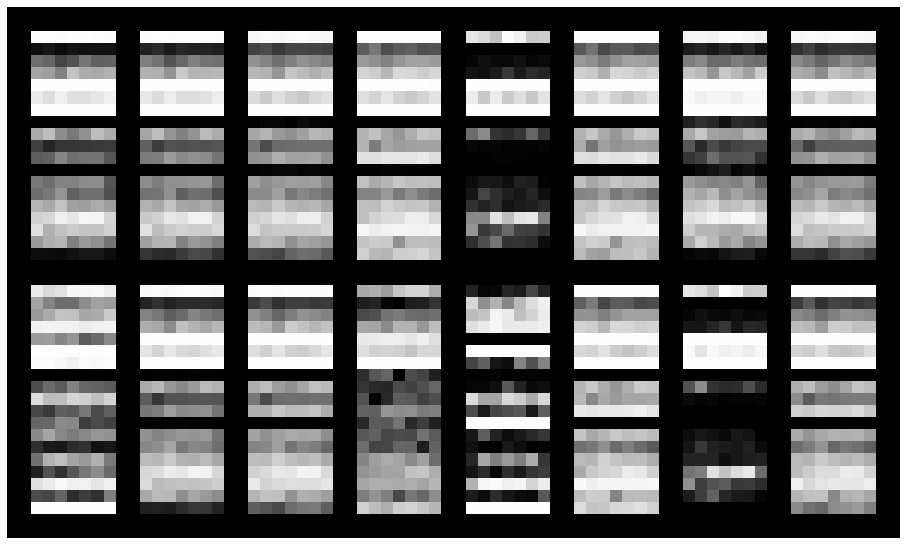

Epoch: [91/200], Batch Num: [0/54]
Discriminator Loss: 0.0139, Generator Loss: 5.8477
D(x): 0.9979, D(G(z)): 0.0069


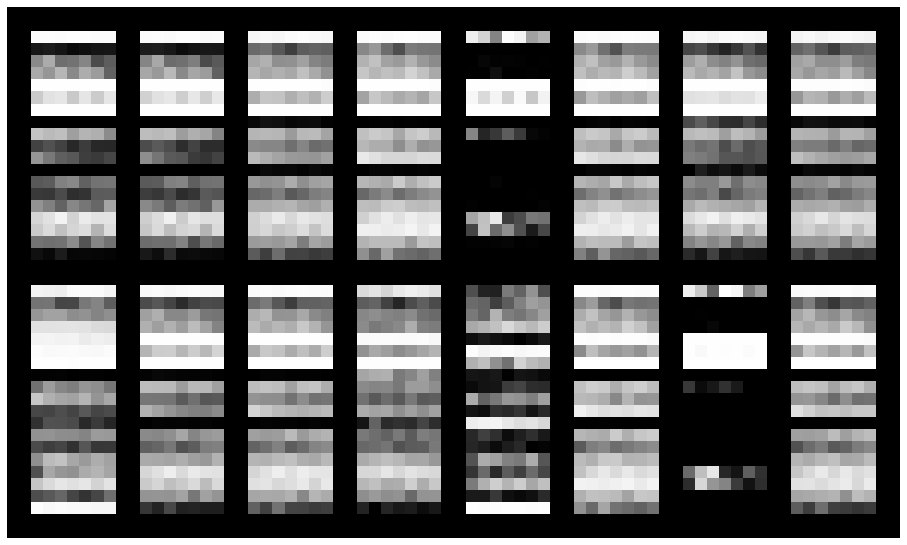

Epoch: [92/200], Batch Num: [0/54]
Discriminator Loss: 0.0144, Generator Loss: 5.9979
D(x): 0.9981, D(G(z)): 0.0064


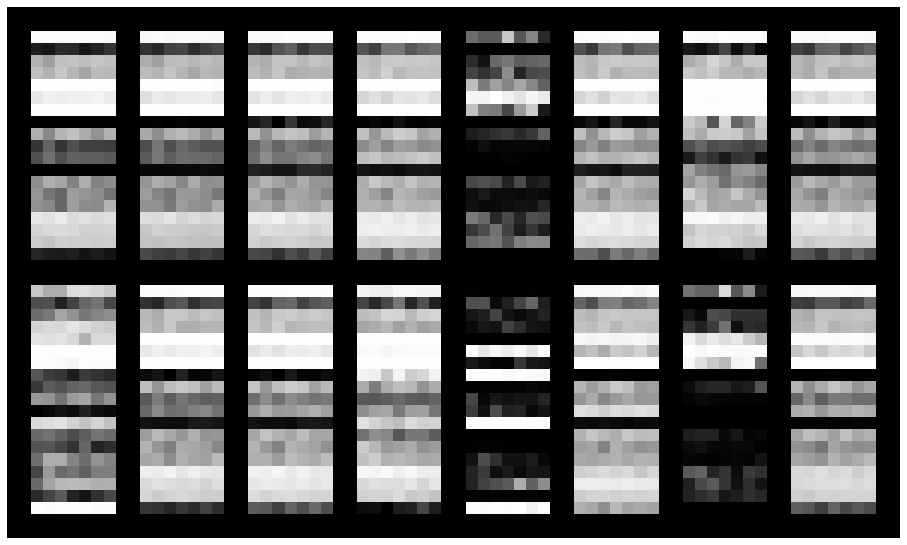

Epoch: [93/200], Batch Num: [0/54]
Discriminator Loss: 0.0230, Generator Loss: 5.9113
D(x): 0.9951, D(G(z)): 0.0076


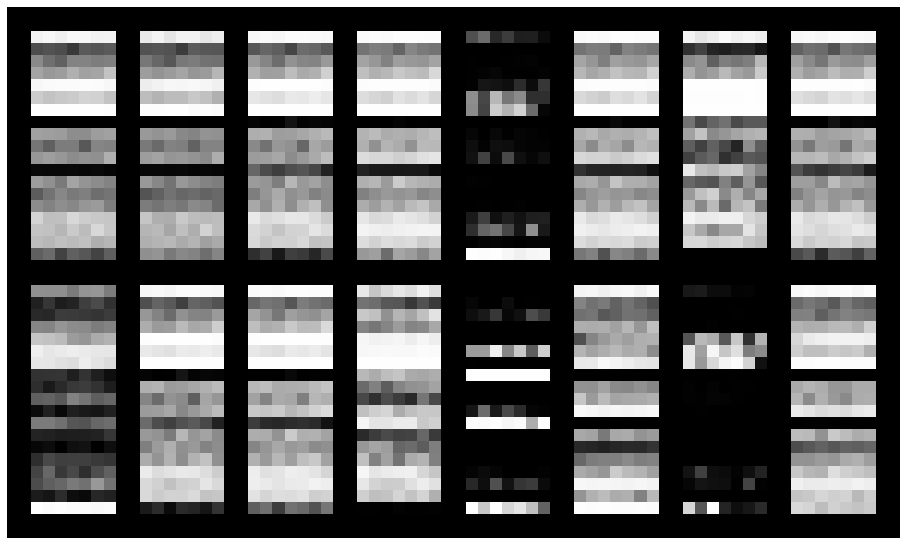

Epoch: [94/200], Batch Num: [0/54]
Discriminator Loss: 0.0142, Generator Loss: 5.8400
D(x): 0.9971, D(G(z)): 0.0074


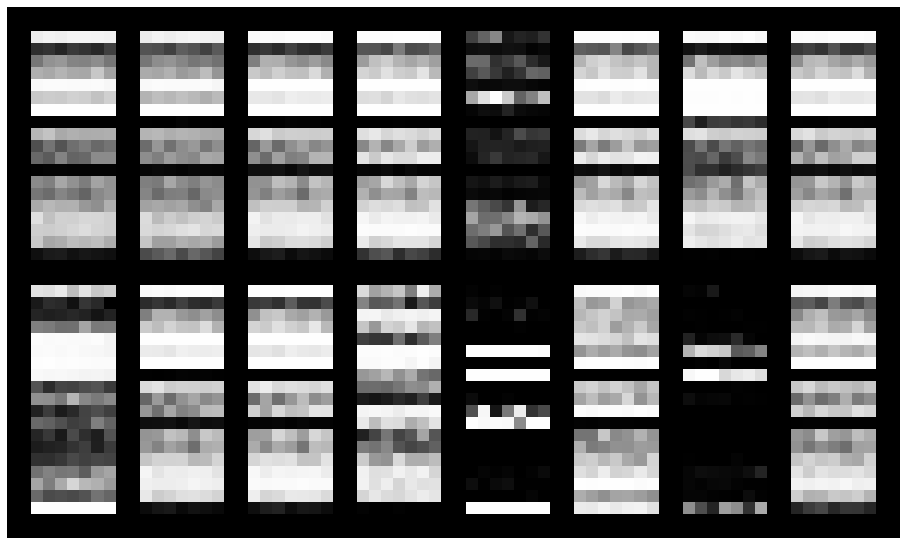

Epoch: [95/200], Batch Num: [0/54]
Discriminator Loss: 0.0393, Generator Loss: 6.7331
D(x): 0.9939, D(G(z)): 0.0057


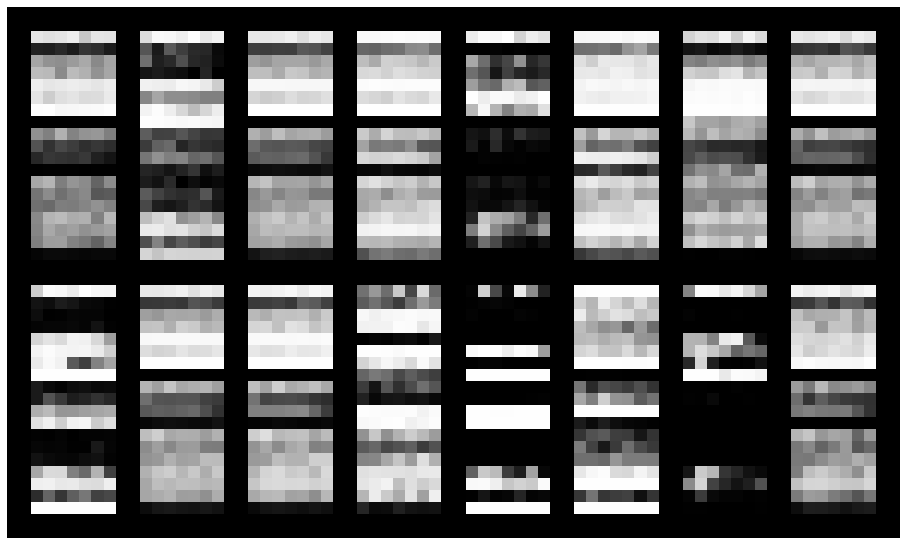

Epoch: [96/200], Batch Num: [0/54]
Discriminator Loss: 0.0509, Generator Loss: 6.2117
D(x): 0.9906, D(G(z)): 0.0050


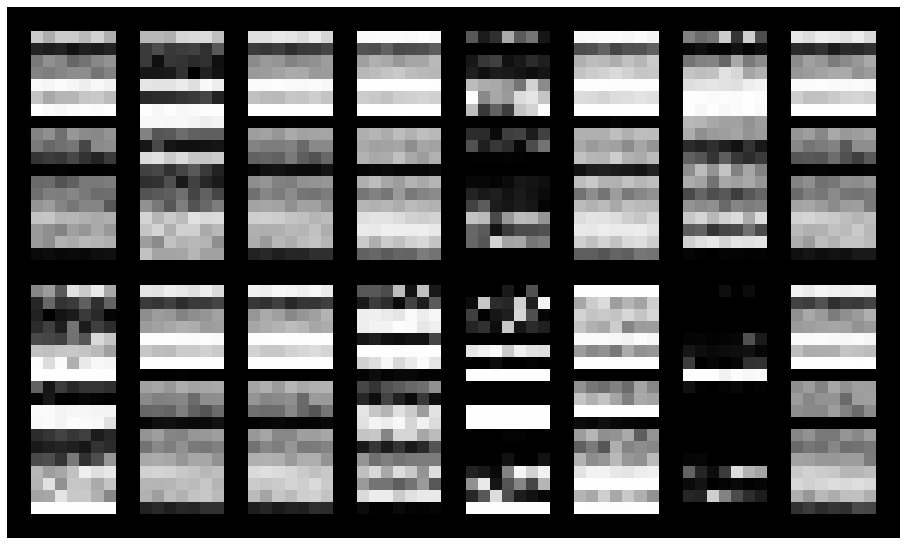

Epoch: [97/200], Batch Num: [0/54]
Discriminator Loss: 0.0690, Generator Loss: 6.0341
D(x): 0.9856, D(G(z)): 0.0083


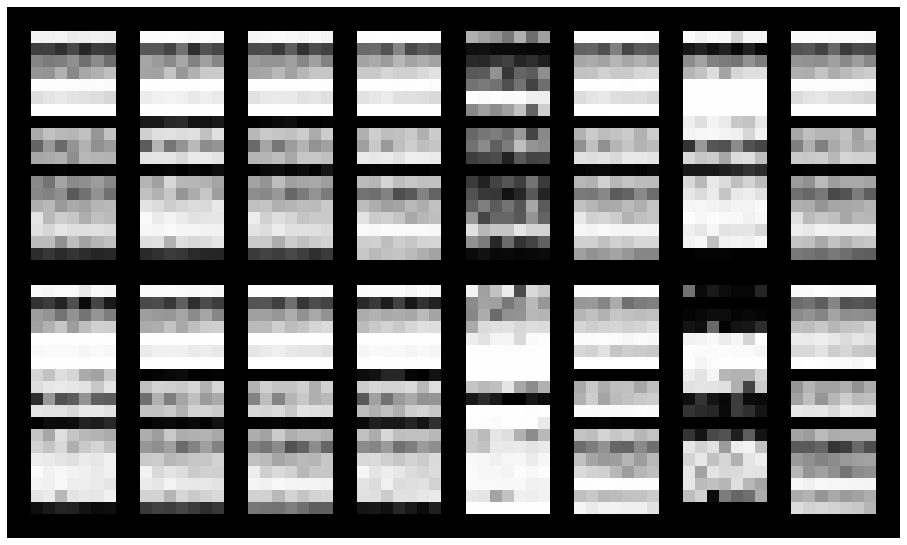

Epoch: [98/200], Batch Num: [0/54]
Discriminator Loss: 0.0160, Generator Loss: 6.2424
D(x): 0.9962, D(G(z)): 0.0044


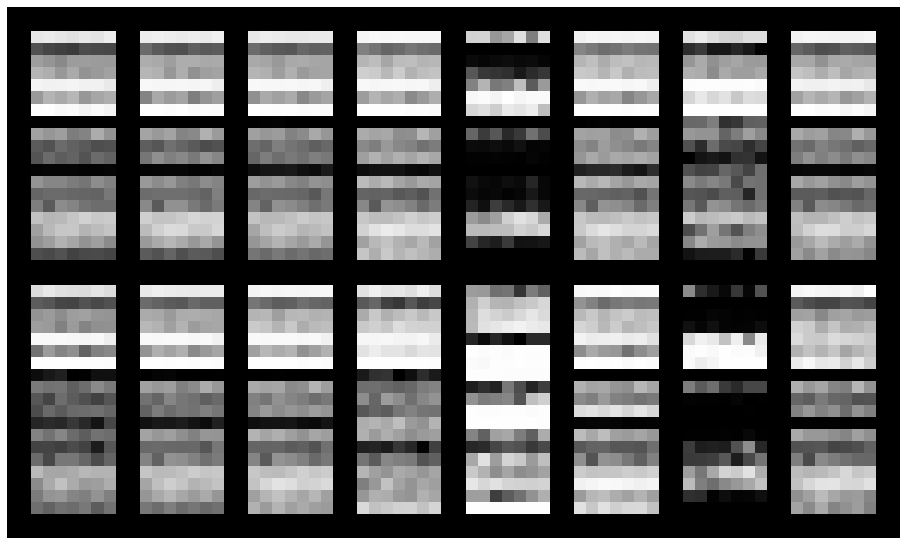

Epoch: [99/200], Batch Num: [0/54]
Discriminator Loss: 0.0249, Generator Loss: 5.8140
D(x): 0.9938, D(G(z)): 0.0073


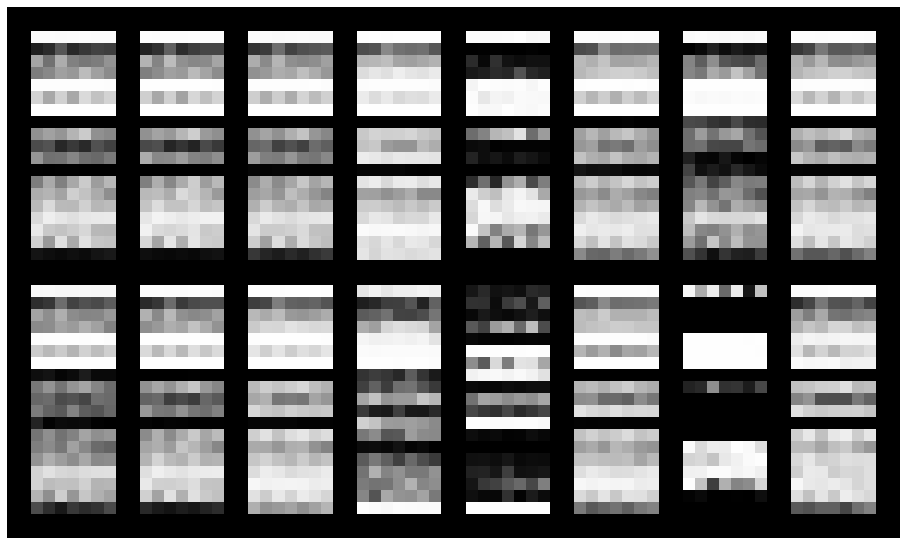

Epoch: [100/200], Batch Num: [0/54]
Discriminator Loss: 0.0138, Generator Loss: 6.9198
D(x): 0.9963, D(G(z)): 0.0030


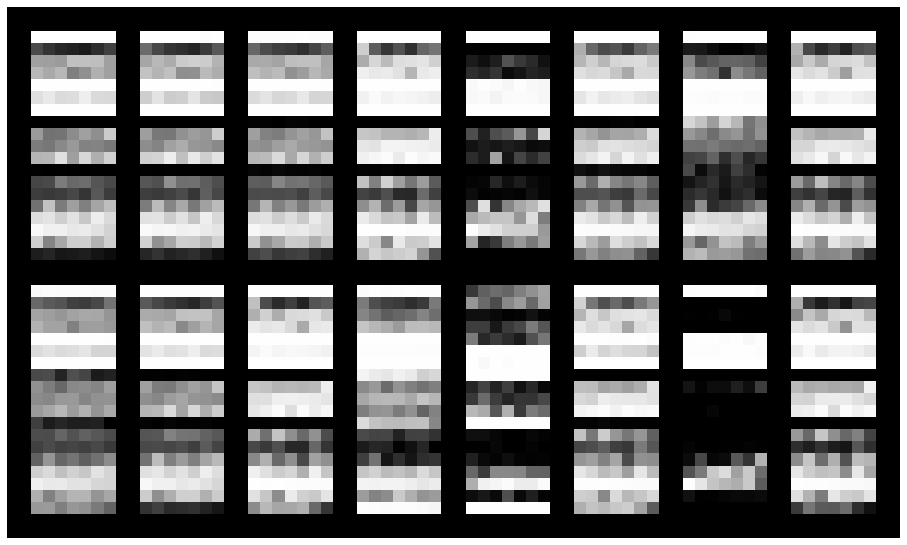

Epoch: [101/200], Batch Num: [0/54]
Discriminator Loss: 0.0048, Generator Loss: 5.9975
D(x): 0.9997, D(G(z)): 0.0044


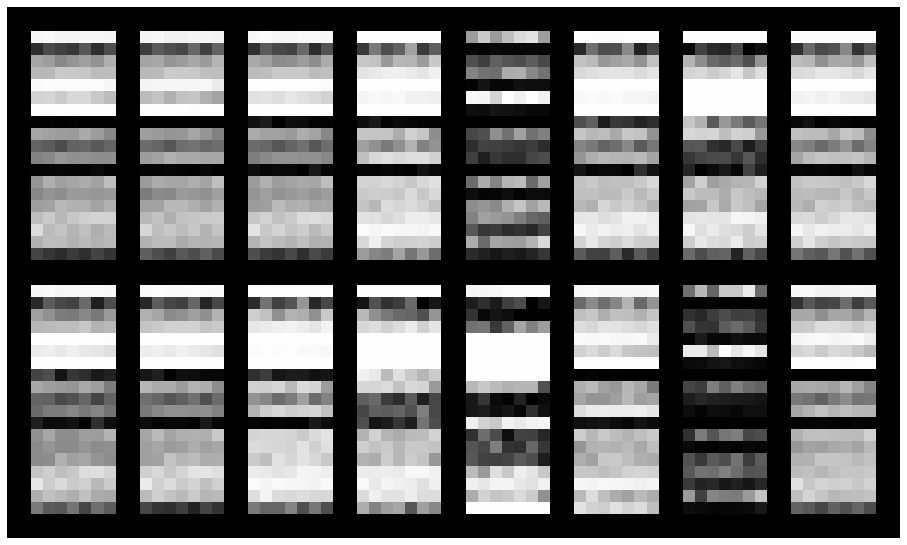

Epoch: [102/200], Batch Num: [0/54]
Discriminator Loss: 0.0241, Generator Loss: 6.9554
D(x): 0.9914, D(G(z)): 0.0034


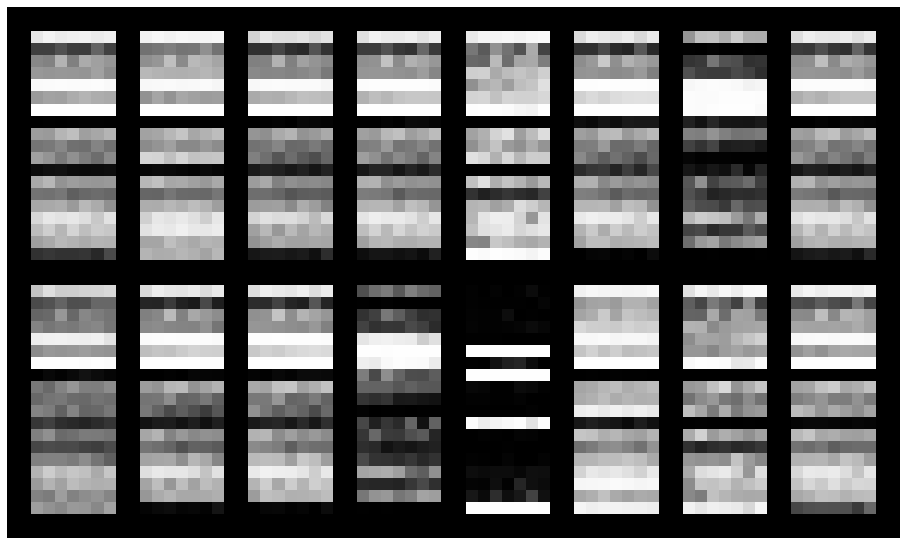

Epoch: [103/200], Batch Num: [0/54]
Discriminator Loss: 0.0233, Generator Loss: 5.9954
D(x): 0.9961, D(G(z)): 0.0076


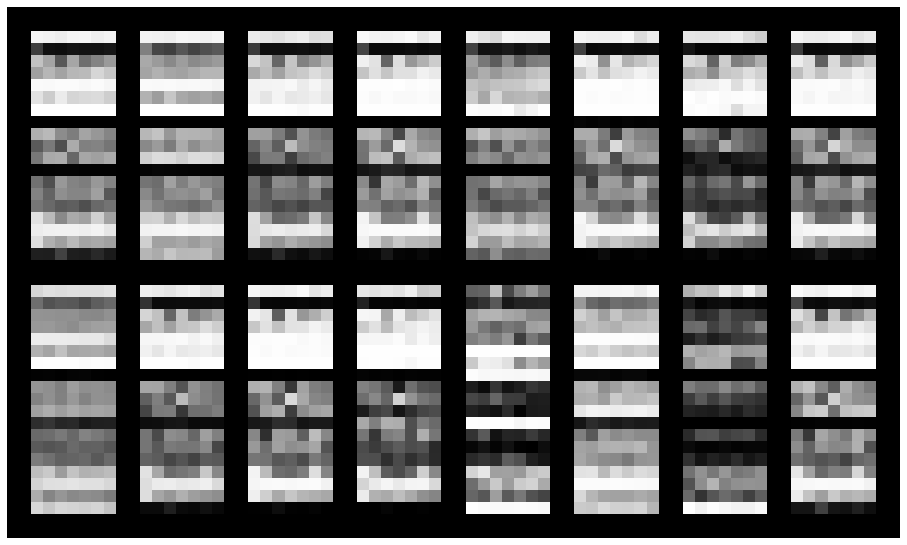

Epoch: [104/200], Batch Num: [0/54]
Discriminator Loss: 0.0407, Generator Loss: 6.1896
D(x): 0.9936, D(G(z)): 0.0066


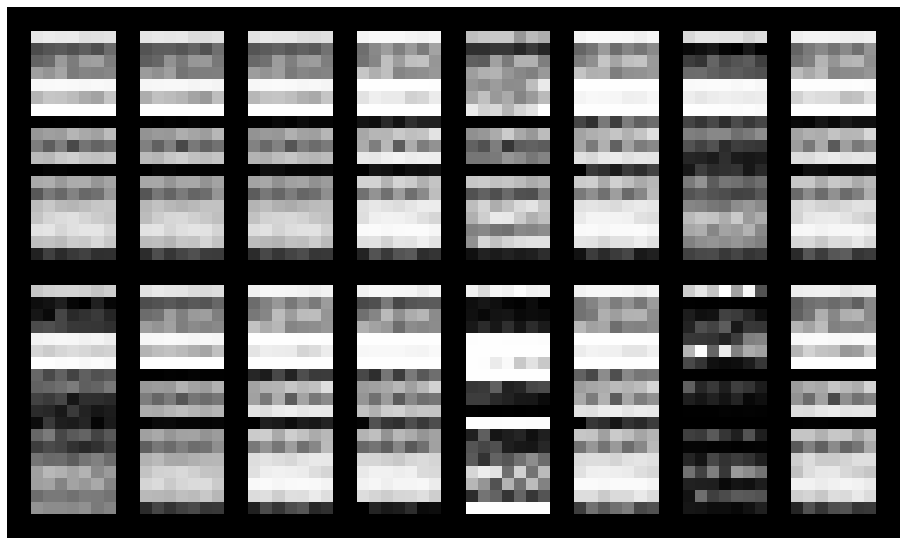

Epoch: [105/200], Batch Num: [0/54]
Discriminator Loss: 0.0246, Generator Loss: 5.8418
D(x): 0.9985, D(G(z)): 0.0086


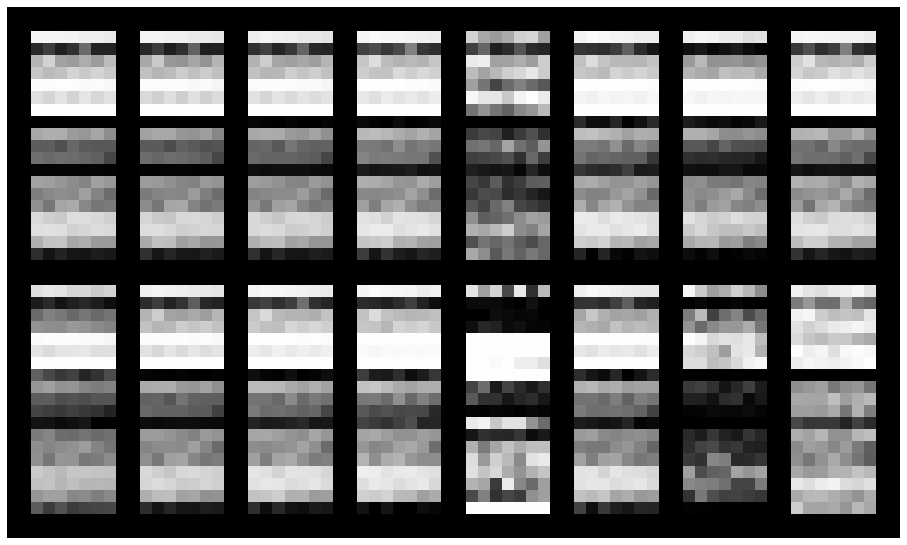

Epoch: [106/200], Batch Num: [0/54]
Discriminator Loss: 0.0198, Generator Loss: 5.5242
D(x): 0.9961, D(G(z)): 0.0086


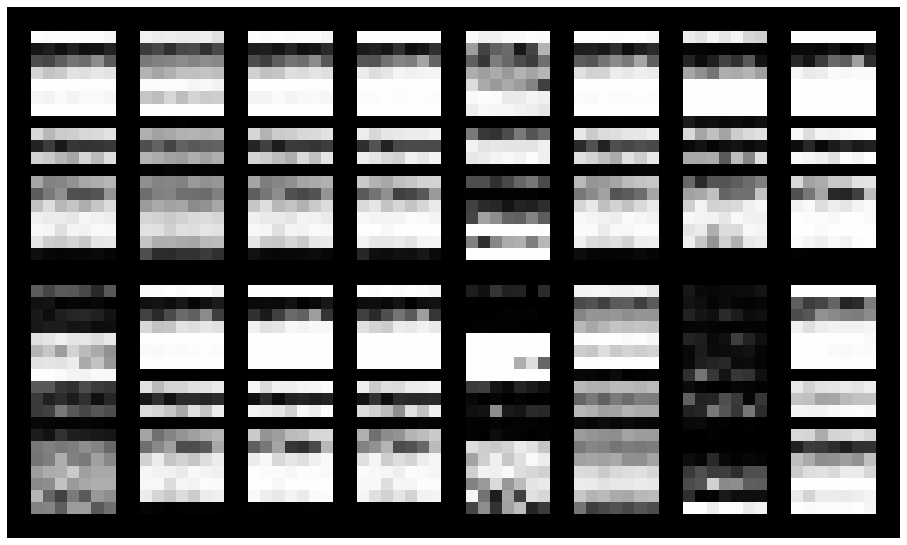

Epoch: [107/200], Batch Num: [0/54]
Discriminator Loss: 0.0182, Generator Loss: 6.5217
D(x): 0.9956, D(G(z)): 0.0051


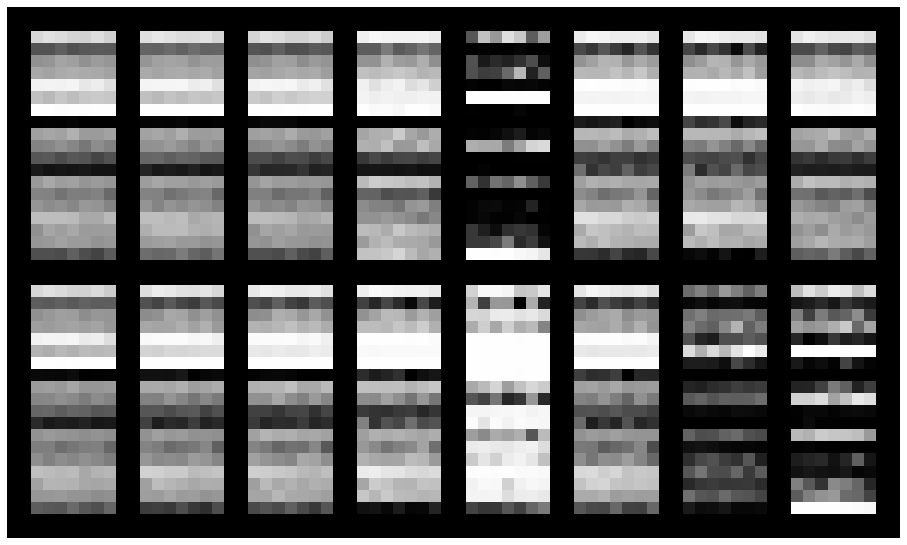

Epoch: [108/200], Batch Num: [0/54]
Discriminator Loss: 0.0503, Generator Loss: 6.3270
D(x): 0.9884, D(G(z)): 0.0054


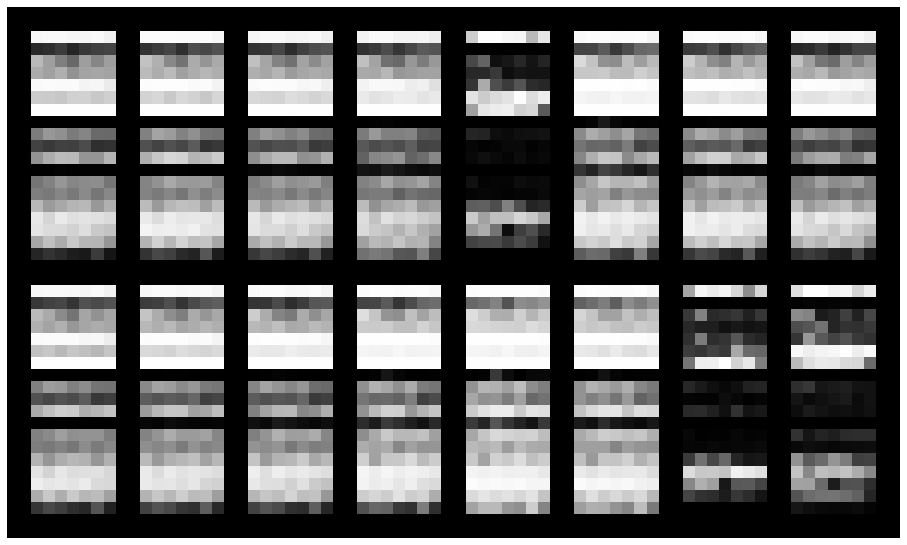

Epoch: [109/200], Batch Num: [0/54]
Discriminator Loss: 0.0751, Generator Loss: 5.7520
D(x): 0.9856, D(G(z)): 0.0055


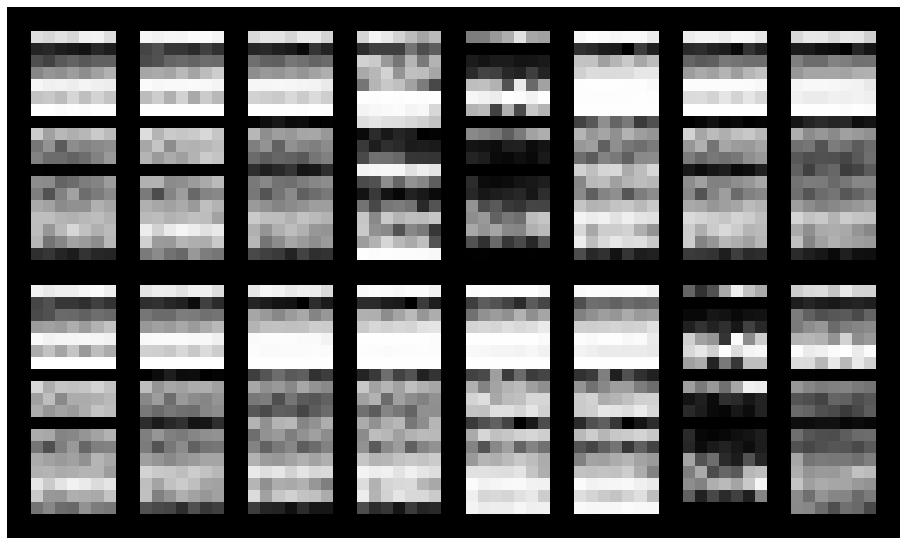

Epoch: [110/200], Batch Num: [0/54]
Discriminator Loss: 0.0354, Generator Loss: 6.3411
D(x): 0.9953, D(G(z)): 0.0063


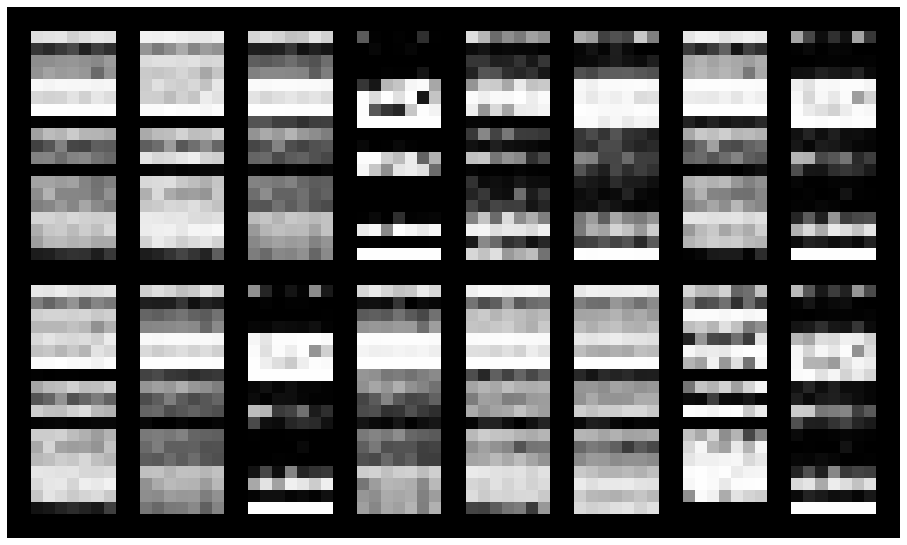

Epoch: [111/200], Batch Num: [0/54]
Discriminator Loss: 0.0609, Generator Loss: 6.2452
D(x): 0.9882, D(G(z)): 0.0036


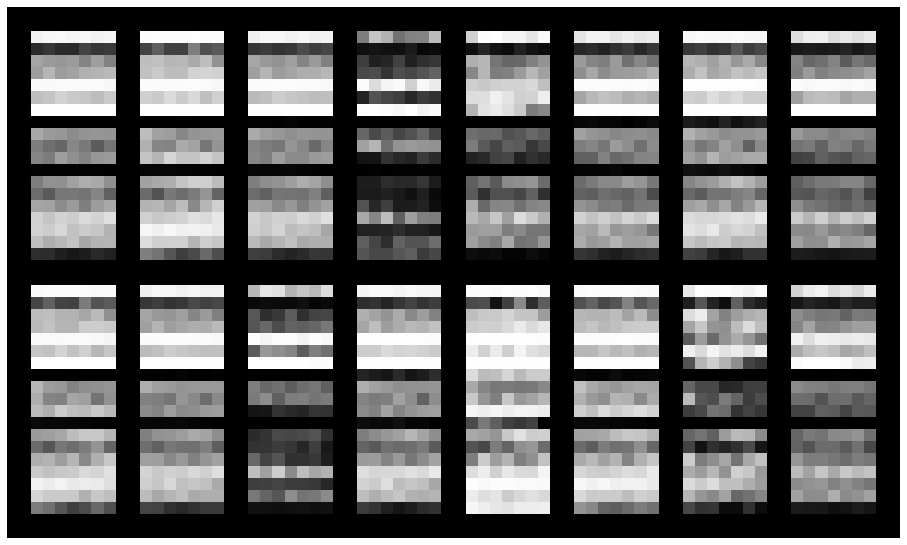

Epoch: [112/200], Batch Num: [0/54]
Discriminator Loss: 0.0327, Generator Loss: 6.3199
D(x): 0.9938, D(G(z)): 0.0029


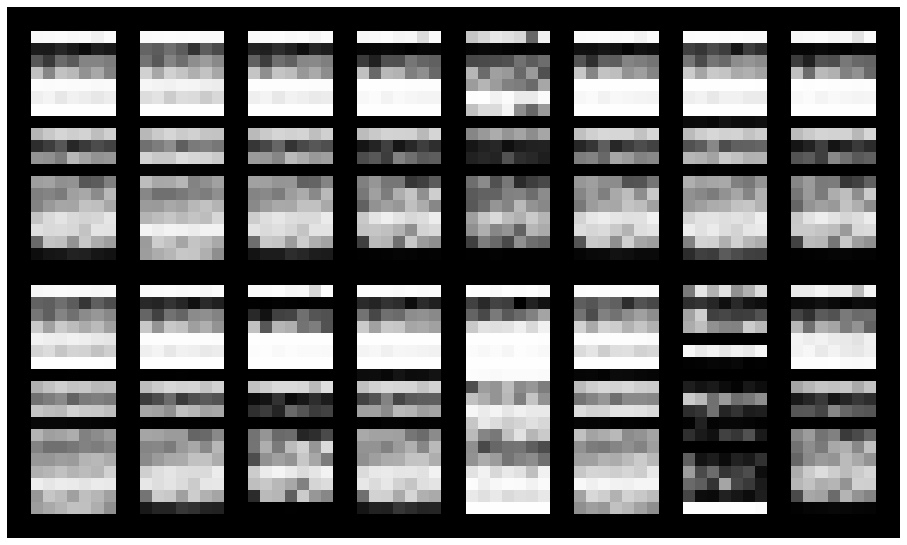

Epoch: [113/200], Batch Num: [0/54]
Discriminator Loss: 0.0204, Generator Loss: 6.5479
D(x): 0.9957, D(G(z)): 0.0028


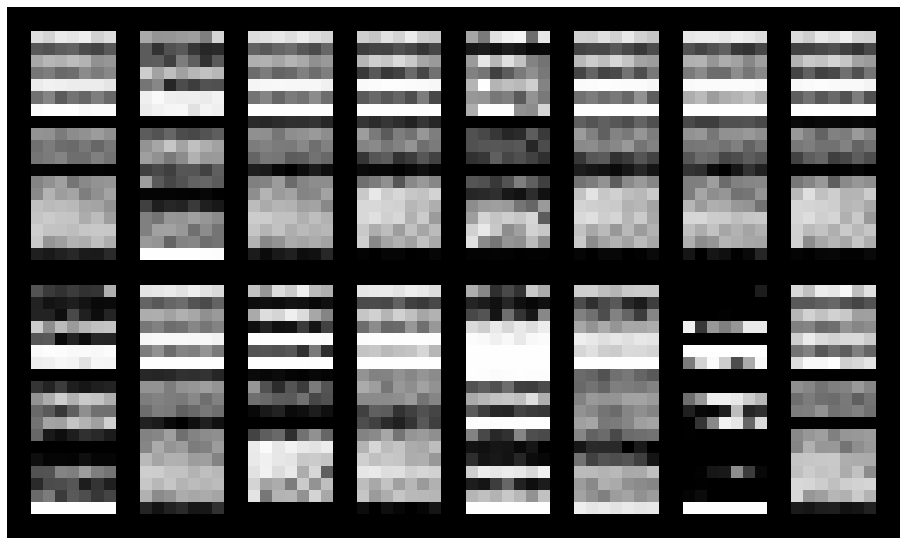

Epoch: [114/200], Batch Num: [0/54]
Discriminator Loss: 0.0203, Generator Loss: 6.2171
D(x): 0.9955, D(G(z)): 0.0066


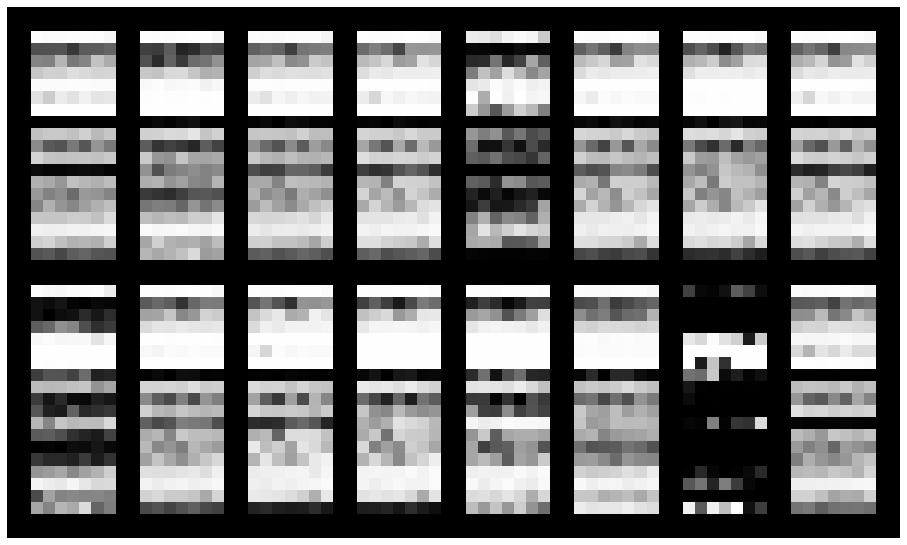

Epoch: [115/200], Batch Num: [0/54]
Discriminator Loss: 0.0257, Generator Loss: 6.0540
D(x): 0.9962, D(G(z)): 0.0089


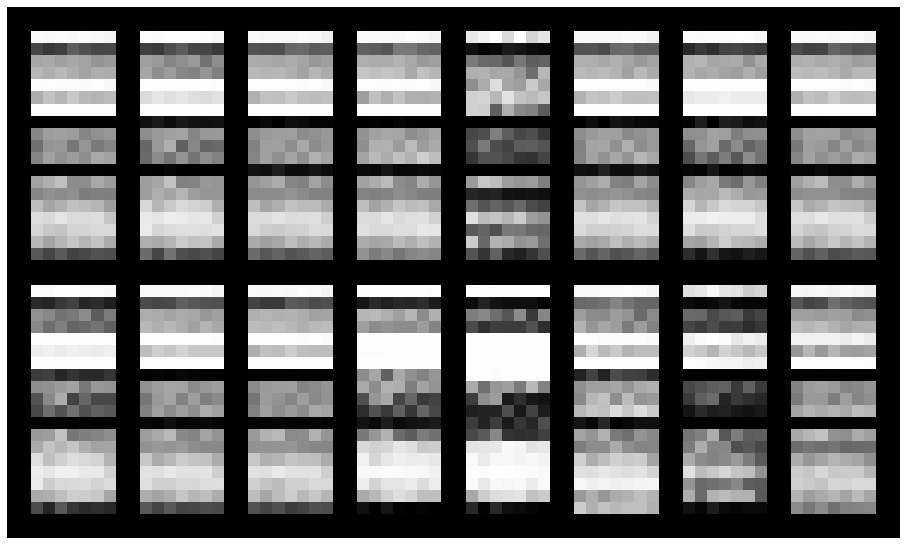

Epoch: [116/200], Batch Num: [0/54]
Discriminator Loss: 0.0288, Generator Loss: 6.6593
D(x): 0.9962, D(G(z)): 0.0053


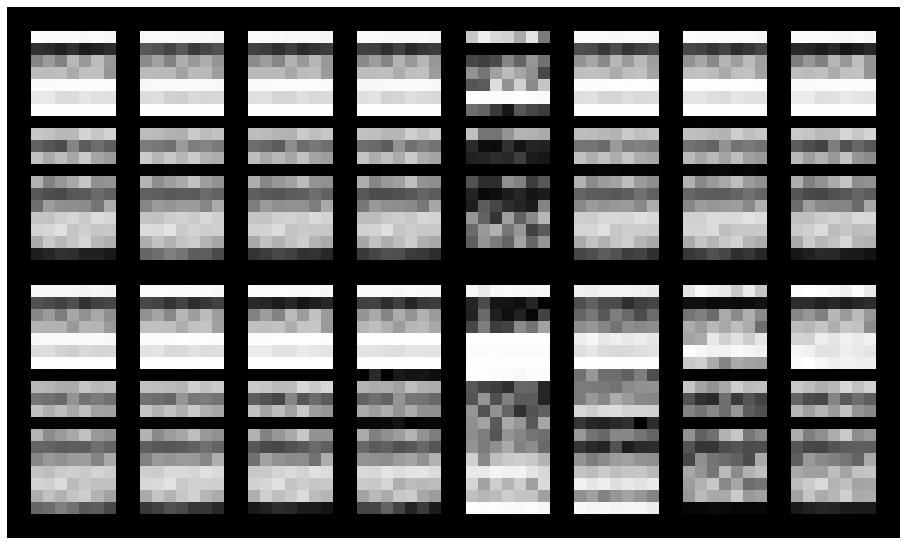

Epoch: [117/200], Batch Num: [0/54]
Discriminator Loss: 0.0054, Generator Loss: 6.5910
D(x): 0.9998, D(G(z)): 0.0049


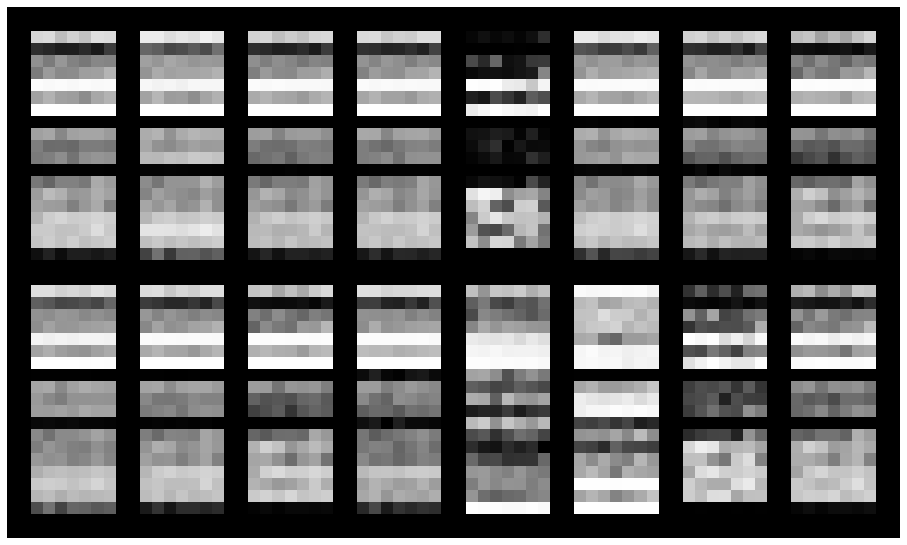

Epoch: [118/200], Batch Num: [0/54]
Discriminator Loss: 0.0163, Generator Loss: 6.8984
D(x): 0.9962, D(G(z)): 0.0058


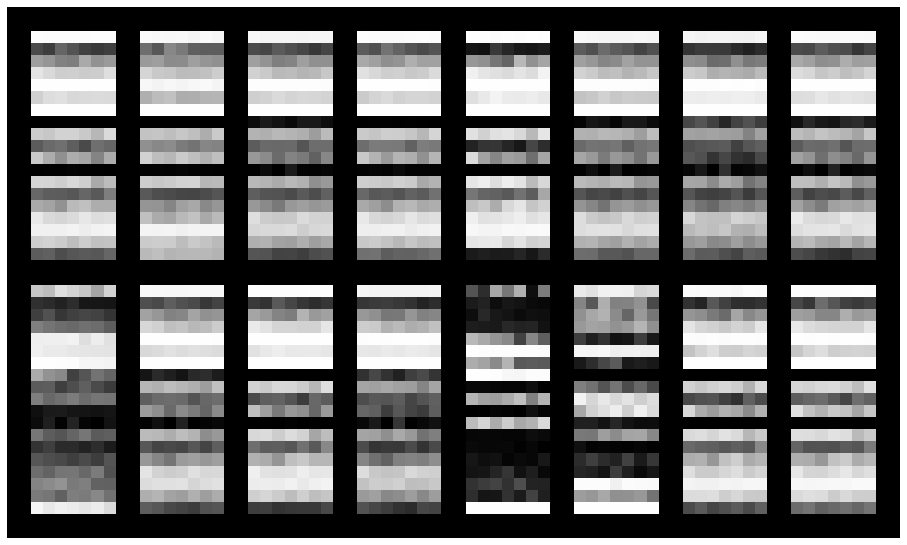

Epoch: [119/200], Batch Num: [0/54]
Discriminator Loss: 0.0282, Generator Loss: 6.7403
D(x): 0.9959, D(G(z)): 0.0022


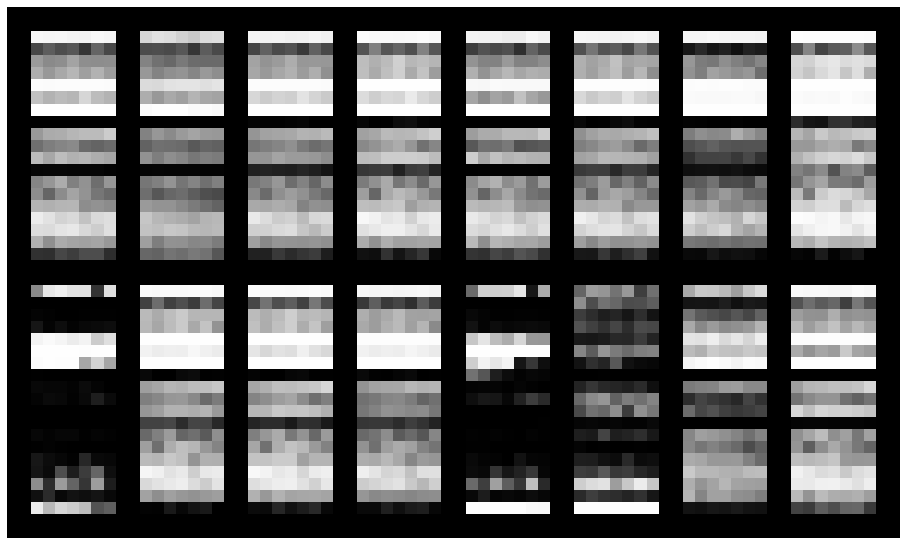

Epoch: [120/200], Batch Num: [0/54]
Discriminator Loss: 0.0651, Generator Loss: 7.1237
D(x): 0.9898, D(G(z)): 0.0015


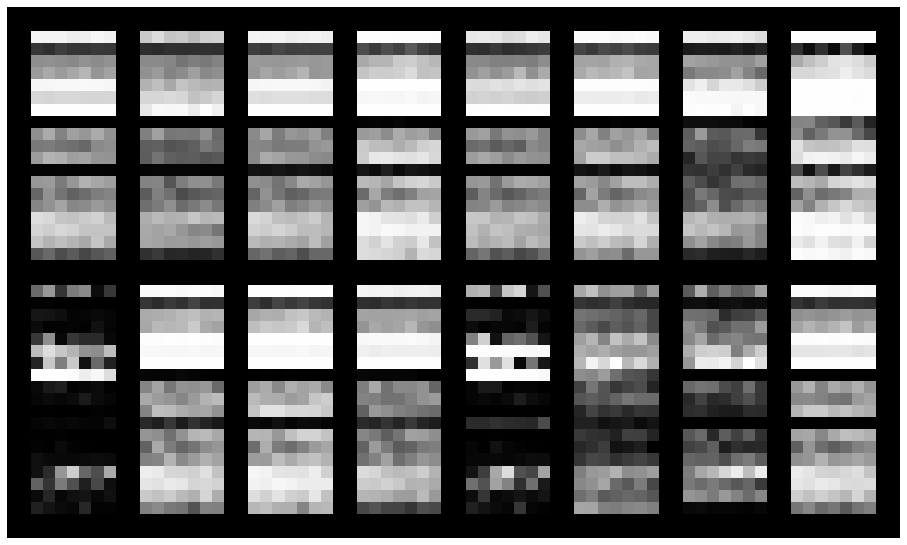

Epoch: [121/200], Batch Num: [0/54]
Discriminator Loss: 0.0159, Generator Loss: 6.4578
D(x): 0.9967, D(G(z)): 0.0026


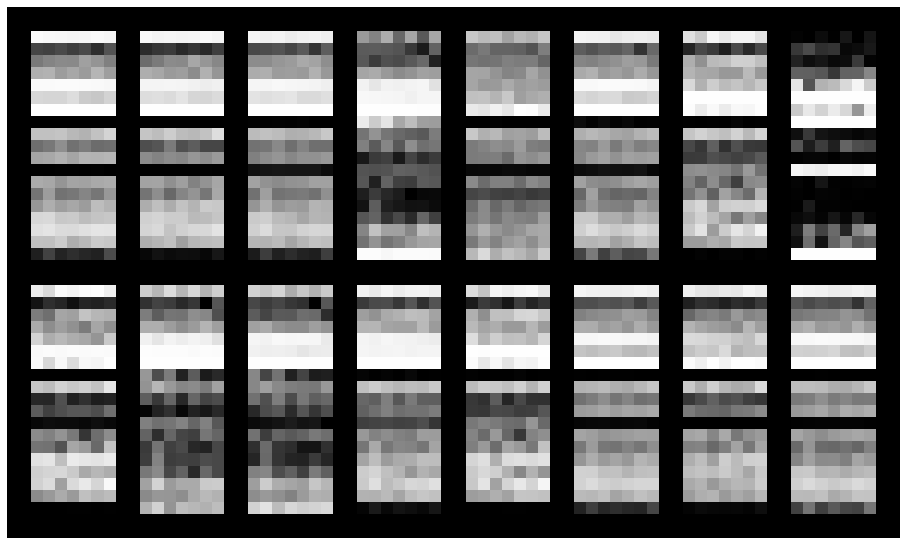

Epoch: [122/200], Batch Num: [0/54]
Discriminator Loss: 0.0324, Generator Loss: 6.3638
D(x): 0.9944, D(G(z)): 0.0076


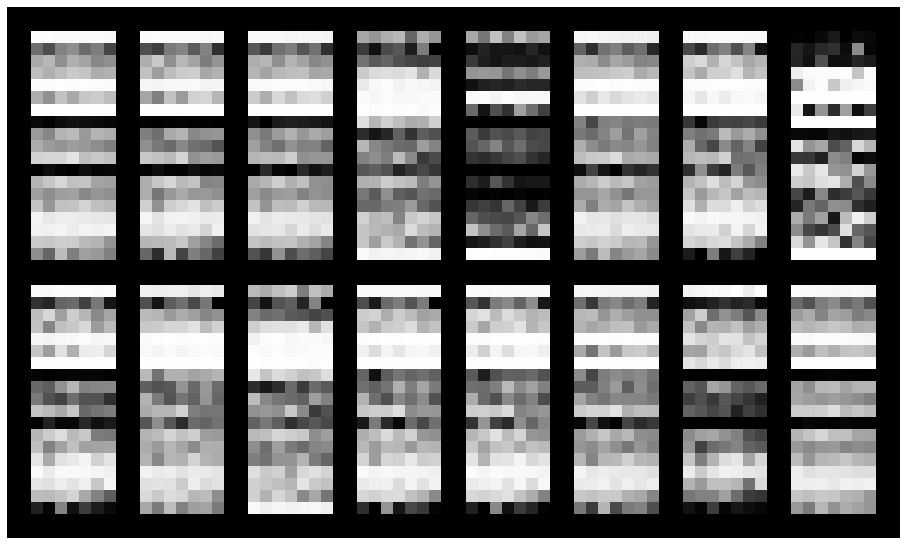

Epoch: [123/200], Batch Num: [0/54]
Discriminator Loss: 0.0045, Generator Loss: 6.1450
D(x): 0.9999, D(G(z)): 0.0043


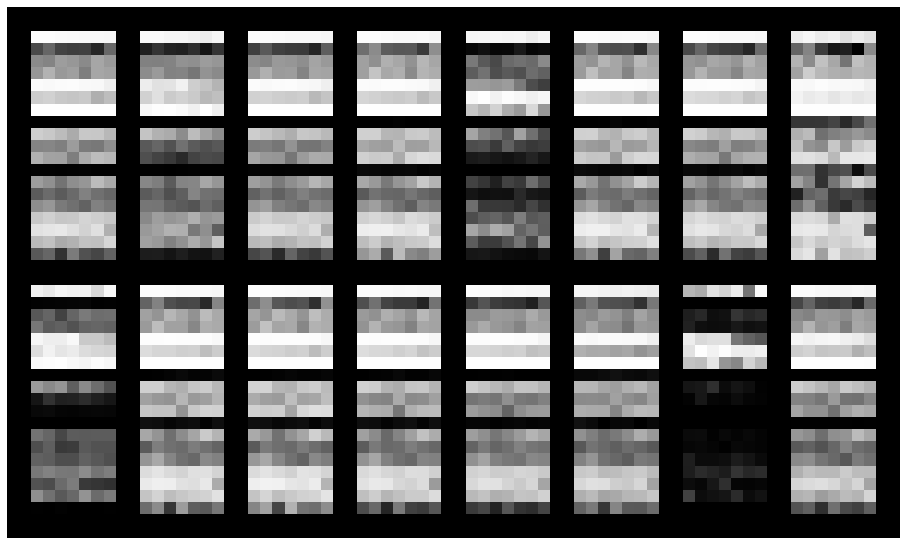

Epoch: [124/200], Batch Num: [0/54]
Discriminator Loss: 0.0437, Generator Loss: 5.9832
D(x): 0.9924, D(G(z)): 0.0061


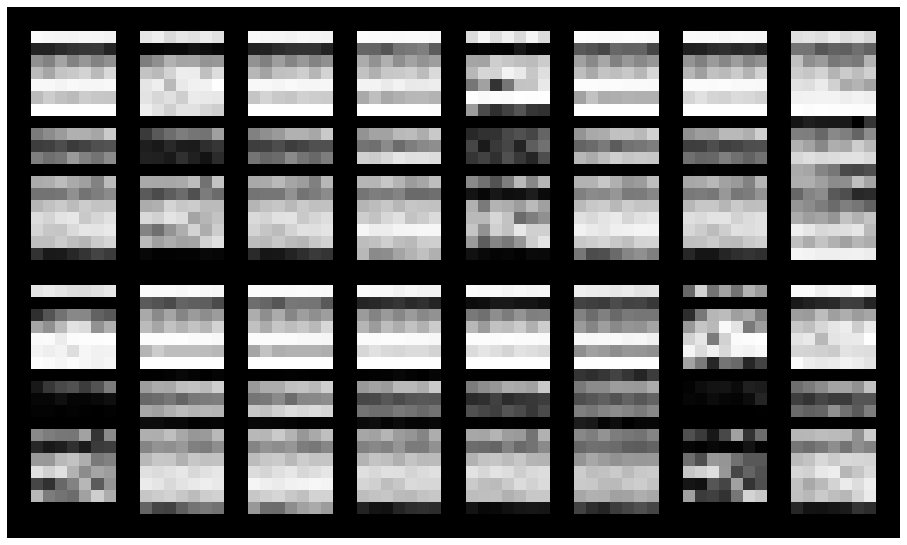

Epoch: [125/200], Batch Num: [0/54]
Discriminator Loss: 0.0335, Generator Loss: 6.4844
D(x): 0.9941, D(G(z)): 0.0029


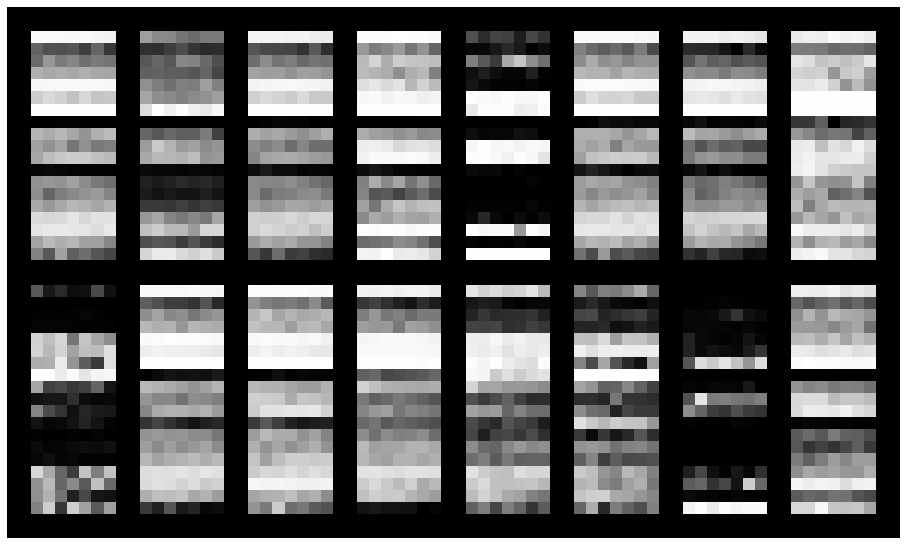

Epoch: [126/200], Batch Num: [0/54]
Discriminator Loss: 0.0835, Generator Loss: 6.4815
D(x): 0.9819, D(G(z)): 0.0089


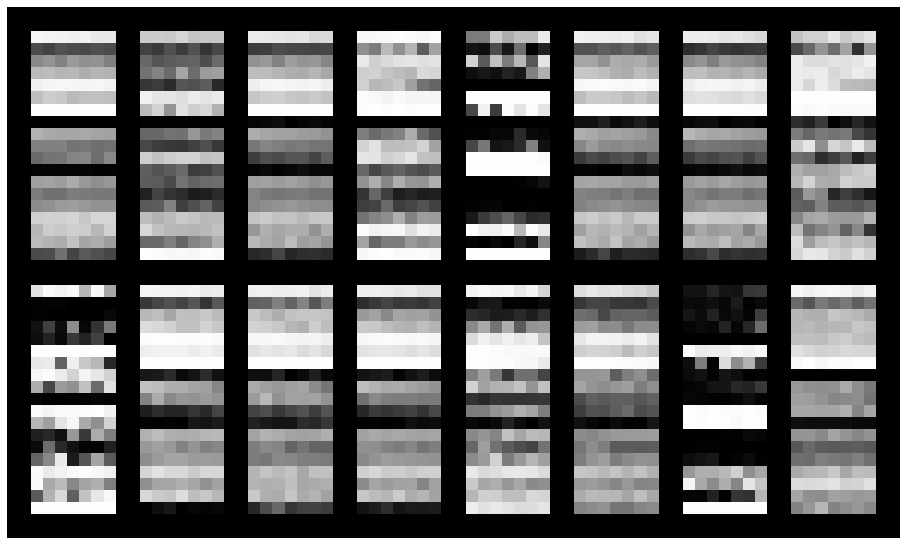

Epoch: [127/200], Batch Num: [0/54]
Discriminator Loss: 0.0195, Generator Loss: 6.2115
D(x): 0.9930, D(G(z)): 0.0047


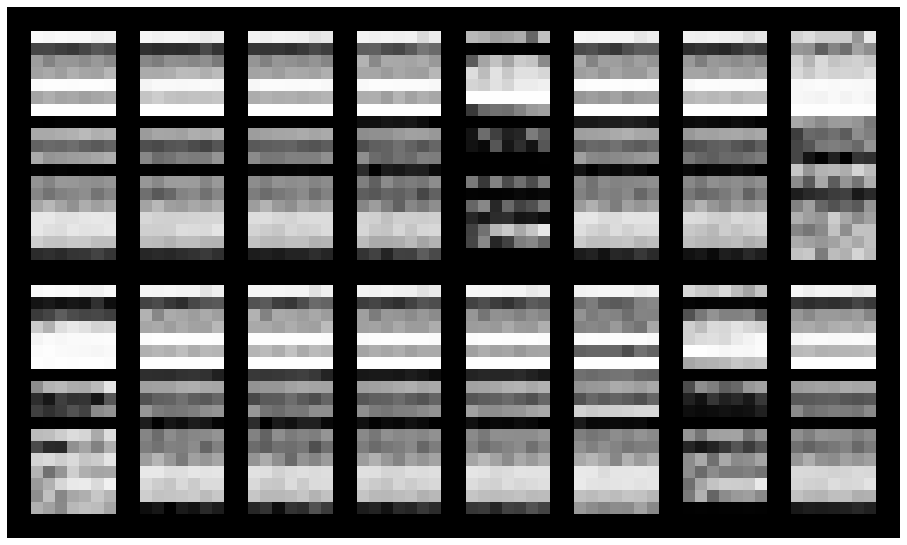

Epoch: [128/200], Batch Num: [0/54]
Discriminator Loss: 0.0392, Generator Loss: 6.5876
D(x): 0.9927, D(G(z)): 0.0030


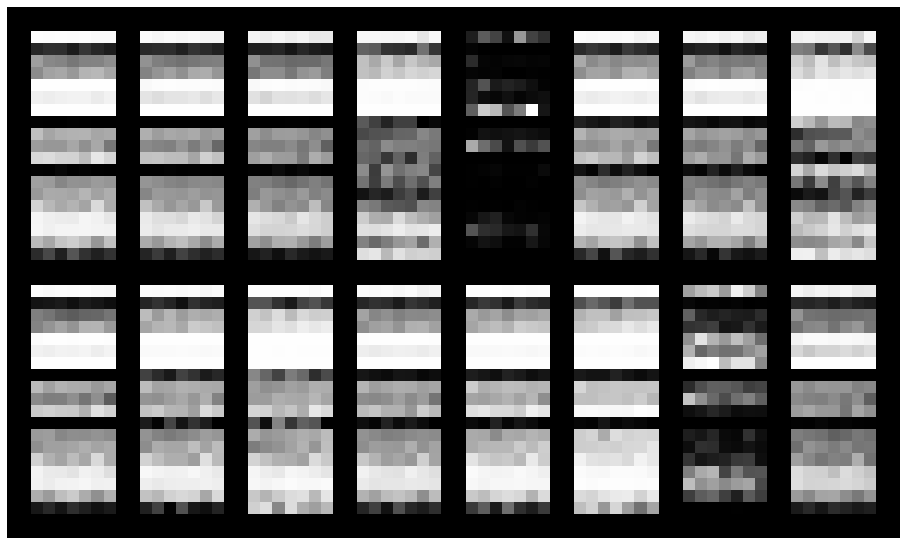

Epoch: [129/200], Batch Num: [0/54]
Discriminator Loss: 0.0218, Generator Loss: 6.8061
D(x): 0.9942, D(G(z)): 0.0054


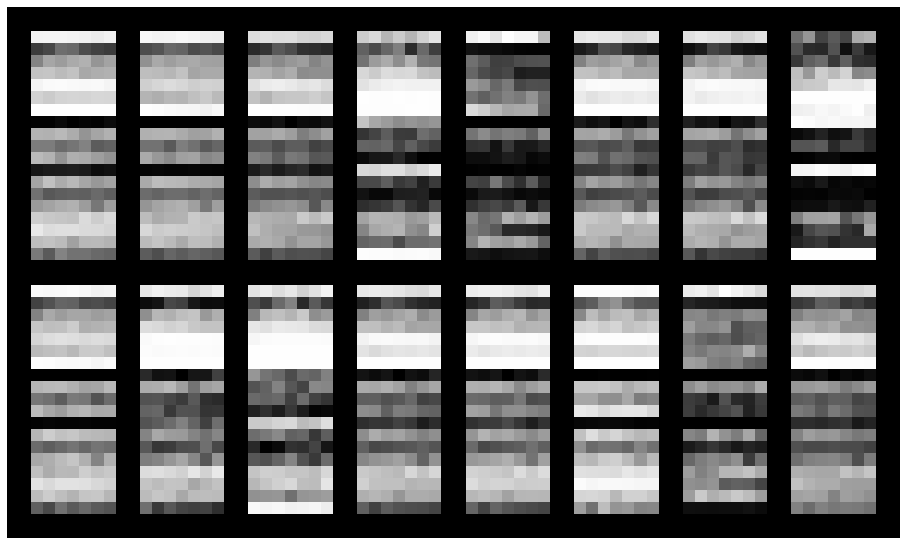

Epoch: [130/200], Batch Num: [0/54]
Discriminator Loss: 0.0100, Generator Loss: 5.5935
D(x): 0.9994, D(G(z)): 0.0092


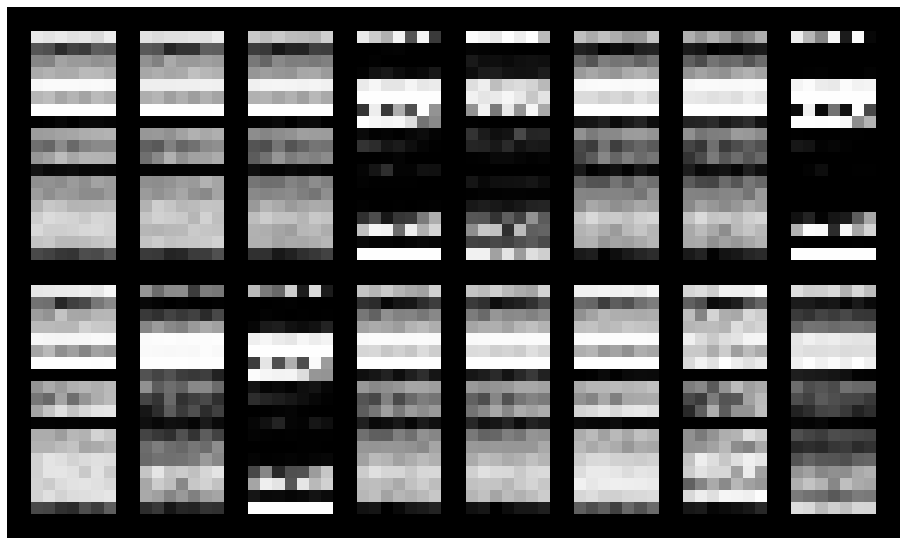

Epoch: [131/200], Batch Num: [0/54]
Discriminator Loss: 0.0069, Generator Loss: 6.7147
D(x): 0.9970, D(G(z)): 0.0029


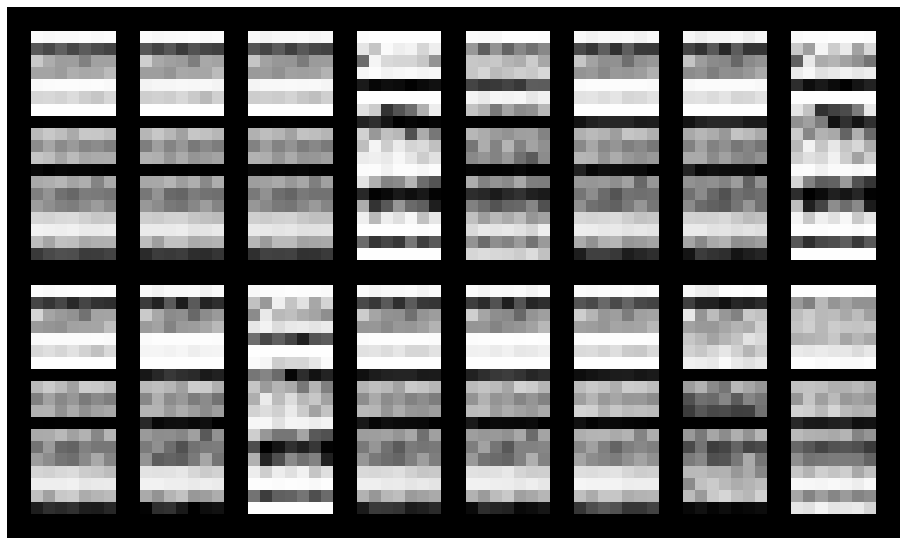

Epoch: [132/200], Batch Num: [0/54]
Discriminator Loss: 0.0867, Generator Loss: 6.5294
D(x): 0.9857, D(G(z)): 0.0046


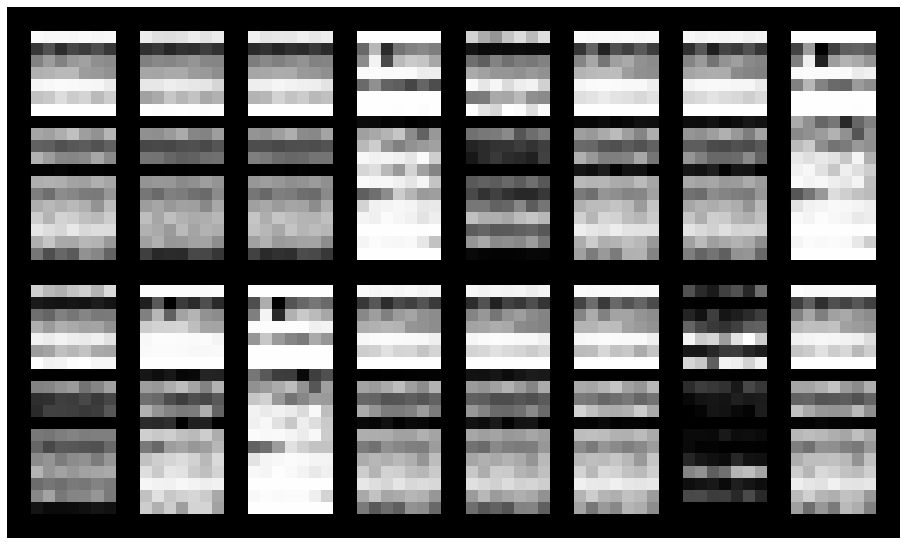

Epoch: [133/200], Batch Num: [0/54]
Discriminator Loss: 0.0154, Generator Loss: 6.2250
D(x): 0.9958, D(G(z)): 0.0048


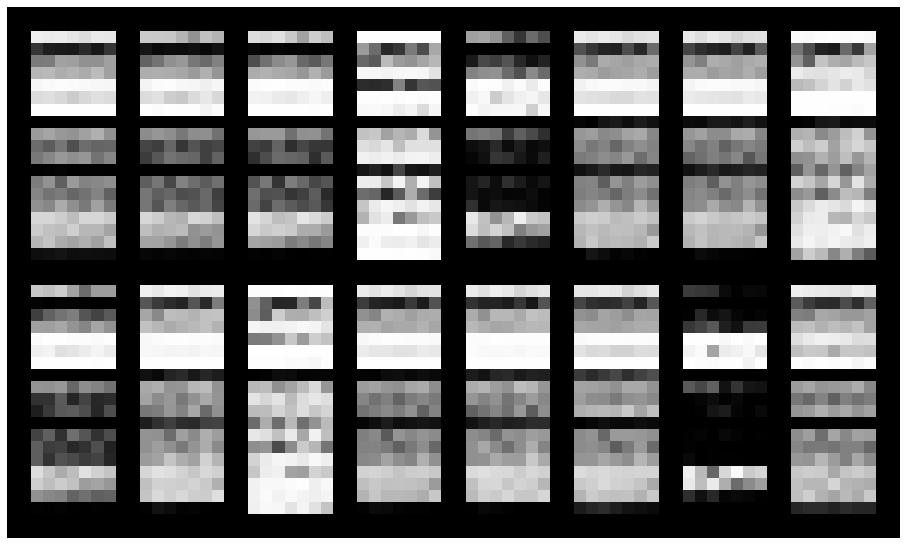

Epoch: [134/200], Batch Num: [0/54]
Discriminator Loss: 0.0194, Generator Loss: 6.0194
D(x): 0.9951, D(G(z)): 0.0065


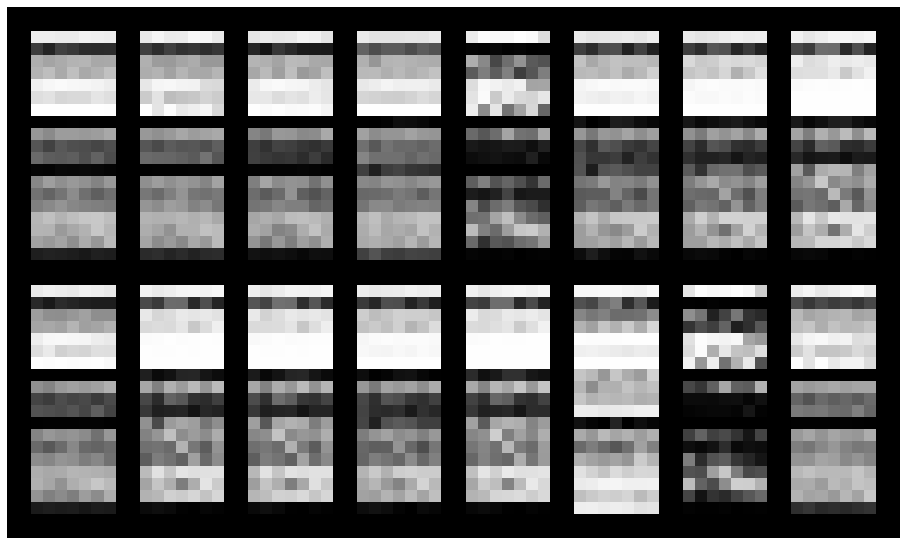

Epoch: [135/200], Batch Num: [0/54]
Discriminator Loss: 0.0153, Generator Loss: 6.4238
D(x): 0.9965, D(G(z)): 0.0046


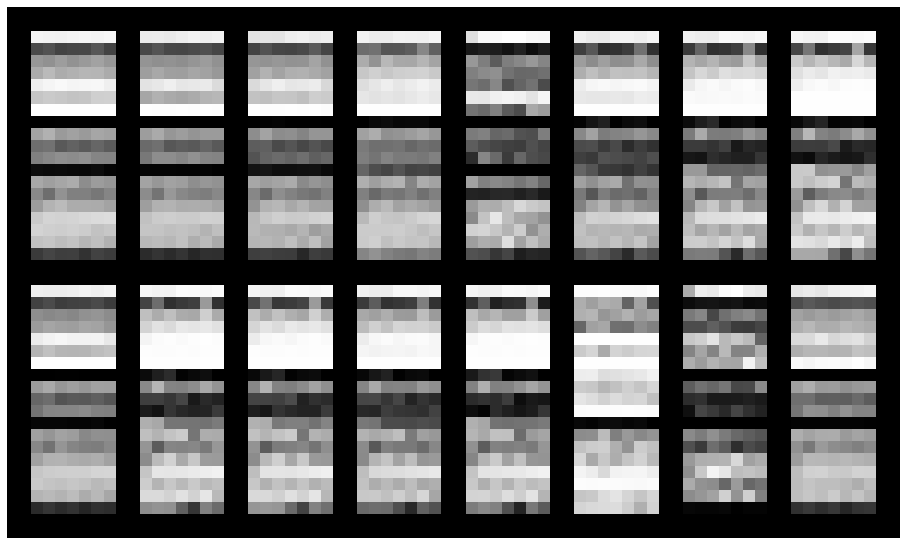

Epoch: [136/200], Batch Num: [0/54]
Discriminator Loss: 0.0310, Generator Loss: 5.8724
D(x): 0.9915, D(G(z)): 0.0028


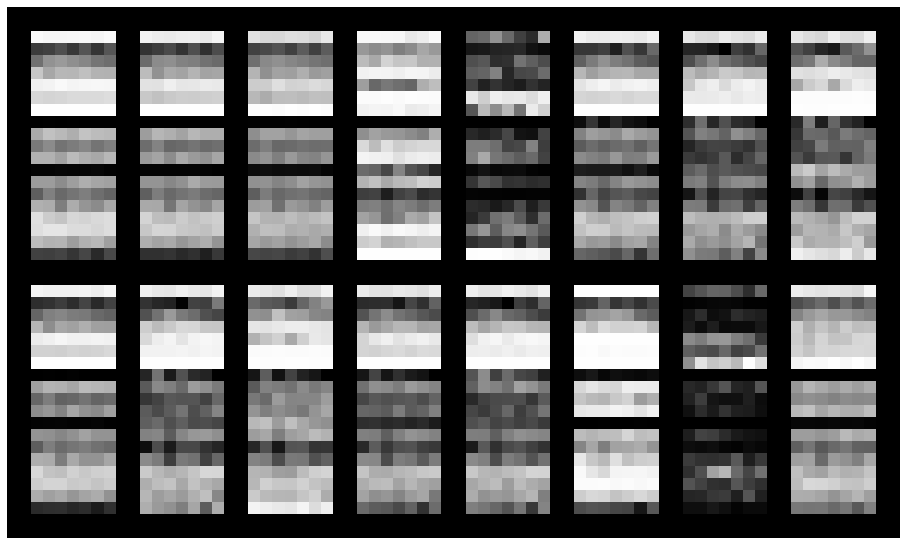

Epoch: [137/200], Batch Num: [0/54]
Discriminator Loss: 0.0188, Generator Loss: 6.1625
D(x): 0.9980, D(G(z)): 0.0052


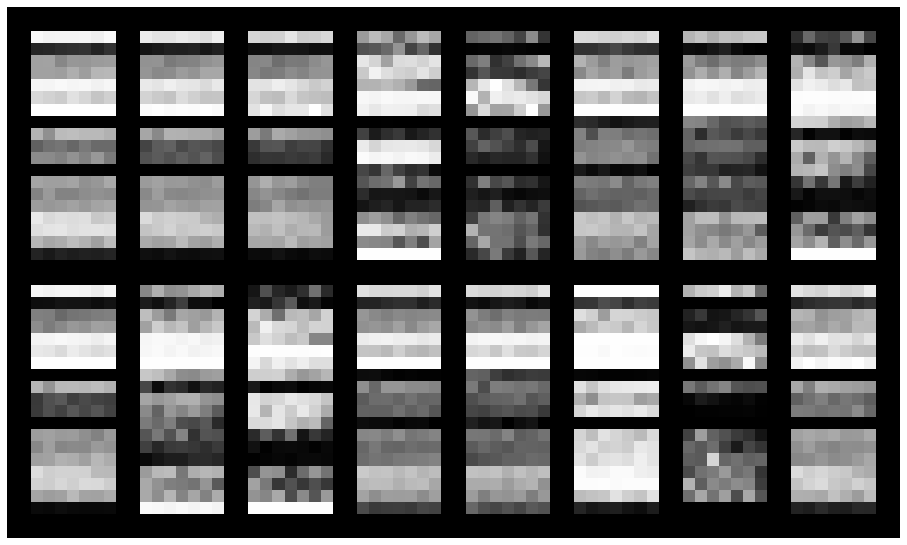

Epoch: [138/200], Batch Num: [0/54]
Discriminator Loss: 0.0318, Generator Loss: 6.1735
D(x): 0.9926, D(G(z)): 0.0064


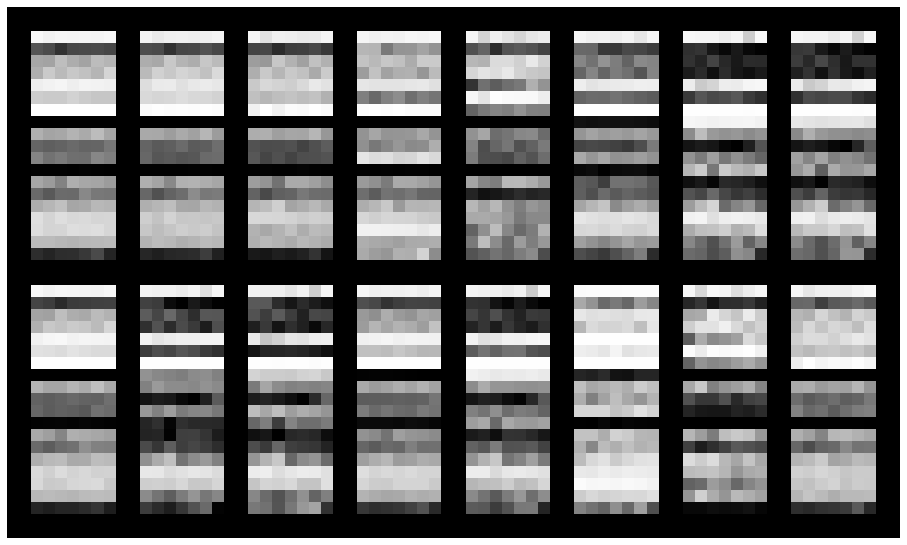

Epoch: [139/200], Batch Num: [0/54]
Discriminator Loss: 0.0036, Generator Loss: 6.7693
D(x): 0.9999, D(G(z)): 0.0033


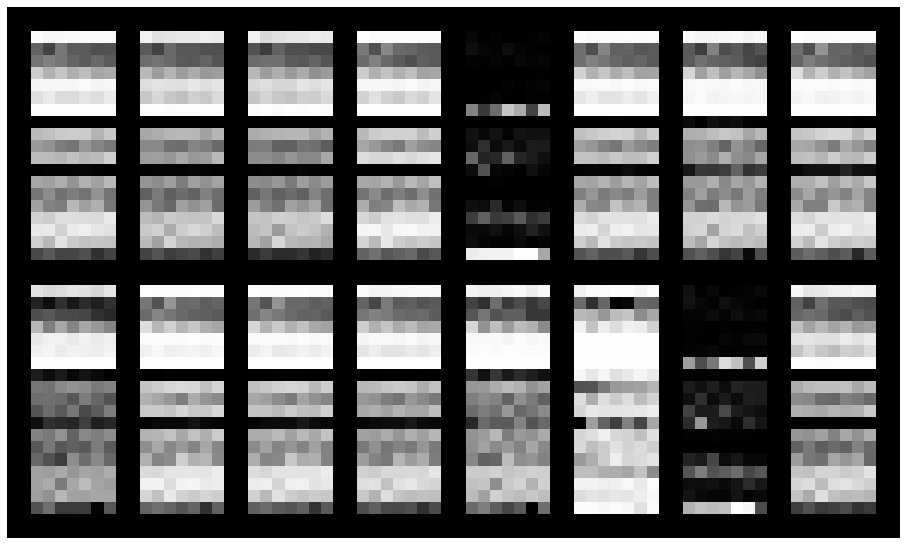

Epoch: [140/200], Batch Num: [0/54]
Discriminator Loss: 0.0346, Generator Loss: 6.4379
D(x): 0.9923, D(G(z)): 0.0031


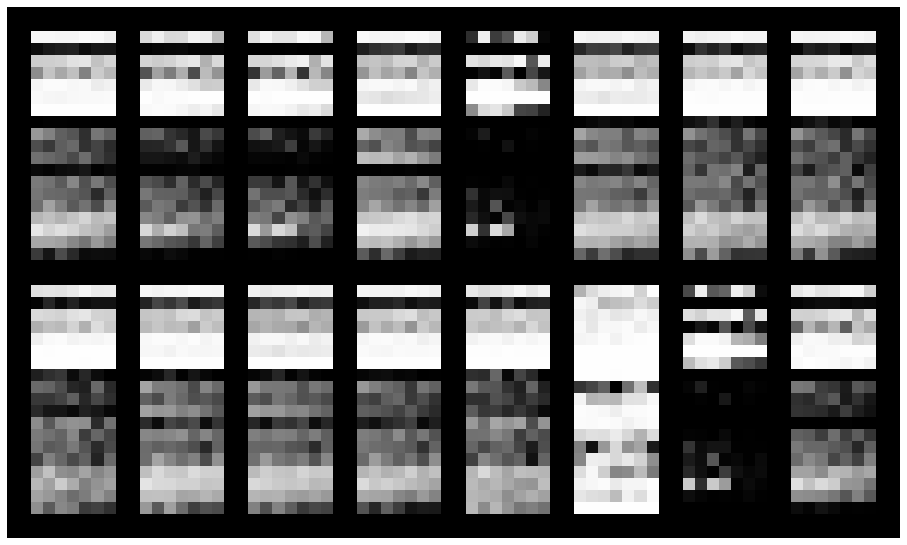

Epoch: [141/200], Batch Num: [0/54]
Discriminator Loss: 0.0376, Generator Loss: 6.6885
D(x): 0.9920, D(G(z)): 0.0034


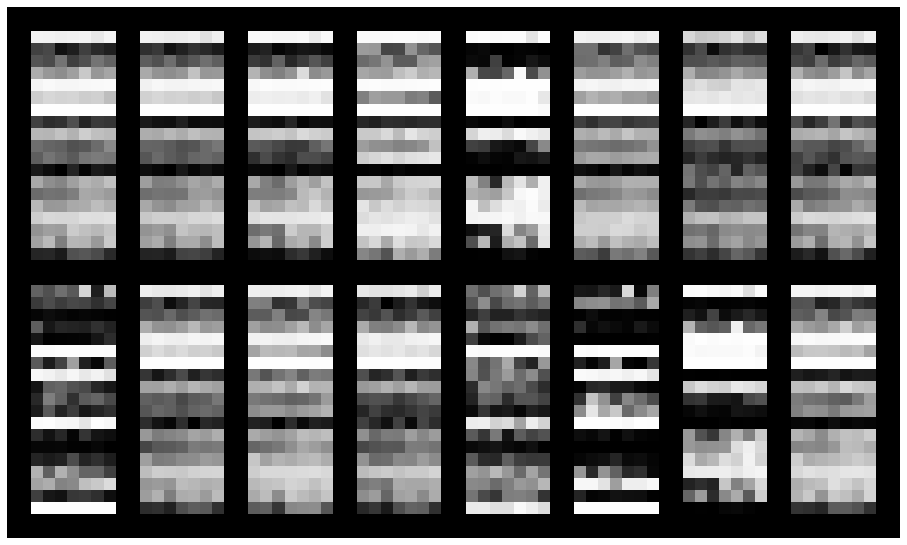

Epoch: [142/200], Batch Num: [0/54]
Discriminator Loss: 0.0223, Generator Loss: 6.0996
D(x): 0.9956, D(G(z)): 0.0069


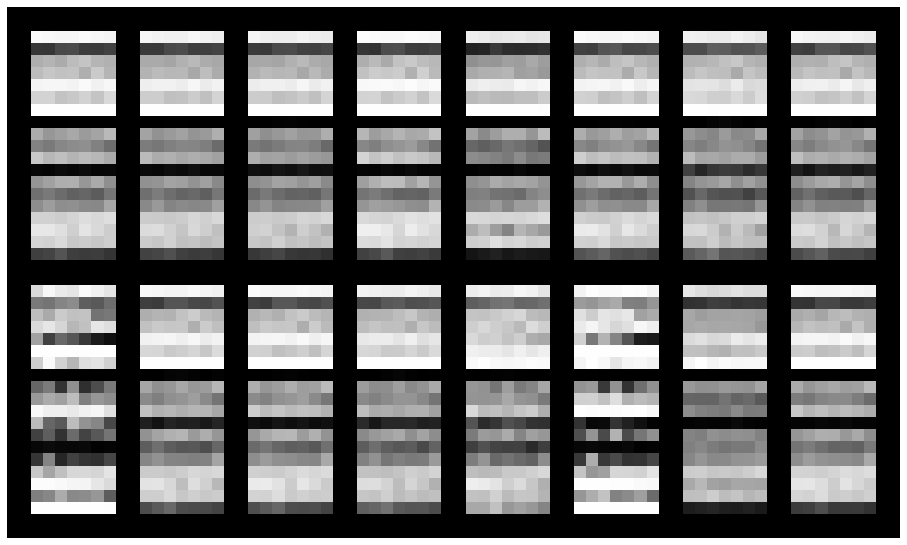

Epoch: [143/200], Batch Num: [0/54]
Discriminator Loss: 0.0155, Generator Loss: 6.2481
D(x): 0.9979, D(G(z)): 0.0031


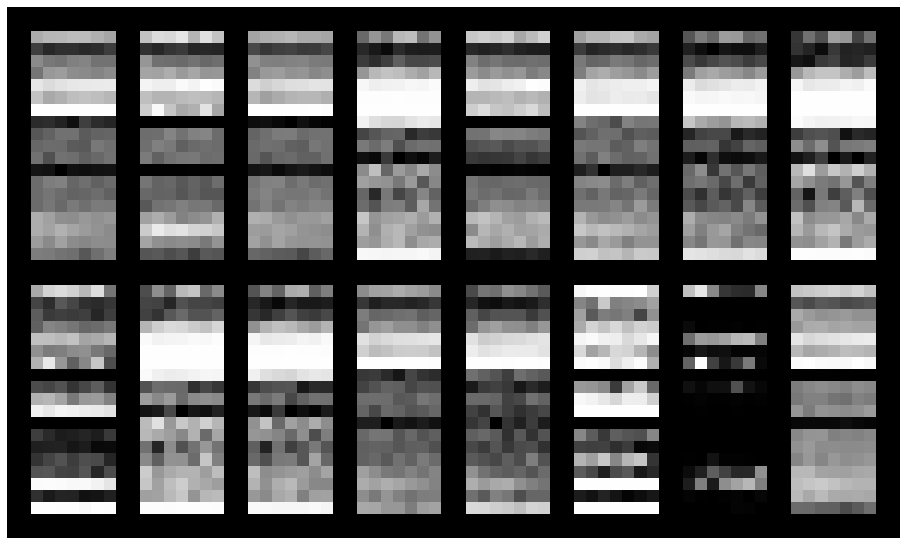

Epoch: [144/200], Batch Num: [0/54]
Discriminator Loss: 0.0058, Generator Loss: 7.4402
D(x): 0.9981, D(G(z)): 0.0034


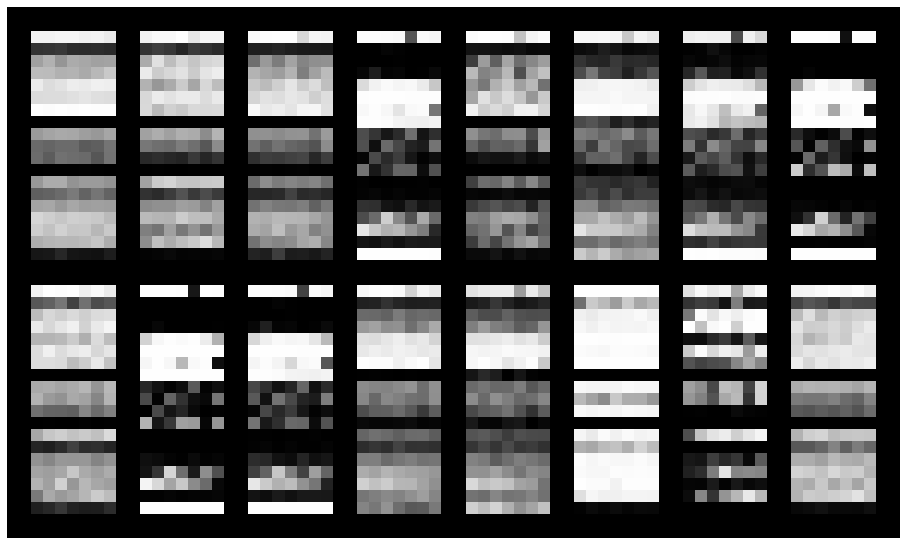

Epoch: [145/200], Batch Num: [0/54]
Discriminator Loss: 0.0429, Generator Loss: 6.6903
D(x): 0.9922, D(G(z)): 0.0032


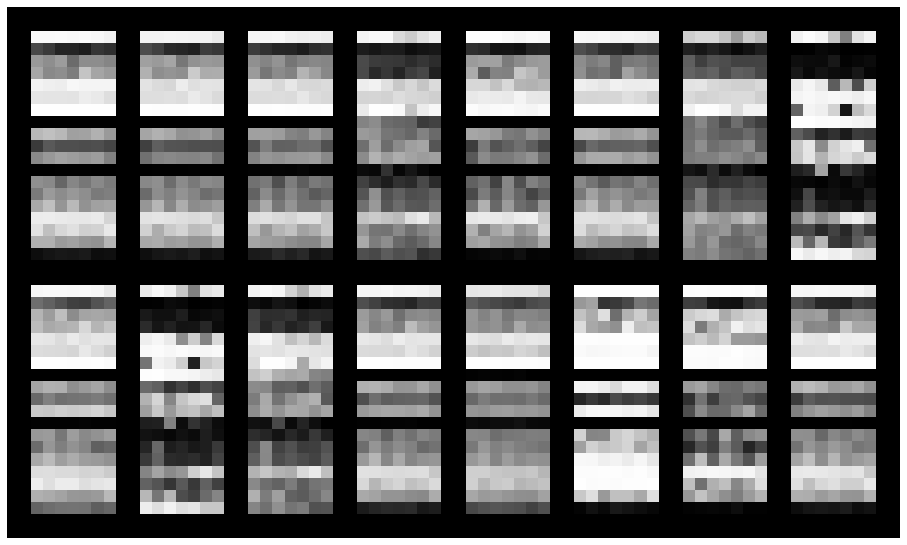

Epoch: [146/200], Batch Num: [0/54]
Discriminator Loss: 0.0045, Generator Loss: 6.2782
D(x): 1.0000, D(G(z)): 0.0045


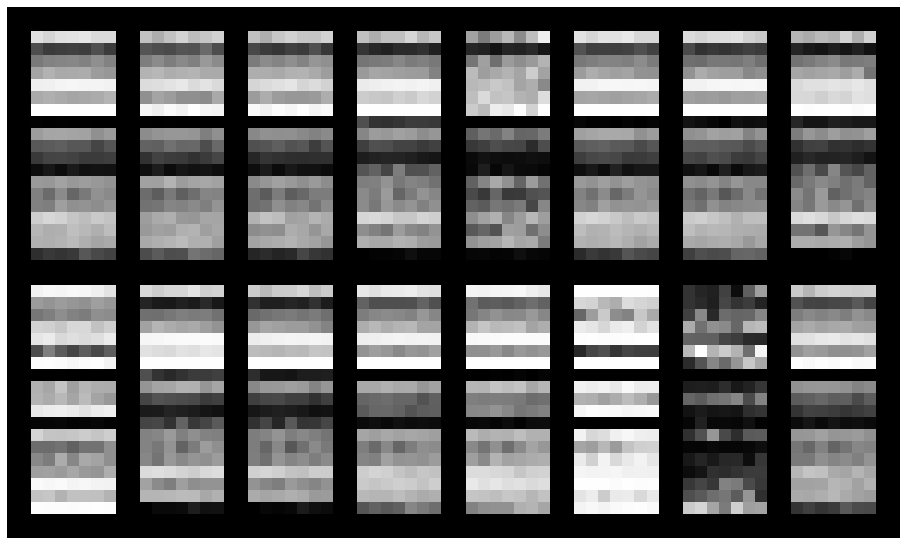

Epoch: [147/200], Batch Num: [0/54]
Discriminator Loss: 0.0295, Generator Loss: 5.5094
D(x): 0.9932, D(G(z)): 0.0064


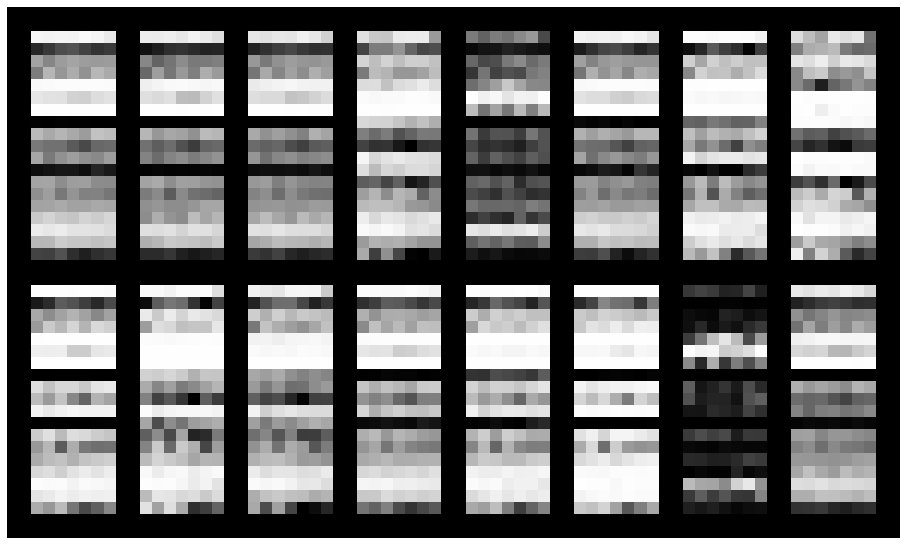

Epoch: [148/200], Batch Num: [0/54]
Discriminator Loss: 0.0265, Generator Loss: 6.2969
D(x): 0.9956, D(G(z)): 0.0062


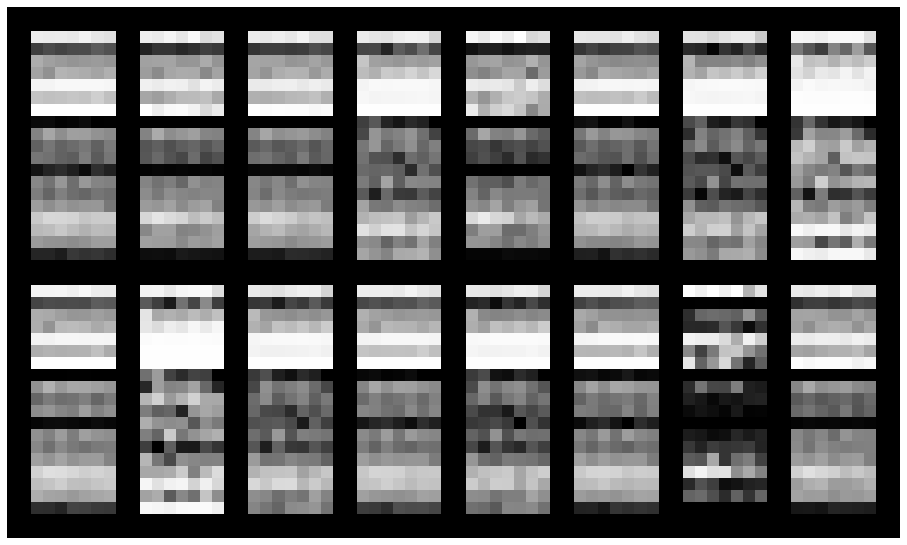

Epoch: [149/200], Batch Num: [0/54]
Discriminator Loss: 0.0029, Generator Loss: 6.4589
D(x): 0.9998, D(G(z)): 0.0027


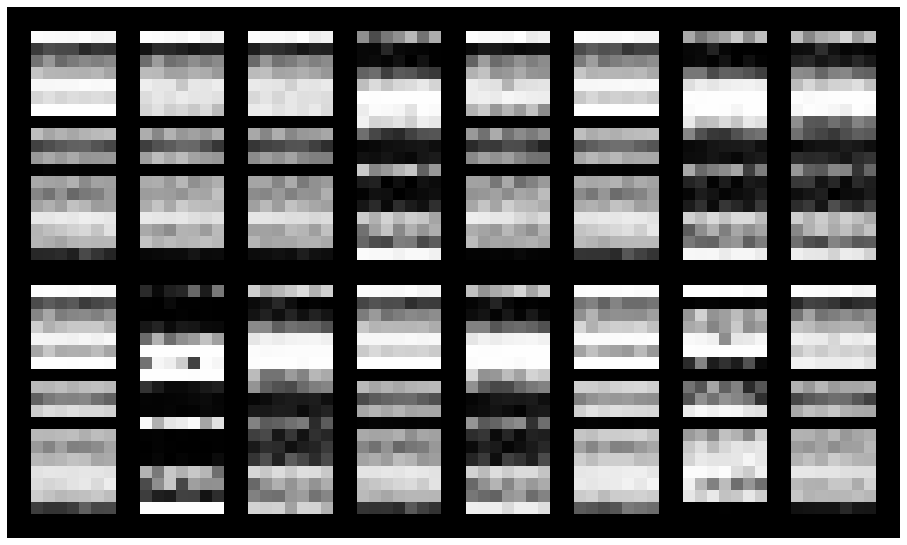

Epoch: [150/200], Batch Num: [0/54]
Discriminator Loss: 0.0065, Generator Loss: 7.5239
D(x): 0.9981, D(G(z)): 0.0011


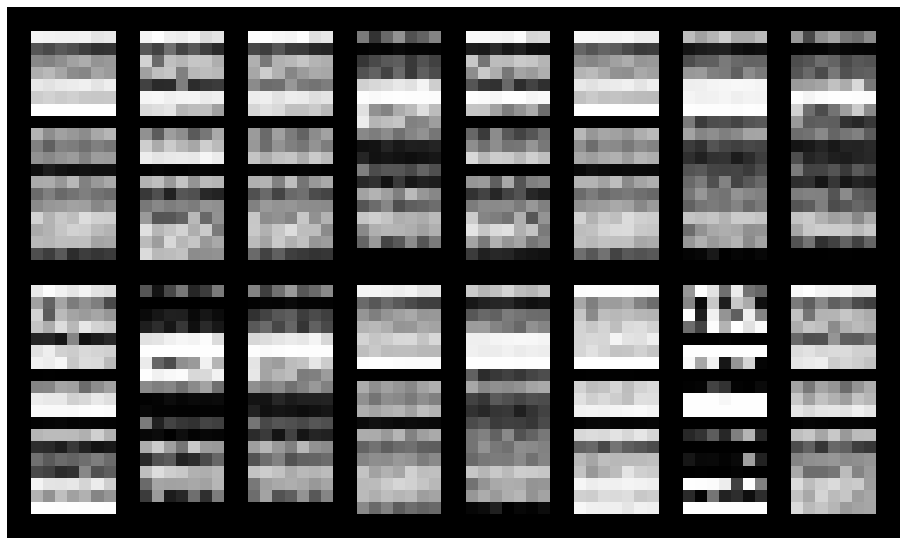

Epoch: [151/200], Batch Num: [0/54]
Discriminator Loss: 0.0325, Generator Loss: 6.2362
D(x): 0.9964, D(G(z)): 0.0113


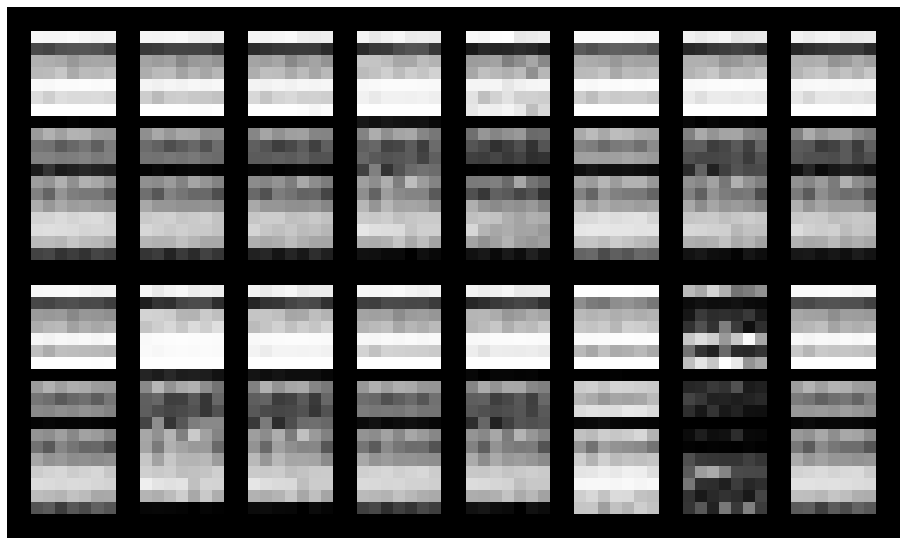

Epoch: [152/200], Batch Num: [0/54]
Discriminator Loss: 0.0459, Generator Loss: 6.2921
D(x): 0.9940, D(G(z)): 0.0046


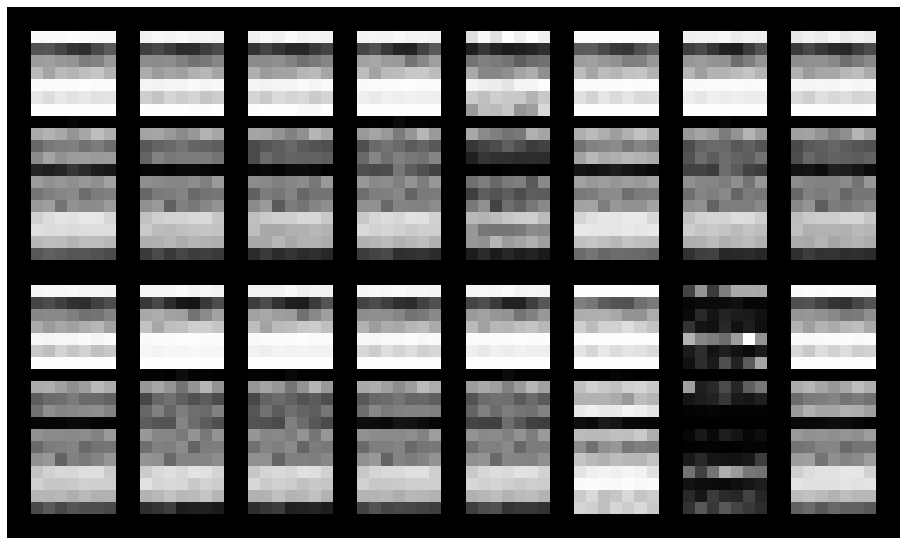

Epoch: [153/200], Batch Num: [0/54]
Discriminator Loss: 0.0252, Generator Loss: 6.1481
D(x): 0.9955, D(G(z)): 0.0053


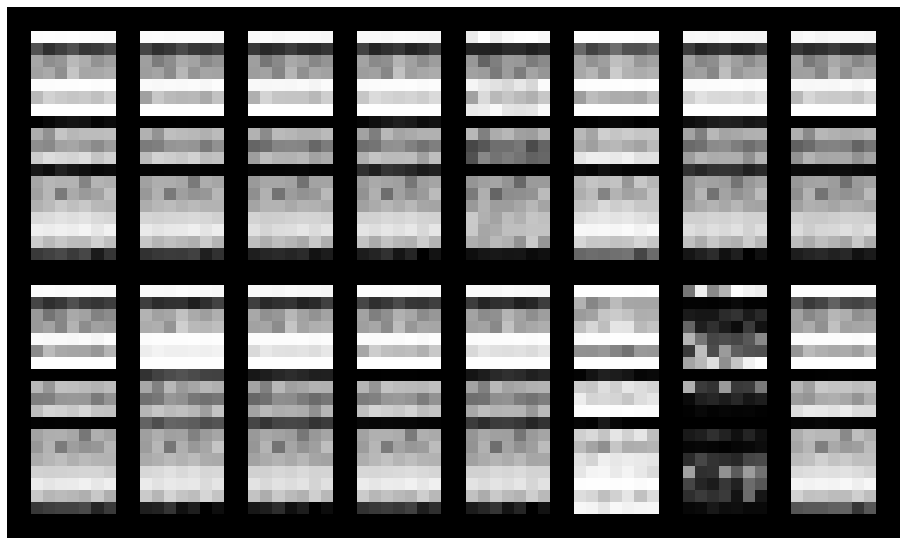

Epoch: [154/200], Batch Num: [0/54]
Discriminator Loss: 0.0044, Generator Loss: 6.8101
D(x): 0.9983, D(G(z)): 0.0018


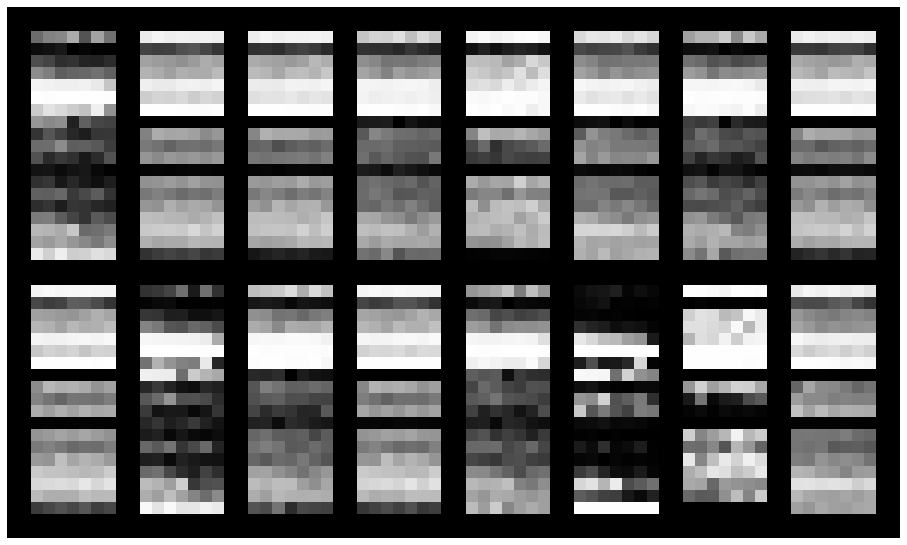

Epoch: [155/200], Batch Num: [0/54]
Discriminator Loss: 0.0334, Generator Loss: 6.3401
D(x): 0.9917, D(G(z)): 0.0034


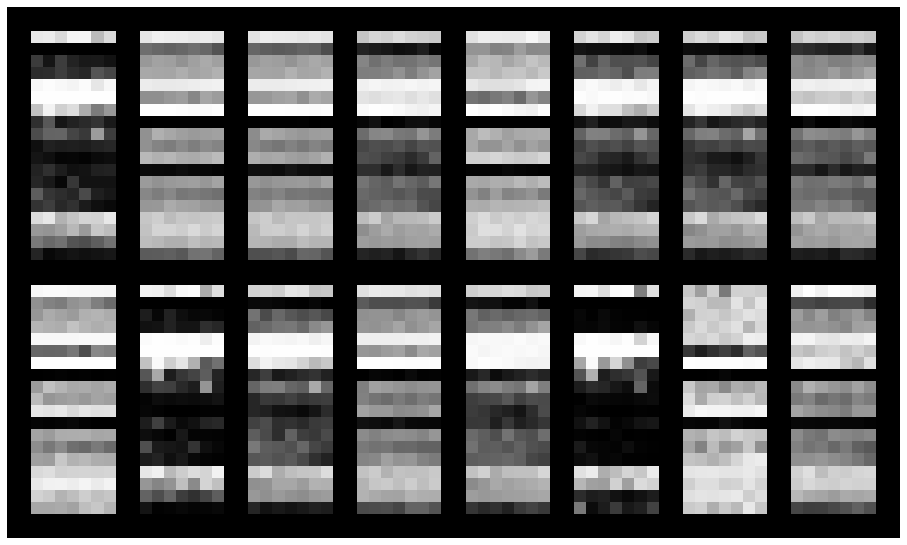

Epoch: [156/200], Batch Num: [0/54]
Discriminator Loss: 0.0065, Generator Loss: 5.9297
D(x): 0.9987, D(G(z)): 0.0046


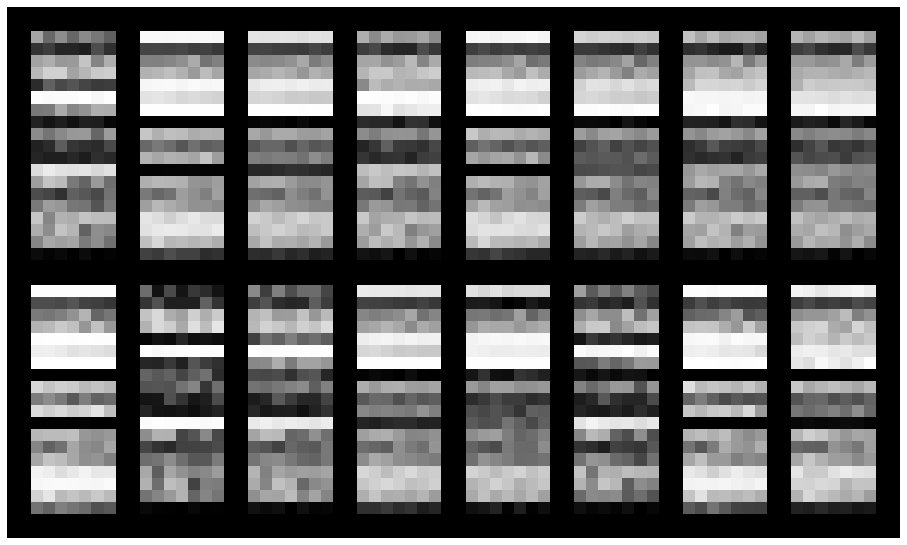

Epoch: [157/200], Batch Num: [0/54]
Discriminator Loss: 0.0455, Generator Loss: 7.5339
D(x): 0.9938, D(G(z)): 0.0040


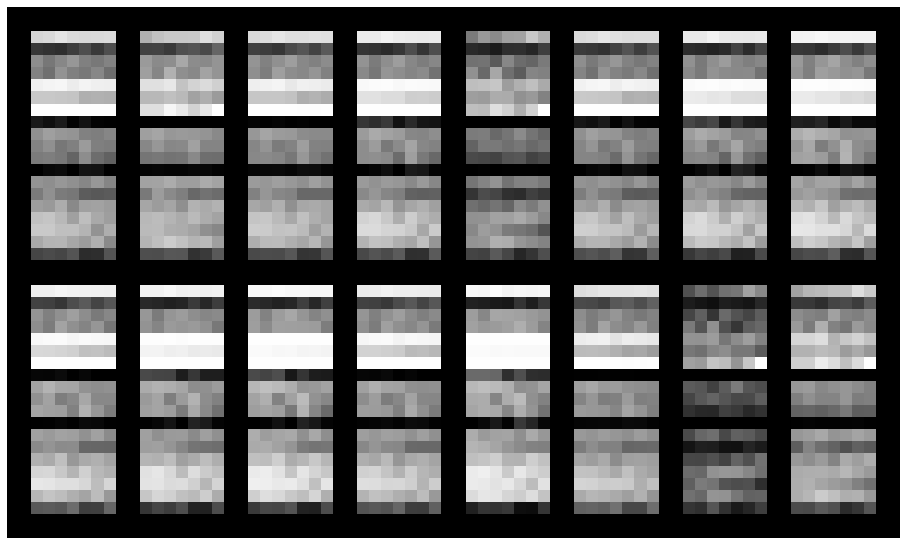

Epoch: [158/200], Batch Num: [0/54]
Discriminator Loss: 0.0153, Generator Loss: 5.8823
D(x): 0.9979, D(G(z)): 0.0045


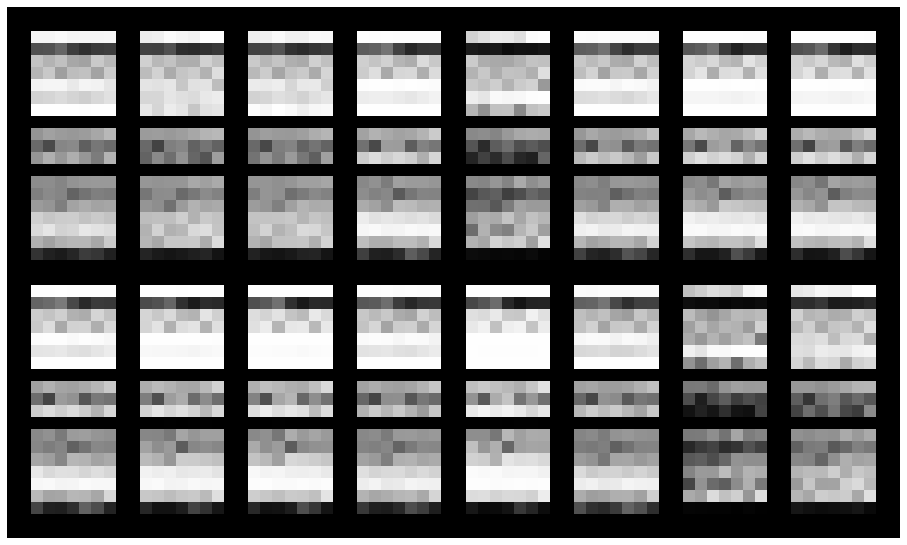

Epoch: [159/200], Batch Num: [0/54]
Discriminator Loss: 0.0463, Generator Loss: 5.7883
D(x): 0.9937, D(G(z)): 0.0068


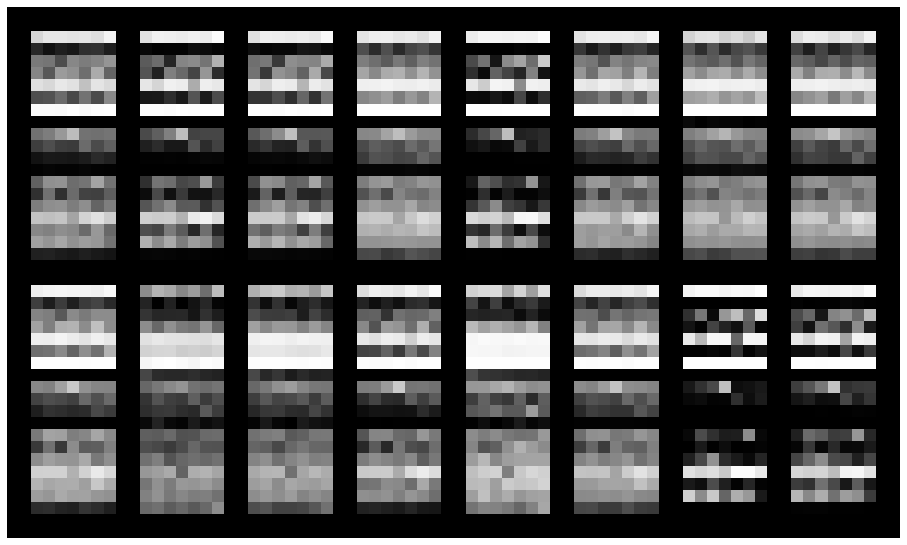

Epoch: [160/200], Batch Num: [0/54]
Discriminator Loss: 0.0232, Generator Loss: 7.0658
D(x): 0.9961, D(G(z)): 0.0035


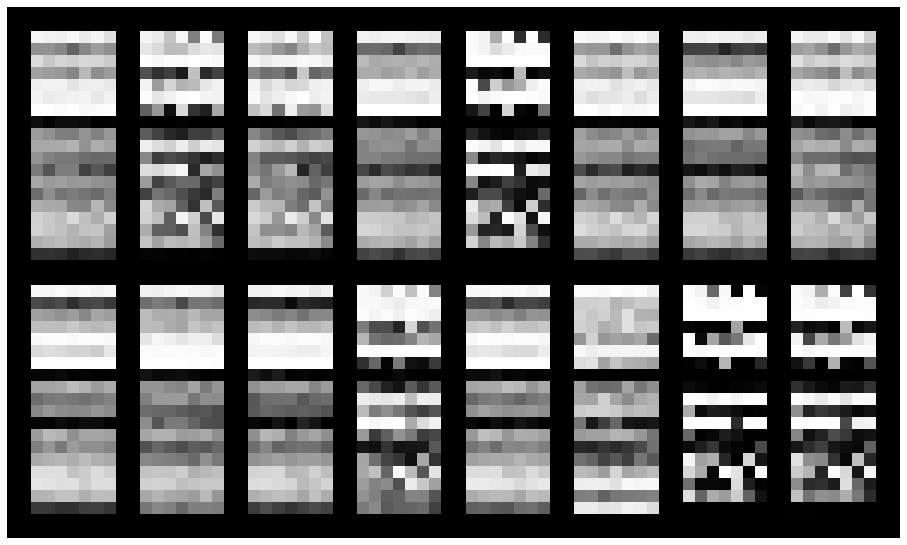

Epoch: [161/200], Batch Num: [0/54]
Discriminator Loss: 0.0137, Generator Loss: 7.6073
D(x): 0.9966, D(G(z)): 0.0018


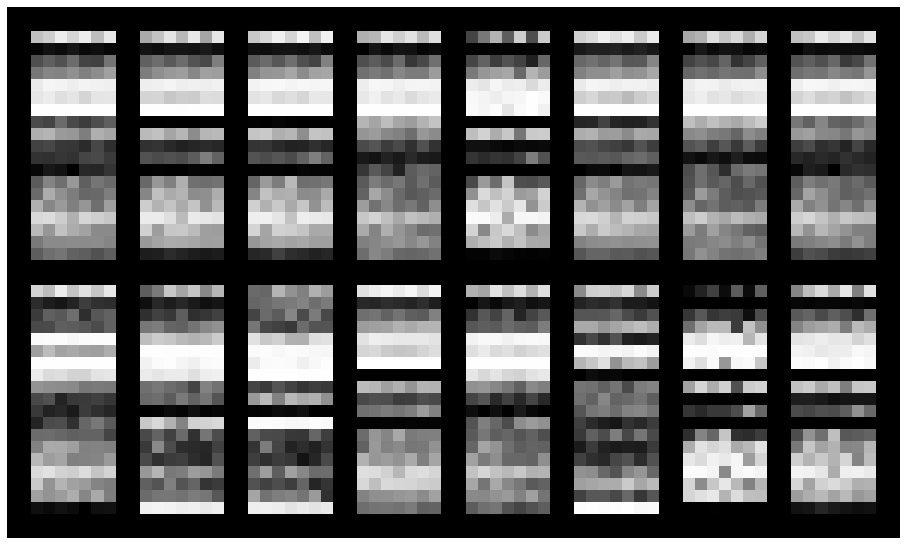

Epoch: [162/200], Batch Num: [0/54]
Discriminator Loss: 0.0382, Generator Loss: 7.4737
D(x): 0.9918, D(G(z)): 0.0037


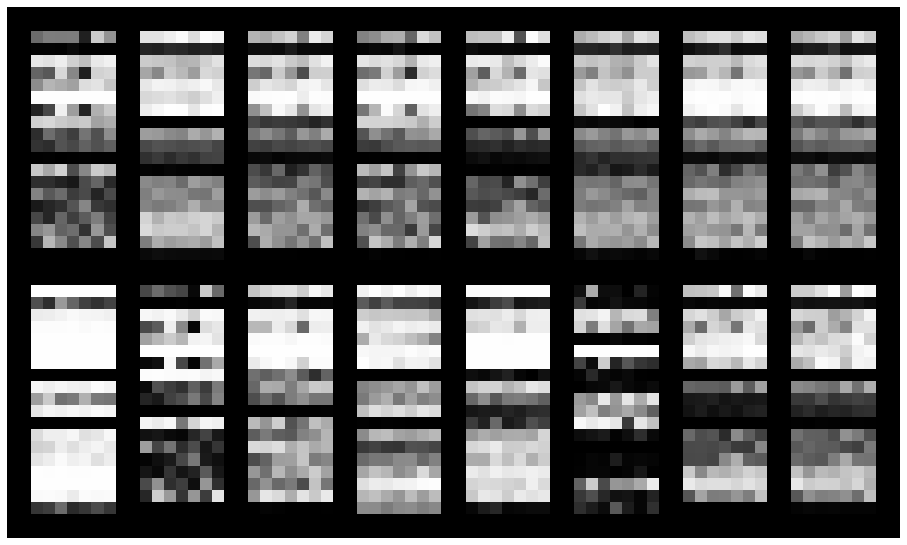

Epoch: [163/200], Batch Num: [0/54]
Discriminator Loss: 0.0331, Generator Loss: 6.6373
D(x): 0.9904, D(G(z)): 0.0055


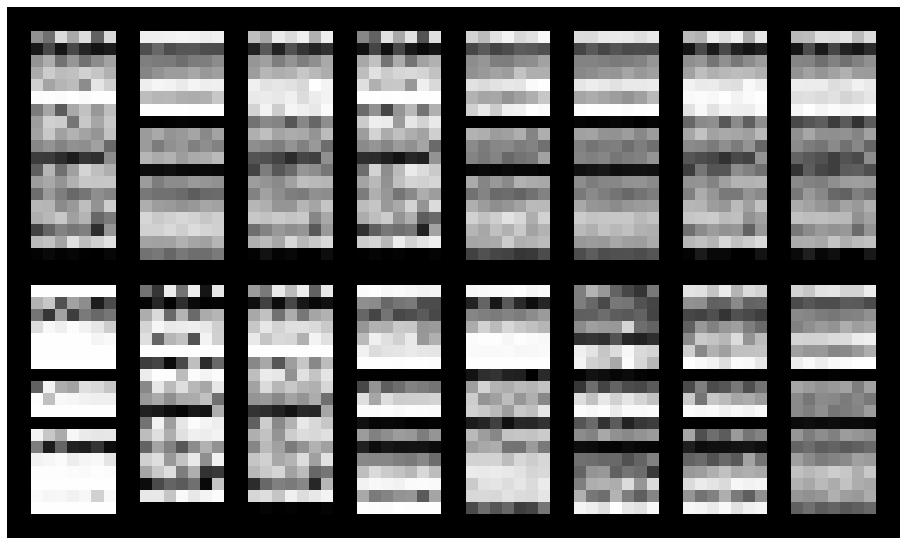

Epoch: [164/200], Batch Num: [0/54]
Discriminator Loss: 0.0294, Generator Loss: 6.3699
D(x): 0.9943, D(G(z)): 0.0084


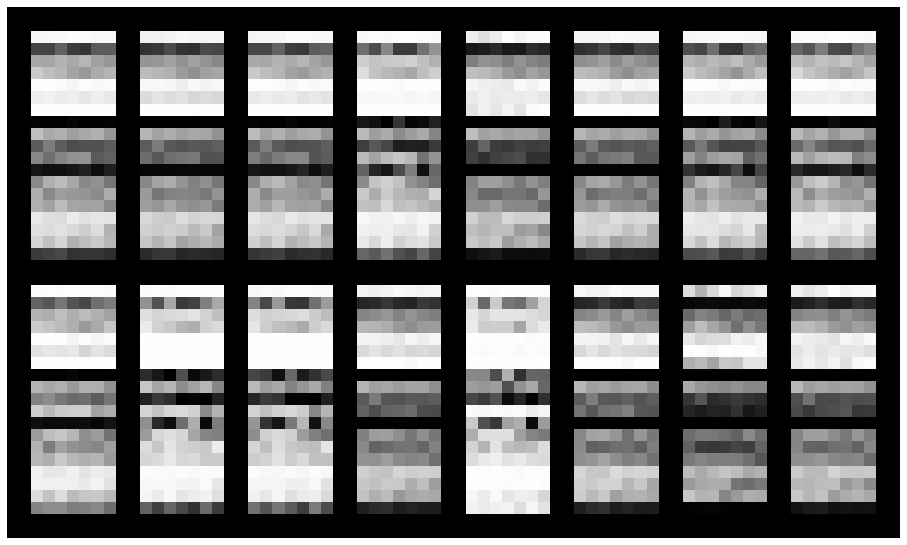

Epoch: [165/200], Batch Num: [0/54]
Discriminator Loss: 0.0208, Generator Loss: 6.3836
D(x): 0.9978, D(G(z)): 0.0067


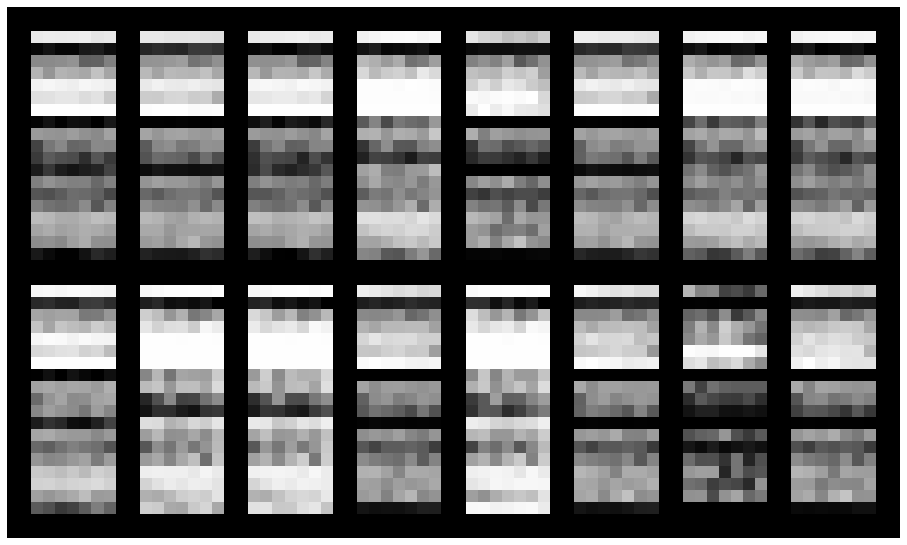

Epoch: [166/200], Batch Num: [0/54]
Discriminator Loss: 0.0356, Generator Loss: 6.1091
D(x): 0.9919, D(G(z)): 0.0059


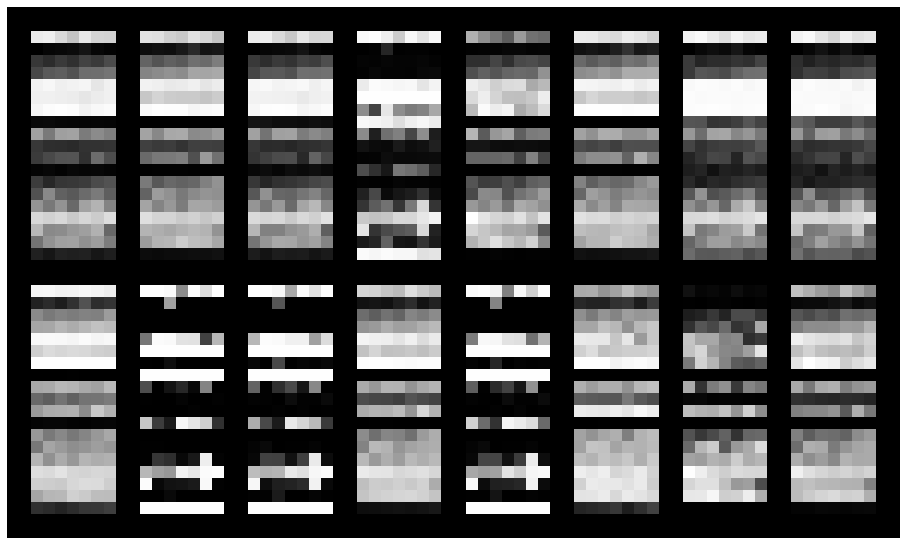

Epoch: [167/200], Batch Num: [0/54]
Discriminator Loss: 0.0429, Generator Loss: 6.4063
D(x): 0.9891, D(G(z)): 0.0029


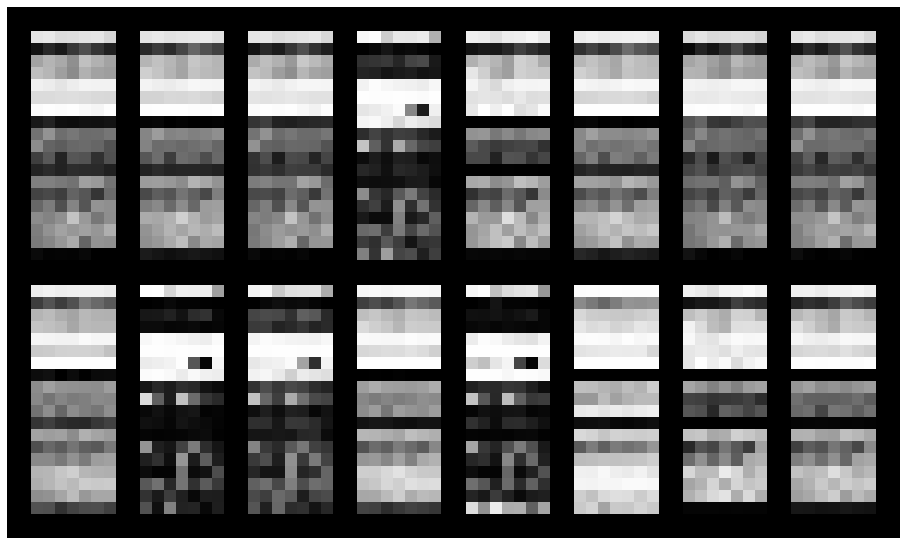

Epoch: [168/200], Batch Num: [0/54]
Discriminator Loss: 0.0273, Generator Loss: 5.9020
D(x): 0.9943, D(G(z)): 0.0044


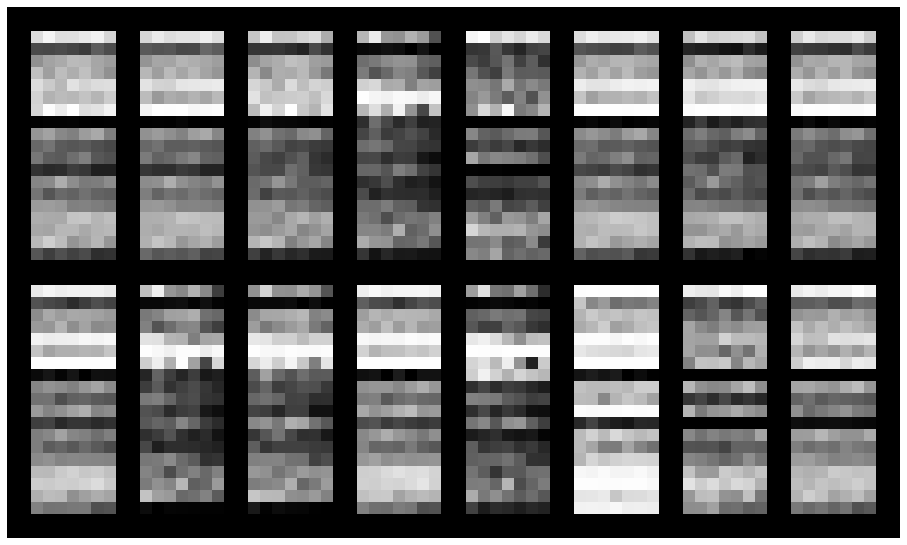

Epoch: [169/200], Batch Num: [0/54]
Discriminator Loss: 0.0121, Generator Loss: 6.3719
D(x): 0.9976, D(G(z)): 0.0056


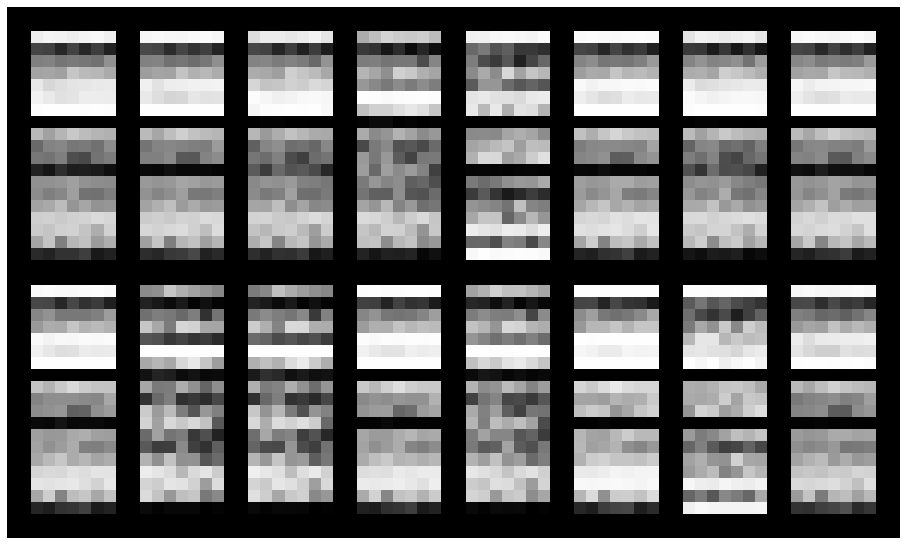

Epoch: [170/200], Batch Num: [0/54]
Discriminator Loss: 0.0777, Generator Loss: 6.1546
D(x): 0.9859, D(G(z)): 0.0030


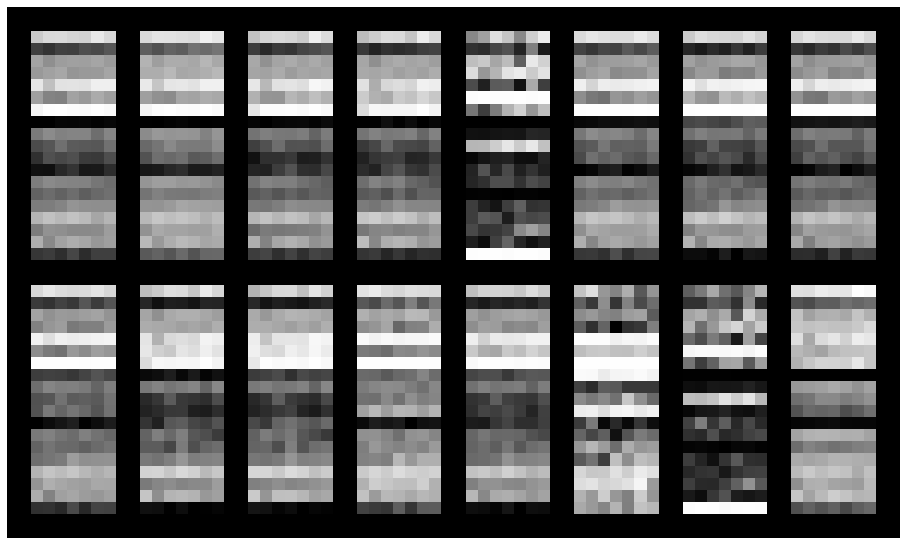

Epoch: [171/200], Batch Num: [0/54]
Discriminator Loss: 0.0622, Generator Loss: 6.5348
D(x): 0.9932, D(G(z)): 0.0159


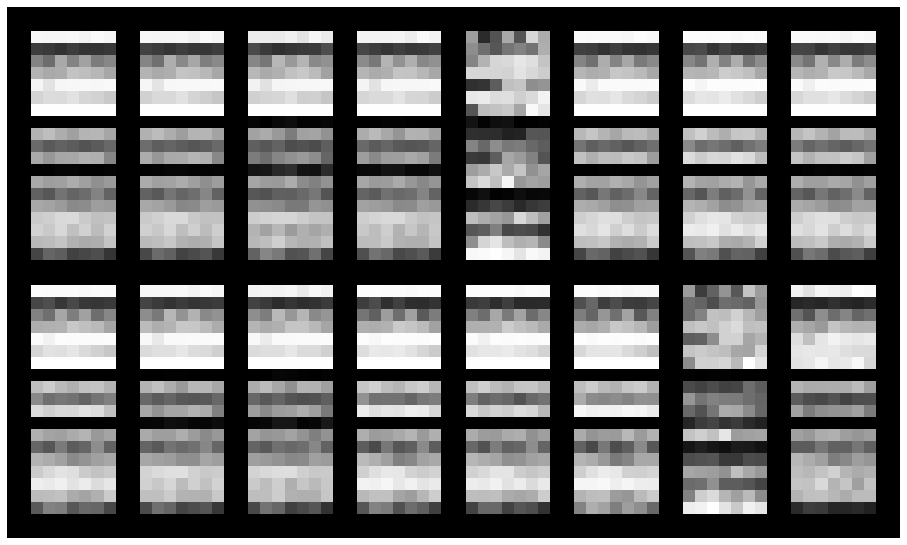

Epoch: [172/200], Batch Num: [0/54]
Discriminator Loss: 0.0470, Generator Loss: 5.7228
D(x): 0.9920, D(G(z)): 0.0058


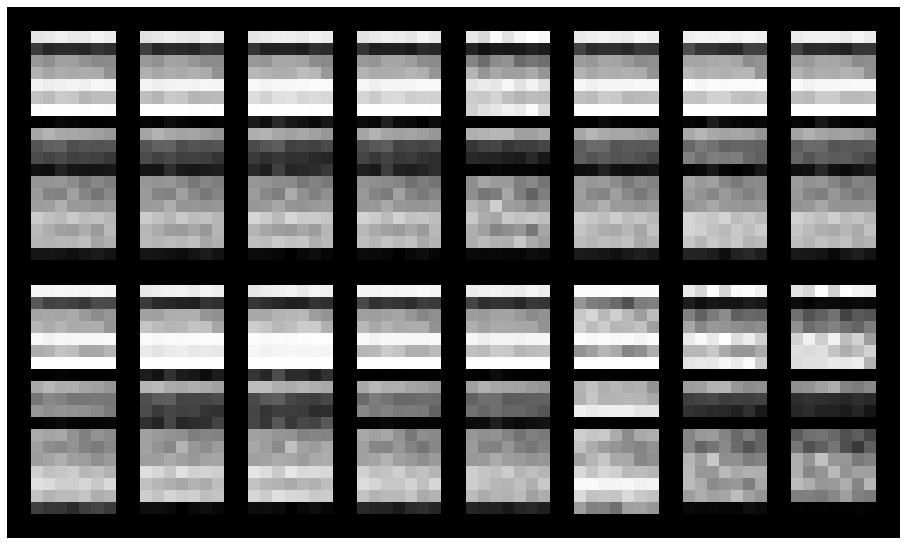

Epoch: [173/200], Batch Num: [0/54]
Discriminator Loss: 0.0023, Generator Loss: 6.9370
D(x): 0.9996, D(G(z)): 0.0018


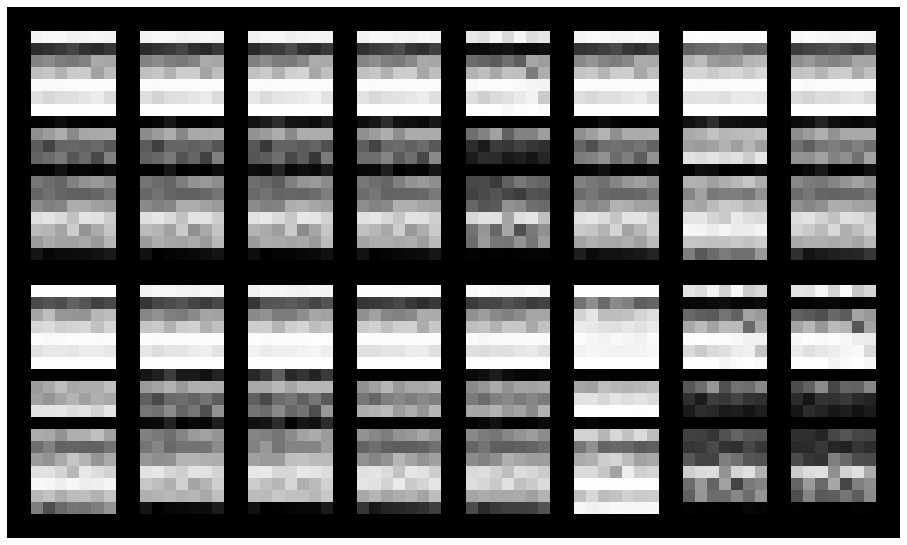

Epoch: [174/200], Batch Num: [0/54]
Discriminator Loss: 0.0331, Generator Loss: 6.0718
D(x): 0.9930, D(G(z)): 0.0054


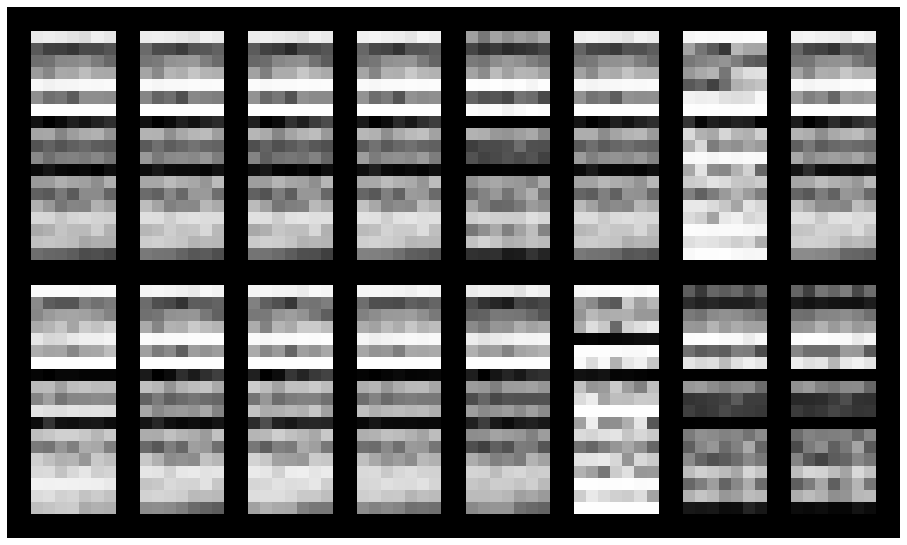

Epoch: [175/200], Batch Num: [0/54]
Discriminator Loss: 0.0018, Generator Loss: 7.2994
D(x): 1.0000, D(G(z)): 0.0018


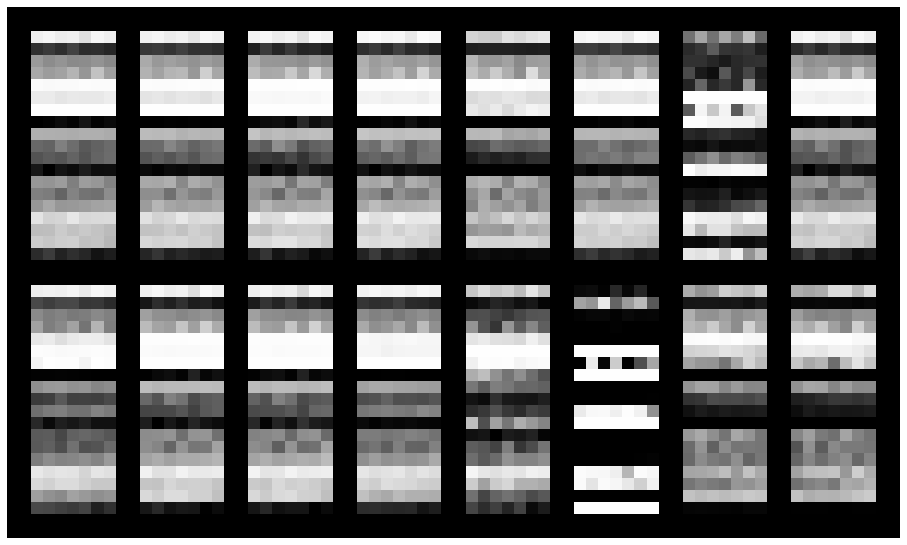

Epoch: [176/200], Batch Num: [0/54]
Discriminator Loss: 0.0695, Generator Loss: 6.5679
D(x): 0.9918, D(G(z)): 0.0092


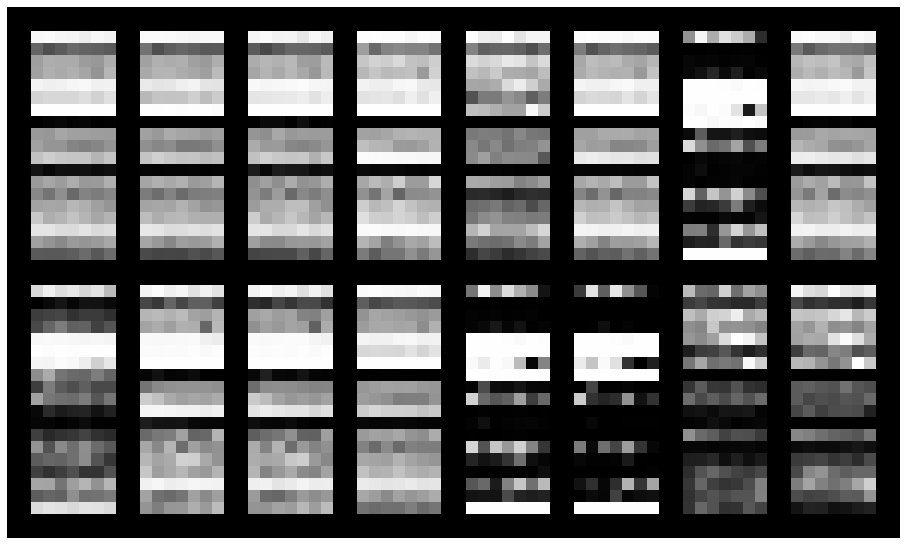

Epoch: [177/200], Batch Num: [0/54]
Discriminator Loss: 0.0141, Generator Loss: 6.3306
D(x): 0.9962, D(G(z)): 0.0046


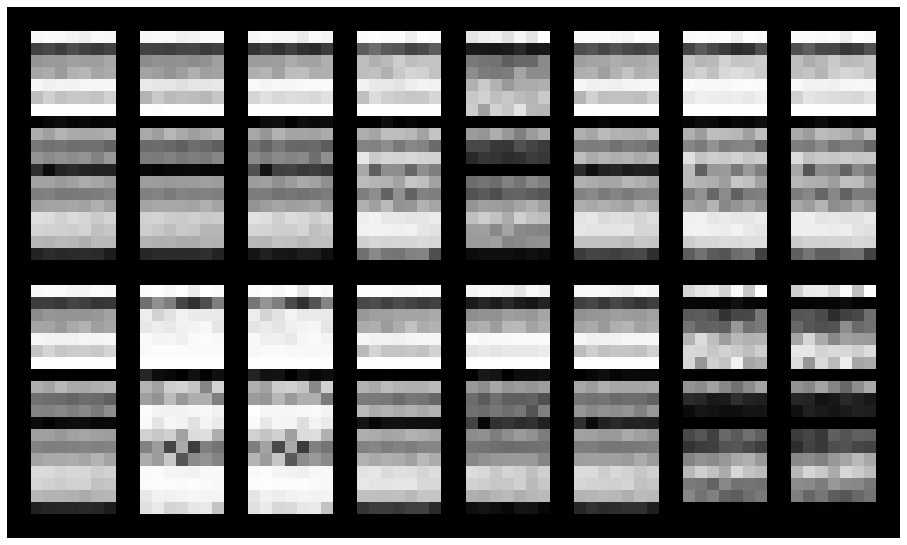

Epoch: [178/200], Batch Num: [0/54]
Discriminator Loss: 0.0222, Generator Loss: 5.9830
D(x): 0.9945, D(G(z)): 0.0035


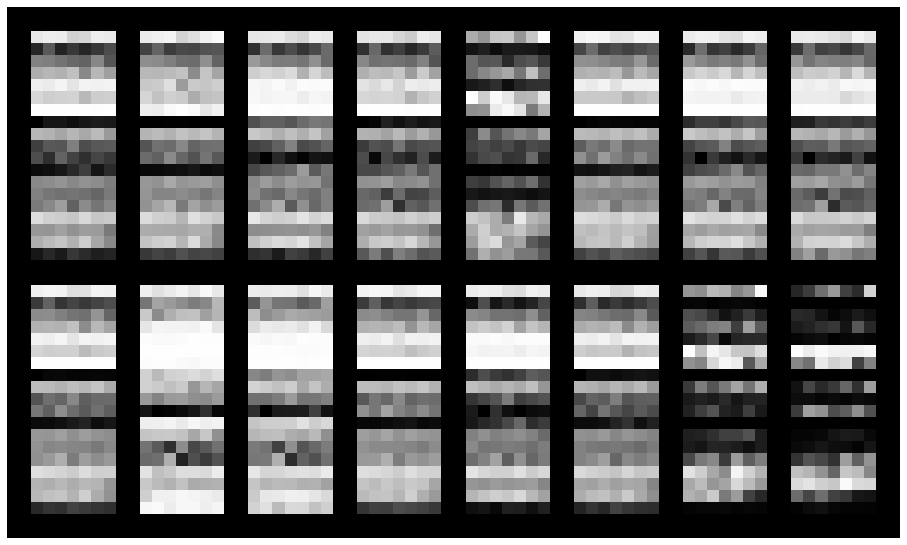

Epoch: [179/200], Batch Num: [0/54]
Discriminator Loss: 0.0700, Generator Loss: 6.3485
D(x): 0.9873, D(G(z)): 0.0092


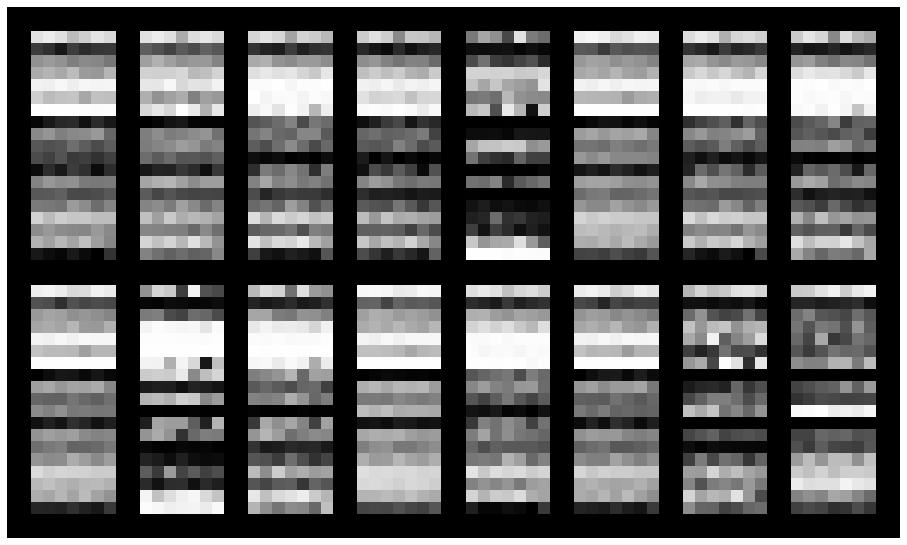

Epoch: [180/200], Batch Num: [0/54]
Discriminator Loss: 0.0676, Generator Loss: 6.9776
D(x): 0.9864, D(G(z)): 0.0021


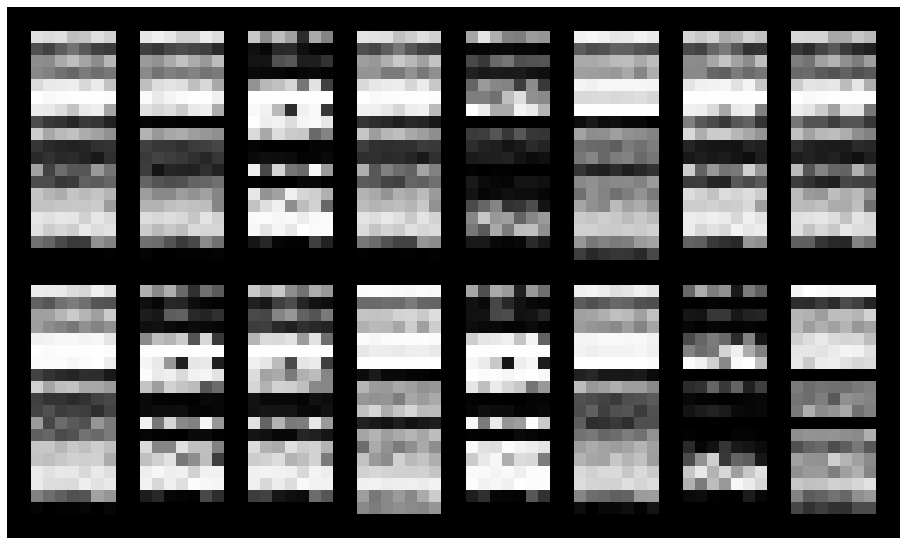

Epoch: [181/200], Batch Num: [0/54]
Discriminator Loss: 0.0642, Generator Loss: 7.7552
D(x): 0.9903, D(G(z)): 0.0045


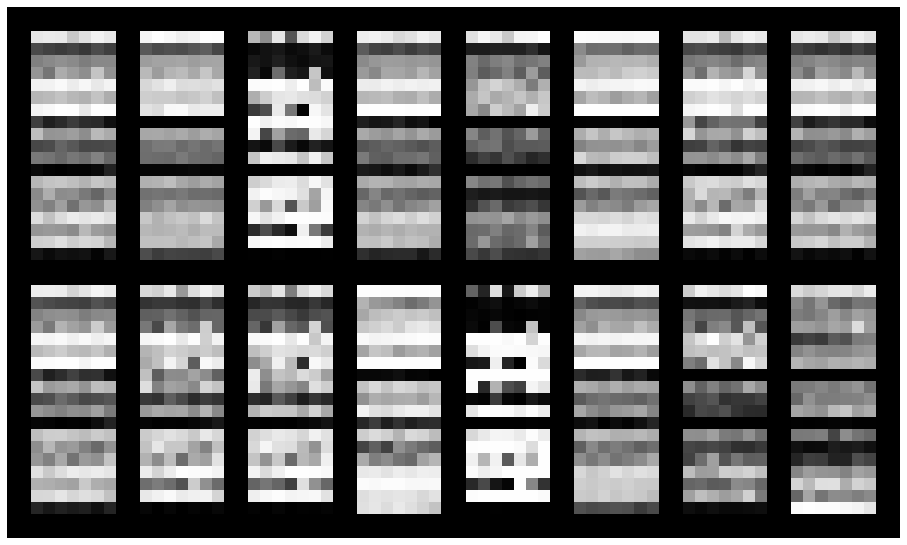

Epoch: [182/200], Batch Num: [0/54]
Discriminator Loss: 0.0049, Generator Loss: 7.0227
D(x): 0.9999, D(G(z)): 0.0046


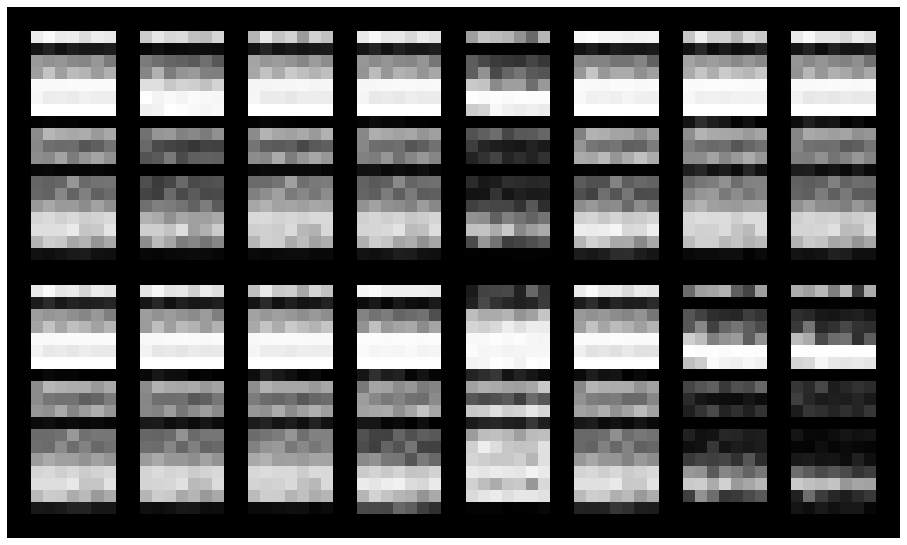

Epoch: [183/200], Batch Num: [0/54]
Discriminator Loss: 0.0297, Generator Loss: 6.9343
D(x): 0.9942, D(G(z)): 0.0040


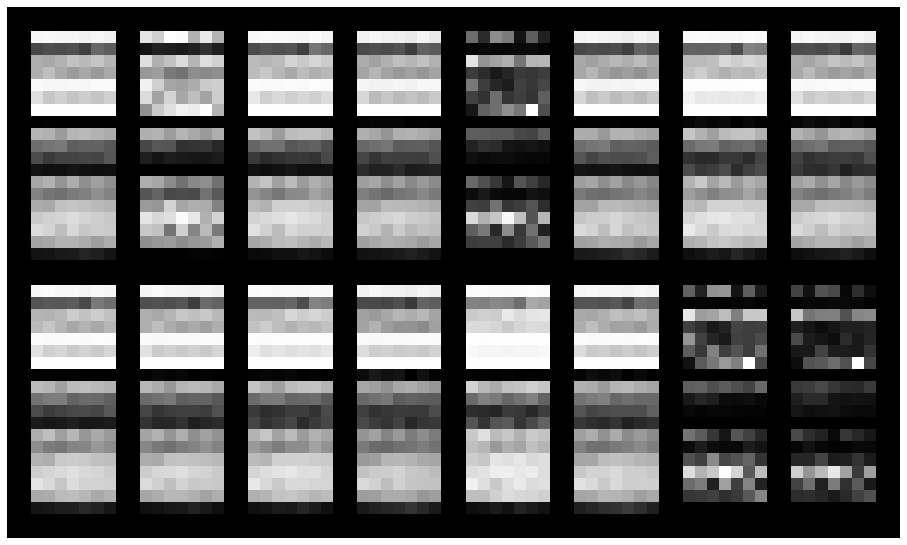

Epoch: [184/200], Batch Num: [0/54]
Discriminator Loss: 0.0186, Generator Loss: 6.1565
D(x): 0.9951, D(G(z)): 0.0036


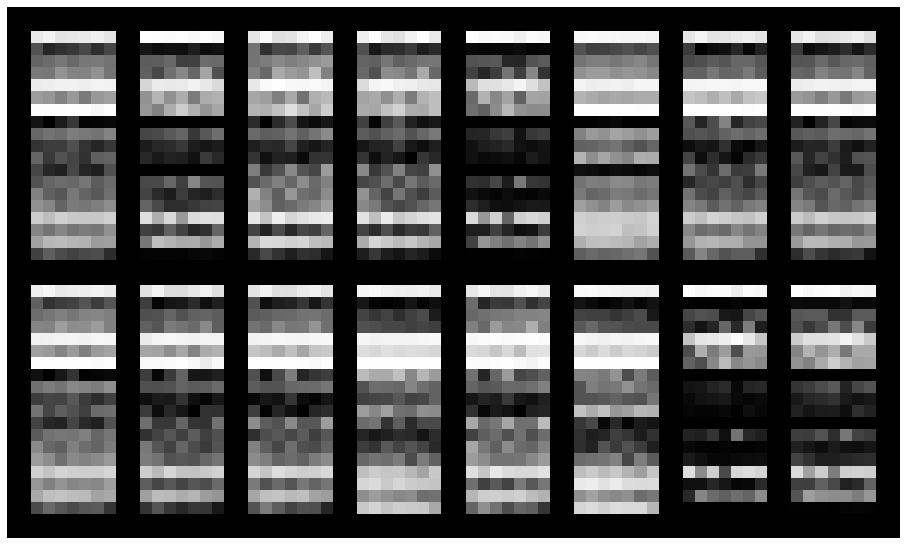

Epoch: [185/200], Batch Num: [0/54]
Discriminator Loss: 0.0421, Generator Loss: 6.6481
D(x): 0.9925, D(G(z)): 0.0034


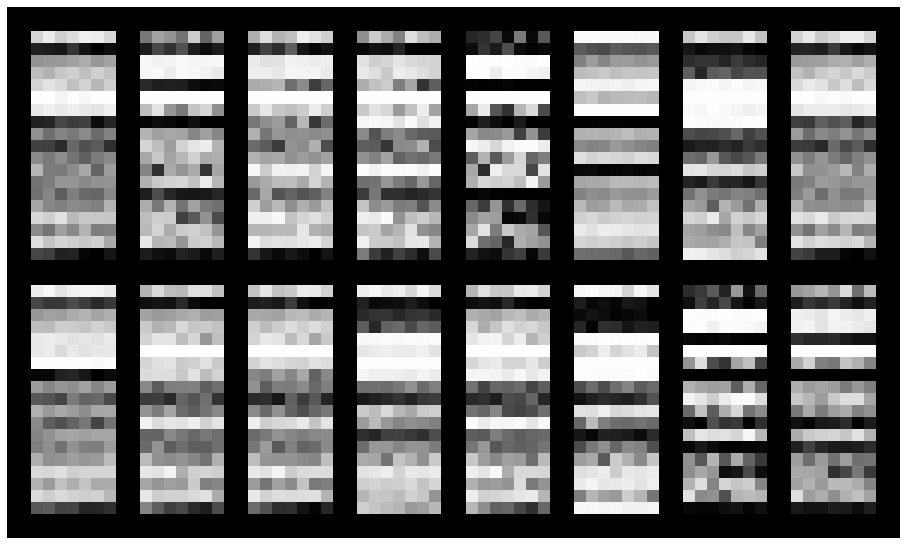

Epoch: [186/200], Batch Num: [0/54]
Discriminator Loss: 0.0216, Generator Loss: 6.8395
D(x): 0.9966, D(G(z)): 0.0102


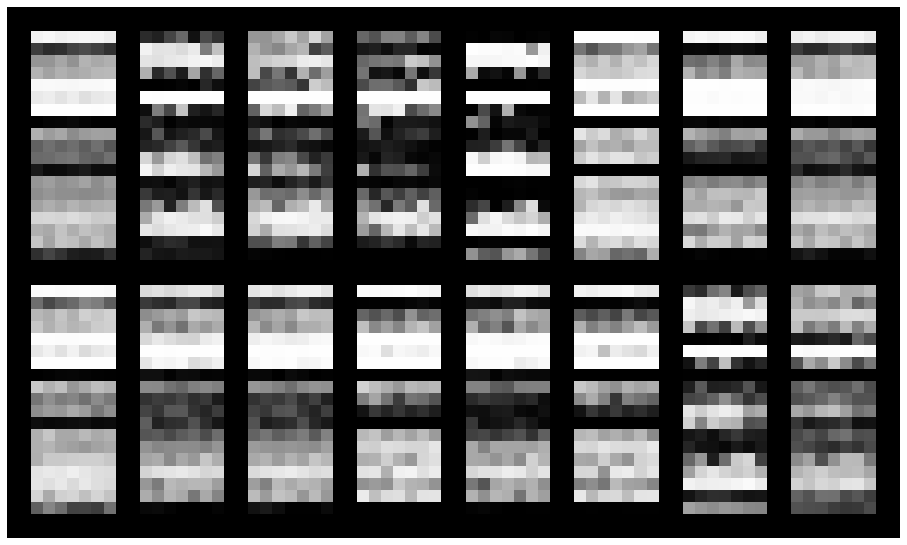

Epoch: [187/200], Batch Num: [0/54]
Discriminator Loss: 0.0112, Generator Loss: 7.0735
D(x): 0.9994, D(G(z)): 0.0065


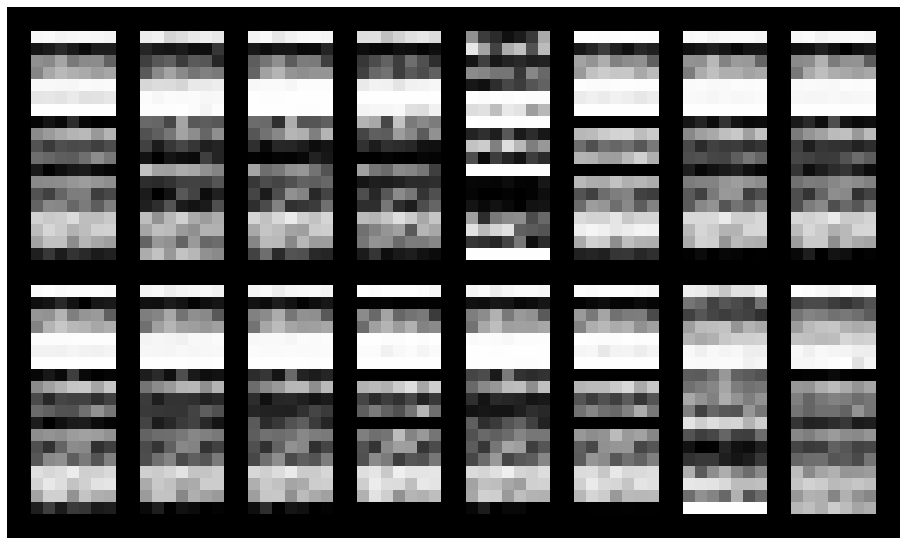

Epoch: [188/200], Batch Num: [0/54]
Discriminator Loss: 0.0038, Generator Loss: 6.7790
D(x): 0.9990, D(G(z)): 0.0024


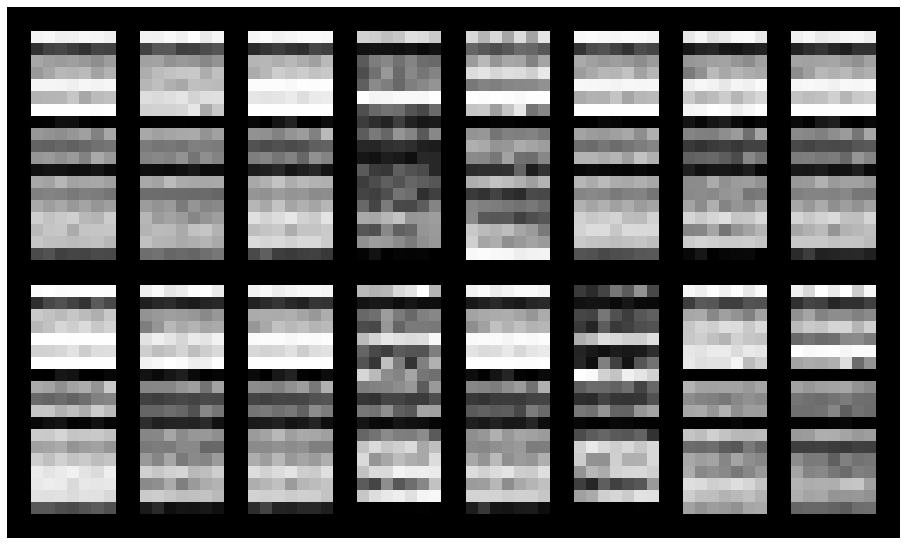

Epoch: [189/200], Batch Num: [0/54]
Discriminator Loss: 0.0209, Generator Loss: 5.1904
D(x): 0.9955, D(G(z)): 0.0096


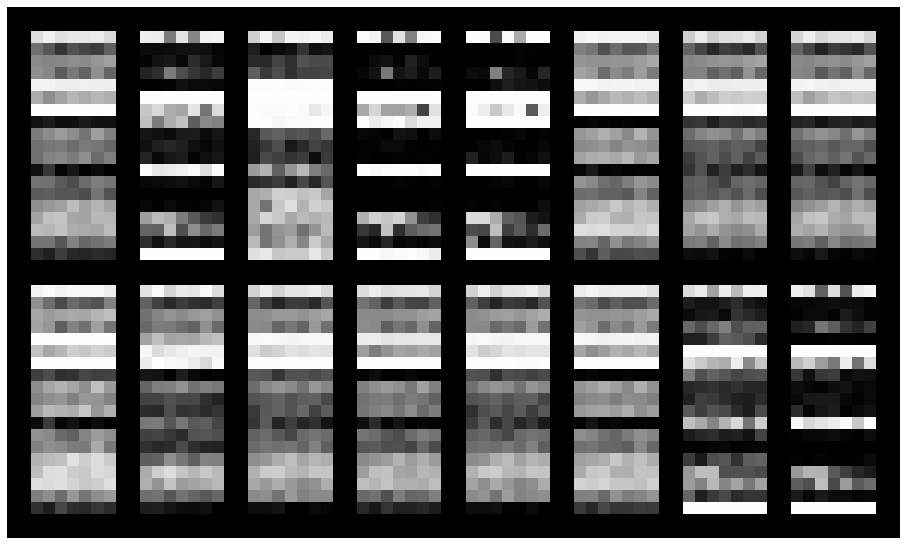

Epoch: [190/200], Batch Num: [0/54]
Discriminator Loss: 0.0278, Generator Loss: 6.8955
D(x): 0.9922, D(G(z)): 0.0028


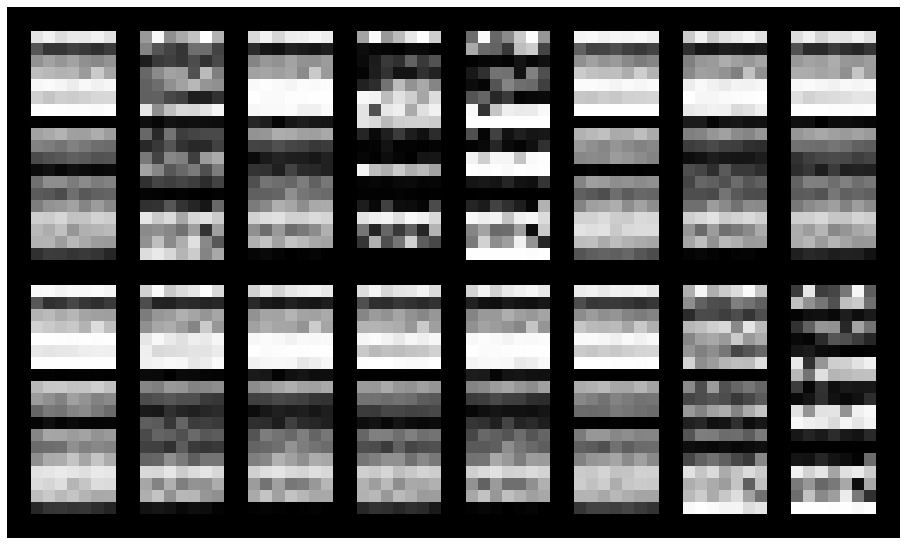

Epoch: [191/200], Batch Num: [0/54]
Discriminator Loss: 0.0512, Generator Loss: 6.1611
D(x): 0.9937, D(G(z)): 0.0096


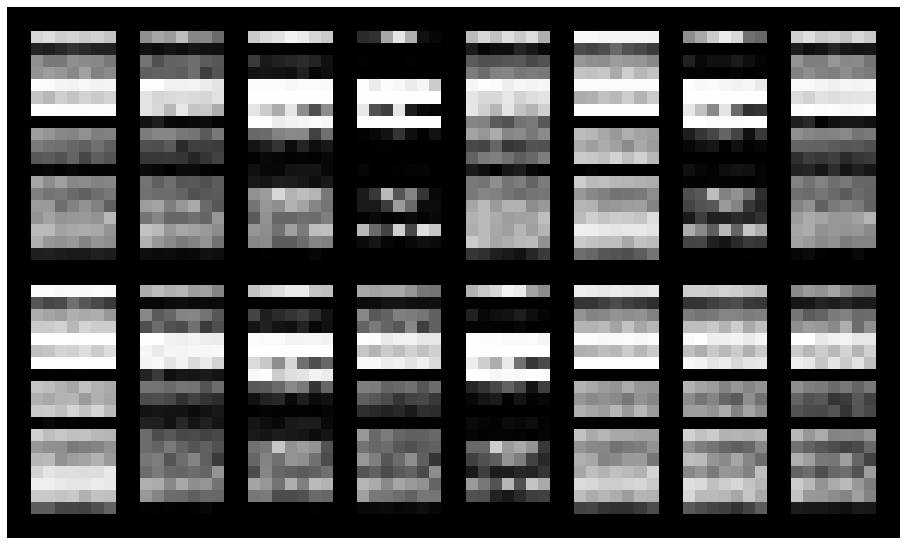

Epoch: [192/200], Batch Num: [0/54]
Discriminator Loss: 0.0398, Generator Loss: 6.3850
D(x): 0.9904, D(G(z)): 0.0038


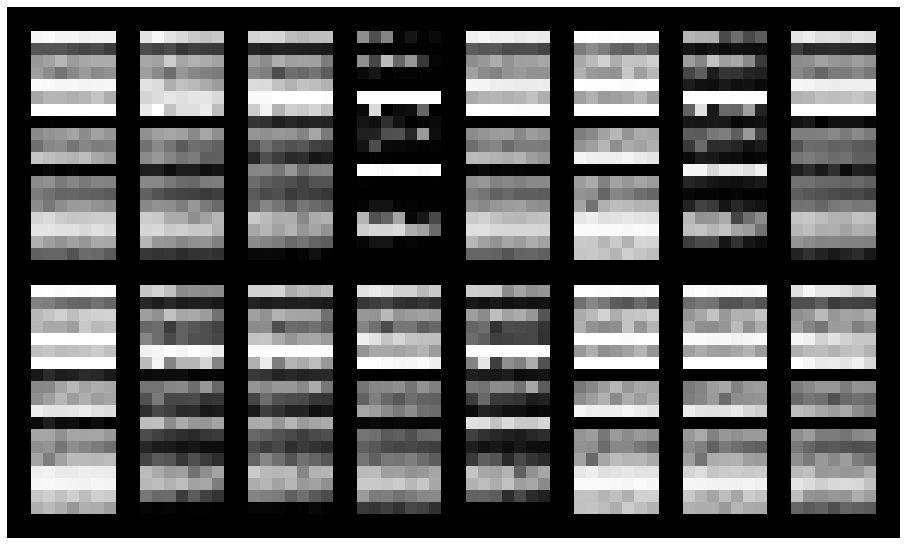

Epoch: [193/200], Batch Num: [0/54]
Discriminator Loss: 0.0091, Generator Loss: 6.3123
D(x): 0.9984, D(G(z)): 0.0054


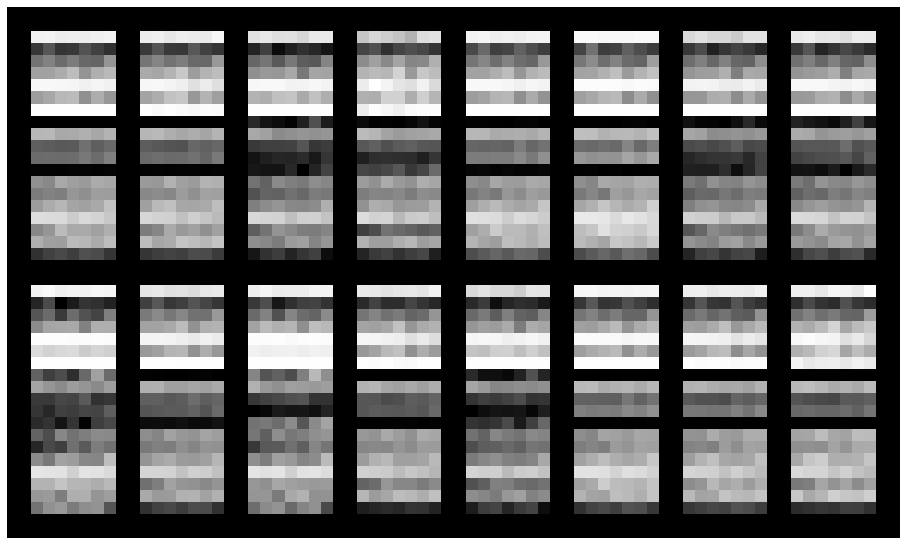

Epoch: [194/200], Batch Num: [0/54]
Discriminator Loss: 0.0341, Generator Loss: 6.6163
D(x): 0.9933, D(G(z)): 0.0024


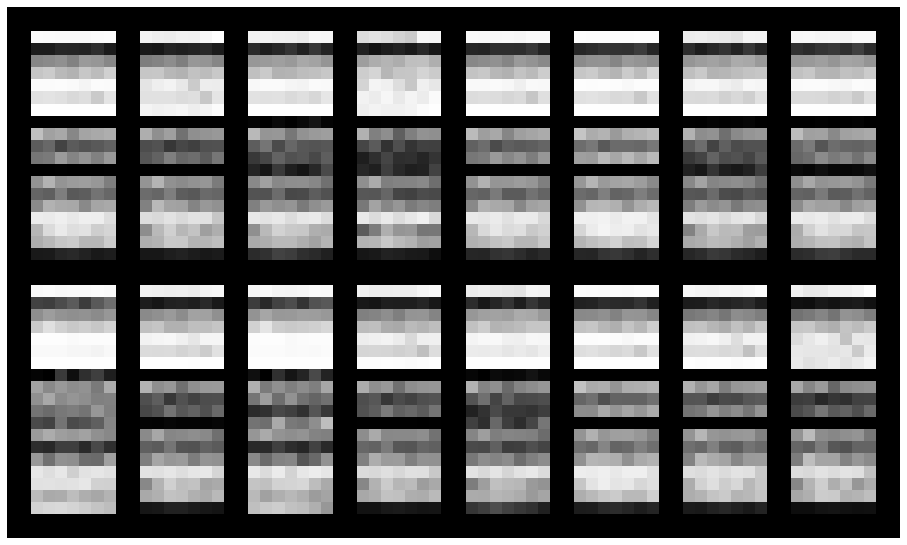

Epoch: [195/200], Batch Num: [0/54]
Discriminator Loss: 0.0486, Generator Loss: 6.6278
D(x): 0.9920, D(G(z)): 0.0046


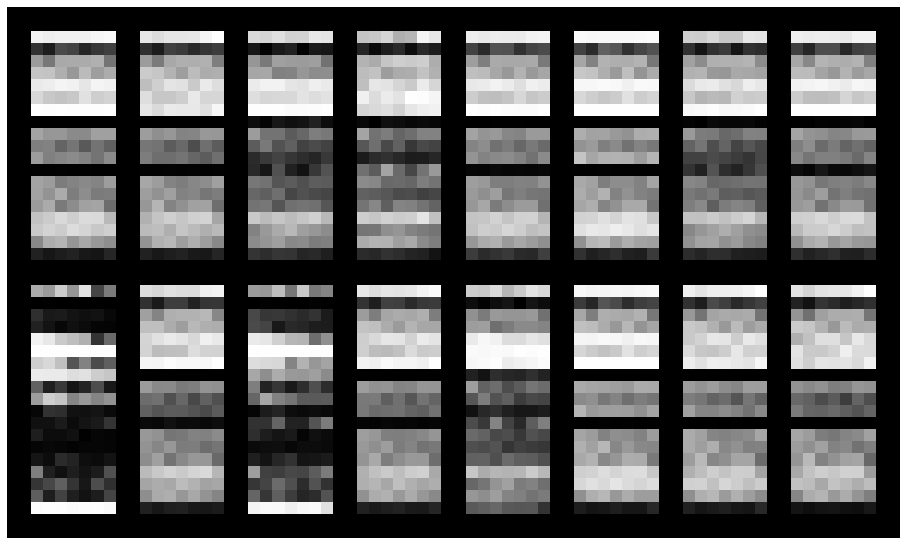

Epoch: [196/200], Batch Num: [0/54]
Discriminator Loss: 0.0207, Generator Loss: 6.1072
D(x): 0.9958, D(G(z)): 0.0055


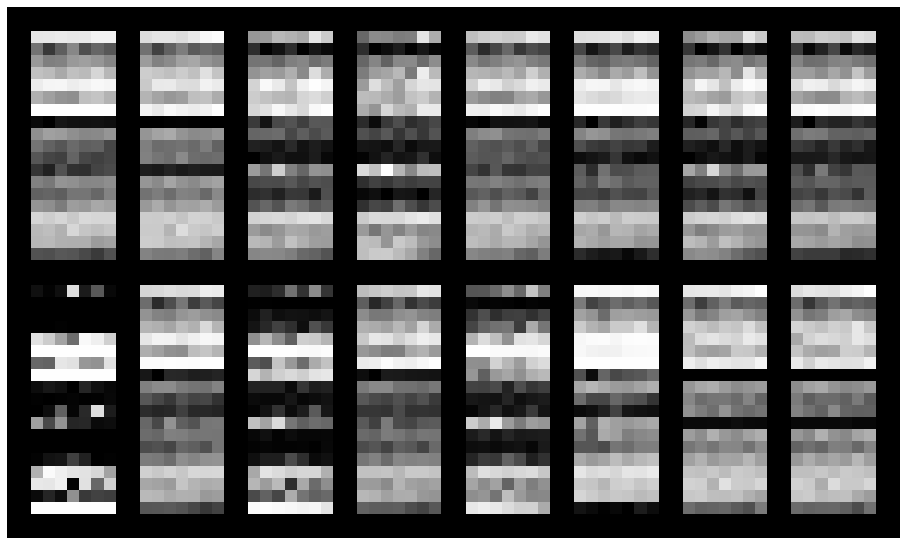

Epoch: [197/200], Batch Num: [0/54]
Discriminator Loss: 0.0235, Generator Loss: 7.0463
D(x): 0.9961, D(G(z)): 0.0079


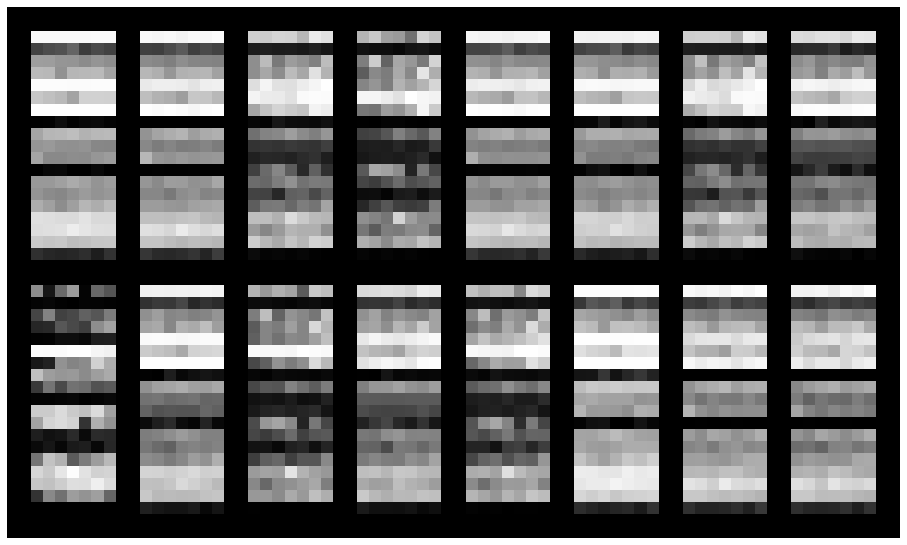

Epoch: [198/200], Batch Num: [0/54]
Discriminator Loss: 0.0630, Generator Loss: 6.6178
D(x): 0.9885, D(G(z)): 0.0019


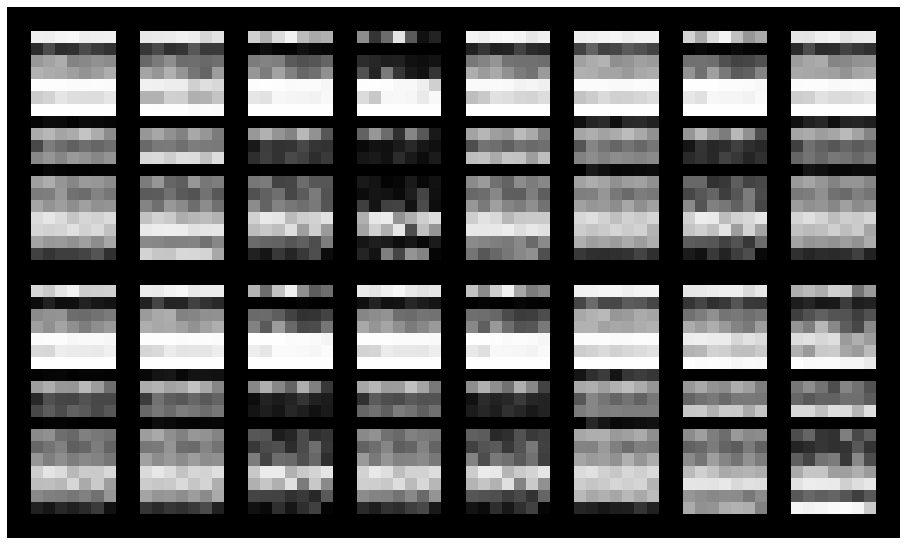

Epoch: [199/200], Batch Num: [0/54]
Discriminator Loss: 0.0183, Generator Loss: 7.1592
D(x): 0.9955, D(G(z)): 0.0045


In [56]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch) in enumerate(train_dataloader):
        N = real_batch.size(0)
        # print('real')
        # print(real_batch.dtype)
        # 1. Train Discriminator
        real_batch = real_batch - real_batch.mean(axis=0)
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        if torch.isnan(real_data).any():
            break
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches_train)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches_train
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches_train,
                d_error, g_error, d_pred_real, d_pred_fake
            )

In [69]:
test_data = generator(noise(1))

In [68]:
print(discriminator(test_data))

tensor([[0.0017]], grad_fn=<SigmoidBackward>)


In [59]:
import matplotlib.pyplot as plt

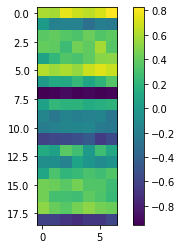

In [61]:
test_data = generator(noise(10))
plt.imshow(test_data[6].reshape(19,7).detach().numpy())
plt.colorbar()

In [54]:
for j,i in enumerate(real_data):
    if torch.isnan(i).any():
        pass
    else:
        print(j)

In [66]:
real_data

tensor([[-1.8586, -1.8241, -1.8341,  ..., -5.3352, -5.2624, -5.3957],
        [-1.1716, -0.8871, -1.0221,  ..., -4.8972, -4.8254, -4.7707],
        [-5.8586, -5.9491, -5.8341,  ..., -6.0852, -6.0754, -6.0837],
        ...,
        [ 2.3284,  2.4879,  2.3529,  ..., -0.5852, -0.6384, -0.5837],
        [ 1.3284,  1.4249,  1.5399,  ...,  0.3518,  0.3616,  0.2913],
        [-4.7966, -4.6991, -4.5841,  ..., -7.3982, -7.3884, -7.2717]])

In [65]:
generator(noise(1))

tensor([[ 0.9326,  0.9301,  0.9391,  0.9414,  0.9495,  0.8758,  0.9493, -0.0307,
         -0.3482, -0.3424, -0.1630, -0.0688, -0.4028, -0.2571,  0.2231,  0.1486,
          0.3977,  0.4700,  0.4147,  0.2801,  0.1676,  0.6043,  0.5887,  0.2670,
          0.3981,  0.4981,  0.5080,  0.4511,  0.8586,  0.8824,  0.8892,  0.8885,
          0.8262,  0.8562,  0.8504,  0.2369,  0.3844,  0.4089,  0.4501,  0.4259,
          0.4742,  0.3776,  0.9866,  0.9821,  0.9758,  0.9681,  0.9358,  0.9613,
          0.9716, -0.9997, -0.9993, -0.9996, -0.9996, -0.9995, -0.9997, -0.9998,
          0.2379,  0.3944,  0.3891,  0.3137,  0.1601,  0.0496,  0.3692,  0.2017,
          0.1146,  0.2515,  0.1994,  0.1930,  0.2602,  0.0737,  0.7290,  0.6921,
          0.7307,  0.7150,  0.6781,  0.5023,  0.6762, -0.9985, -0.9967, -0.9984,
         -0.9980, -0.9954, -0.9984, -0.9984,  0.3770,  0.3409,  0.4518,  0.5036,
          0.2850,  0.3653,  0.3417,  0.0596,  0.1132, -0.0010,  0.2010,  0.0487,
          0.0232,  0.0133,  

In [ ]:
noise(1)

In [ ]:
generator(noise(1))

In [45]:
tt1 = noise(1)
print(tt1)
t1 = generator(tt1)
print(t1)
print(t1.mean())
print(t1.std())

tensor([[ 0.9334,  1.0189,  0.7301, -2.9642,  0.7209,  0.1766,  2.0161, -0.1271,
         -0.7193, -1.2909,  0.8481, -0.7139, -0.1418, -0.2635, -0.7043, -0.3927,
         -0.3137, -0.1513, -1.3064,  1.0441, -1.6115, -0.8037, -0.8763,  0.9316,
         -0.2307,  1.1870, -1.4175,  0.9604, -1.3294,  0.1664,  0.0211,  0.6938,
         -0.7973,  0.1908, -0.7028, -0.3517, -0.8776,  0.9263,  0.4993, -0.7386,
         -1.3926, -0.8273, -0.0278,  0.7803, -0.4334, -1.6997,  0.1374, -0.0831,
          1.5015,  0.5619, -1.1741,  0.3526, -0.0408, -0.9568,  1.2555, -0.4962,
         -0.7416, -1.2514, -0.8976,  0.5356, -0.5355,  0.0303, -0.4418,  1.3465,
         -0.3012,  1.1064,  0.3285, -1.4055,  2.8769,  0.1798,  0.8312, -1.4172,
          0.8834, -0.6190,  0.1596, -0.9253, -0.2936, -0.1258, -0.4923, -1.3683,
         -0.8069, -1.4931,  0.3453, -0.5770,  0.4896,  1.3806,  0.3582,  0.4732,
          0.2406, -0.2734, -0.0622,  1.8519, -1.0342, -0.3523,  0.1939,  0.3368,
          0.7007,  1.1056,  

In [16]:
tt2 = noise(1)
print(tt2)
t2 = generator(tt2)
print(t2)
print(t2.mean())
print(t2.std())

tensor([[-1.4284,  0.0860,  1.0985, -1.7795, -1.0252, -1.0660,  0.6968, -1.8518,
          0.2453, -0.0441, -0.6277, -0.7943,  0.8118,  1.5244, -1.8160, -0.6808,
          0.4404,  1.6545,  0.8018,  1.3987,  1.0080,  0.8195, -0.2759, -0.3596,
          0.4624,  0.4810,  0.5694, -0.4815,  0.2947, -0.1934,  0.7124,  0.7817,
         -0.3969,  1.3360, -0.3793, -0.0166,  0.8607,  0.6713, -1.2244, -1.2644,
          0.1975,  0.5428,  0.3395, -0.8586,  0.2617, -0.1153, -0.4225, -0.5898,
          1.7104,  0.9744,  1.3040,  1.4649,  0.3118, -1.6869,  0.0174,  0.6912,
          1.1729,  0.3179, -0.4489, -0.9104,  0.2139,  0.7146,  0.1054,  0.9972,
          0.7786,  0.0041, -0.0761,  0.5781, -0.0317,  1.8923,  0.9836,  0.1443,
          0.2368,  1.5786,  2.5979, -1.3573,  0.1760, -1.3127,  0.3239, -0.0455,
          0.3085, -0.6454,  0.7284,  0.9485, -0.2413, -0.8181, -0.2275,  2.1184,
         -0.0670, -0.4697,  0.2076, -1.3785, -0.1941, -0.0654,  1.0073, -0.3938,
          0.5580,  1.0777,  

tensor(0.3990, grad_fn=<StdBackward0>)

In [ ]:
t2-t2.mean()

In [24]:
discriminator(real_batch[0]-real_batch[0].mean())

tensor([0.1239], grad_fn=<SigmoidBackward>)

In [ ]:
plt.imshow((real_batch[0]-real_batch[0].mean()).reshape(11,4))
plt.colorbar()

In [ ]:
means = []
for i in range(len(real_batch)):
    means.append(real_batch[i].mean())

In [ ]:
import numpy as np

In [ ]:
means[3]

In [ ]:
discriminator(real_batch[0])

In [ ]:
real_batch[0].mean()

In [ ]:
real_batch[0].std()

In [ ]:
means = real_batch.mean(axis=1)

In [ ]:
ff = (real_batch.T-means).T

In [28]:
import matplotlib.pyplot as plt

In [ ]:
tmp1 = real_batch[0] - real_batch[0].mean()
print(tmp1)
print(real_batch[0].std())

In [ ]:
tmp2 = real_batch[1] - real_batch[1].mean()
print(tmp2)
print(real_batch[1].mean())
print(real_batch[1])
print(real_batch[1].std())

In [ ]:
real_batch.std(axis=1)
plt.hist(real_batch.std(axis=1),bins=100)

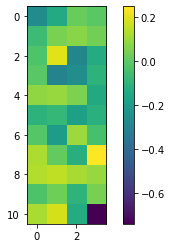

In [77]:
a = generator(noise(1))
a = a.detach().numpy()
plt.imshow(a.reshape(11,4))
plt.colorbar()

In [148]:
c = torch.tensor(a)

In [86]:
c += b.mean()

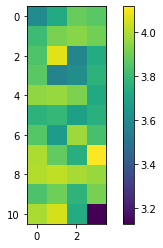

In [91]:
plt.imshow(c.reshape(11,4))
plt.colorbar()

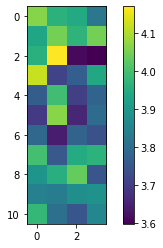

In [90]:
plt.imshow(b.reshape(11,4))
plt.colorbar()

In [133]:
b

tensor([2.1663, 1.2254, 1.1976, 2.4664, 1.8543, 2.0917, 3.0614, 2.6122, 2.1624,
        1.2210, 1.7120, 1.2284, 3.6033, 2.0725, 1.1992, 2.0196, 1.1767, 3.0549,
        1.7458, 2.1929, 0.5548, 1.6300, 2.4808, 1.7998, 2.1091, 1.4339, 2.2108,
        2.8506, 2.4809, 2.2975, 1.6516, 1.4294, 1.4937, 2.0903, 2.1746, 1.5794,
        2.5794, 1.3217, 1.9039, 2.3310, 1.8786, 1.1306, 1.3717, 6.7531])

In [141]:
abs(c+b.mean()-b).sum()

tensor(5.7299)

In [151]:
c += b.mean()

tensor([[3.6074, 3.7339, 3.8892, 3.8634, 3.8087, 3.9200, 3.9418, 3.9062, 3.8451,
         4.0747, 3.5851, 3.7365, 3.8655, 3.5709, 3.6171, 3.7687, 3.9544, 3.9673,
         3.9219, 3.7321, 3.7694, 3.7876, 3.6911, 3.7589, 3.8563, 3.6751, 3.9737,
         3.8306, 3.9981, 3.8800, 3.7489, 4.1180, 4.0038, 4.0243, 3.9904, 3.9644,
         3.8417, 3.9018, 3.7733, 3.9150, 3.9917, 4.0552, 3.7364, 3.1301]])

In [152]:
print(abs(c-b))
print(abs(c-b).sum())

tensor([[0.3934, 0.6740, 0.8571, 0.4375, 0.1198, 0.0062, 0.9542, 0.5405, 0.1518,
         1.0192, 0.0385, 0.6736, 1.5723, 0.3361, 0.5833, 0.0854, 0.9432, 0.9222,
         0.3415, 0.2953, 1.3801, 0.3230, 0.6243, 0.1246, 0.0873, 0.4067, 0.0716,
         0.8545, 0.3173, 0.2520, 0.2627, 0.8541, 0.6756, 0.0995, 0.0188, 0.5504,
         0.5722, 0.7456, 0.0348, 0.2505, 0.2785, 1.0901, 0.5302, 5.4575]])
tensor(26.8072)


tensor(2.0364)
tensor(0.9510)


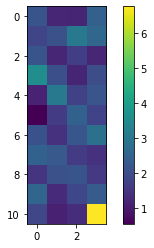

In [146]:
b = real_data[50]
print(b.mean())
print(b.std())
plt.imshow(b.reshape(11,4))
plt.colorbar()

In [107]:
print(b.mean())
print(b.std())

tensor(3.8709)
tensor(0.1422)


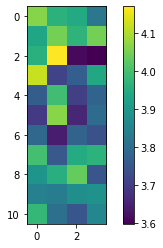

In [74]:
plt.imshow(b.reshape(11,4))
plt.colorbar()